In [2]:
# import modules 

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import zipfile
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [2]:
PROJECT_DIR = Path().resolve()
ZIP_PATH    = PROJECT_DIR / "home-credit-default-risk.zip"  # adjust if name differs
RAW_DIR     = PROJECT_DIR / "data" / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

assert ZIP_PATH.exists(), f"Zip not found at {ZIP_PATH}"

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    # extract only CSVs
    members = [m for m in z.namelist() if m.lower().endswith(".csv")]
    z.extractall(RAW_DIR, members)

print("Extracted files to:", RAW_DIR)
list(RAW_DIR.iterdir())[:10]


Extracted files to: D:\Data Science Projects\Home Credit Default Risk\data\raw


[WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/application_test.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/application_train.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/bureau.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/bureau_balance.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/credit_card_balance.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/HomeCredit_columns_description.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/installments_payments.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/POS_CASH_balance.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/previous_application.csv'),
 WindowsPath('D:/Data Science Projects/Home Credit Default Risk/data/raw/sample_submission.csv')]

In [2]:
DATA = Path("data/raw")
train = pd.read_csv(DATA / "application_train.csv")
test = pd.read_csv(DATA / "application_test.csv")
bureau = pd.read_csv(DATA / "bureau.csv")
bureau_balance = pd.read_csv(DATA / "bureau_balance.csv")
previous_application = pd.read_csv(DATA / "previous_application.csv")
pos_cash = pd.read_csv(DATA / "POS_CASH_balance.csv")
installments = pd.read_csv(DATA / "installments_payments.csv")
credit_card = pd.read_csv(DATA / "credit_card_balance.csv")

## Functions 

In [28]:
import pandas as pd
import numpy as np
def nulls_df(df, column_type=None, percentage_threshold=0):
    """
    Computes the count and percentage of null values in a DataFrame using Dask for memory optimization.
    
    Args:
        df (dask.dataframe.DataFrame): The input Dask DataFrame.
        column_type (str, optional): The type of columns to filter ('Categorical' or 'Numerical').
        percentage_threshold (int, optional): The minimum percentage of null values to include.
        
    Returns:
        tuple: A tuple containing the filtered DataFrame and a list of column names.
    """
    
    # Compute null counts and percentages
    nulls_counts = df.isna().sum()
    nulls_percentages = (nulls_counts / df.shape[0]) * 100
    
    # Identify column types
    column_types = df.dtypes.apply(lambda x: 'Numerical' if x.kind in 'bifc' else 'Categorical')
    
    # Create a DataFrame for null information
    null_df = pd.DataFrame({
        'Column': nulls_counts.index,
        'Nulls_Count': nulls_counts,
        'Nulls_Percentage': nulls_percentages,
        'Type': column_types
    })
    
    # Filter based on column type if specified
    if column_type:
        null_df = null_df[null_df['Type'] == column_type]
    
    # Filter based on null percentage threshold
    null_df = null_df[null_df['Nulls_Percentage'] >= percentage_threshold]
    
    # Reset index to default numeric indices
    null_df = null_df.reset_index(drop=True)
    return null_df    

In [4]:
def plot_histgram(data, column):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=column, bins=100, kde=True)
    plt.title(f'Distribution of {column} with target' , fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

In [5]:
def plot_boxplot(data, column):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x='TARGET',y = column)
    plt.title(f'Distribution of {column}' , fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

## start working

In [6]:
# checking the datashape of the training data 
train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

* in this case we have 122 feature and this is not practical to check each feature by hand then we need to use feature importance to do feature selection to reduce the number of features

In [7]:
train_copy = train.copy()
categorical_columns = train_copy.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    train_copy[col] = train_copy[col].astype('category')

* we will use feature importance using light gbm algorithm 

In [9]:
# using baseline model with all features 
X = train_copy.drop(['TARGET'], axis=1)
y = train_copy['TARGET']
model_full = LGBMClassifier(random_state=42)

scores_full = cross_val_score(
    model_full,
    X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("Baseline AUC:", scores_full.mean())


Baseline AUC: 0.7538326425452313


In [10]:
model_full.fit(X,y)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11566
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


LGBMClassifier(random_state=42)

In [11]:
booster = model_full.booster_
importance_gain = booster.feature_importance(importance_type='gain')

imp_df_gain = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance_gain': importance_gain
}).sort_values(by='importance_gain', ascending=False)

imp_df_gain['feature']

42          EXT_SOURCE_3
41          EXT_SOURCE_2
40          EXT_SOURCE_1
39     ORGANIZATION_TYPE
7             AMT_CREDIT
             ...        
108     FLAG_DOCUMENT_15
112     FLAG_DOCUMENT_19
110     FLAG_DOCUMENT_17
113     FLAG_DOCUMENT_20
114     FLAG_DOCUMENT_21
Name: feature, Length: 121, dtype: object

In [ ]:
# create a set of number of features and the model will train each model with different number of feature
features = [5]
for i in range(23):
    new_item = features[i] + 5
    features.append(new_item)

In [ ]:
# training the model with different number of features to show the model
models_results = {}
for num_features in features:
    top_features = imp_df_gain.head(num_features)['feature'].tolist()
    X_top = X[top_features]
    model_top = LGBMClassifier(random_state=42)
    scores_top = cross_val_score(
    model_top,
    X_top, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
    )
    models_results[num_features] = scores_top.mean()



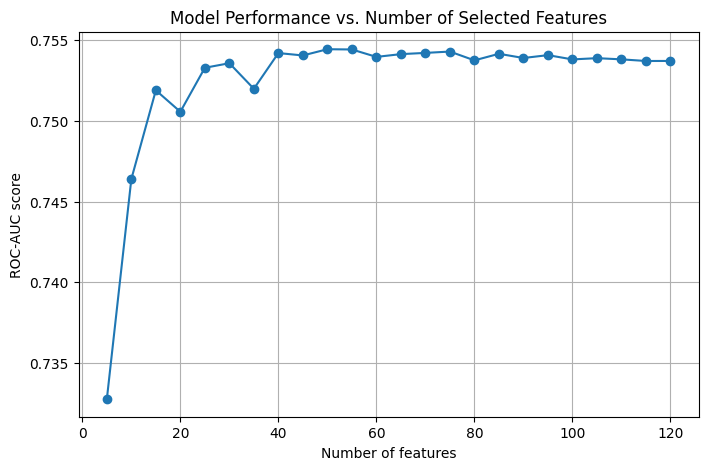

In [ ]:
import matplotlib.pyplot as plt

# Extract x and y values
x = list(models_results.keys())
y = [float(v) for v in models_results.values()]  # ensure standard floats

# Plot
plt.figure(figsize=(8,5))
plt.plot(x, y, marker='o')
plt.xlabel("Number of features")
plt.ylabel("ROC-AUC score")
plt.title("Model Performance vs. Number of Selected Features")
plt.grid(True)
plt.show()


* based on this graph we will choose the first 25 features 

In [8]:
top_features = ['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'ORGANIZATION_TYPE',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'OCCUPATION_TYPE',
 'DAYS_EMPLOYED',
 'OWN_CAR_AGE',
 'NAME_EDUCATION_TYPE',
 'DAYS_ID_PUBLISH',
 'CODE_GENDER',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'FLAG_DOCUMENT_3',
 'NAME_CONTRACT_TYPE',
 'SK_ID_CURR',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_POPULATION_RELATIVE',
 'TOTALAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'TARGET']
train_reduced = train_copy[top_features]

In [9]:
top_features = imp_df_gain.head(25)['feature'].tolist()
top_features.append("TARGET")
train_reduced = train_copy[top_features]

NameError: name 'imp_df_gain' is not defined

### EDA Part for train reduced 

In [9]:
train_reduced


EXT_SOURCE_3  EXT_SOURCE_2  EXT_SOURCE_1       ORGANIZATION_TYPE  \
0           0.139376      0.262949      0.083037  Business Entity Type 3   
1                NaN      0.622246      0.311267                  School   
2           0.729567      0.555912           NaN              Government   
3                NaN      0.650442           NaN  Business Entity Type 3   
4                NaN      0.322738           NaN                Religion   
...              ...           ...           ...                     ...   
307506           NaN      0.681632      0.145570                Services   
307507           NaN      0.115992           NaN                     XNA   
307508      0.218859      0.535722      0.744026                  School   
307509      0.661024      0.514163           NaN  Business Entity Type 1   
307510      0.113922      0.708569      0.734460  Business Entity Type 3   

        AMT_CREDIT  DAYS_BIRTH  AMT_GOODS_PRICE  AMT_ANNUITY OCCUPATION_TYPE  \
0         406597.5       -9461         351000.0      24700.5        Laborers   
1        1293502.5      -16765        1129500.0      35698.5      Core staff   
2         135000.0      -19046         135000.0       6750.0        Laborers   
3         312682.5      -19005         297000.0      29686.5        Laborers   
4         513000.0      -19932         513000.0      21865.5      Core staff   
...            ...         ...              ...          ...             ...   
307506    254700.0       -9327         225000.0      27558.0     Sales staff   
307507    269550.0      -20775         225000.0      12001.5             NaN   
307508    677664.0      -14966         585000.0      29979.0        Managers   
307509    370107.0      -11961         319500.0      20205.0        Laborers   
307510    675000.0      -16856         675000.0      49117.5        Laborers   

        DAYS_EMPLOYED  ...  FLAG_DOCUMENT_3 NAME_CONTRACT_TYPE  SK_ID_CURR  \
0                -637  ...                1         Cash loans      100002   
1               -1188  ...                1         Cash loans      100003   
2                -225  ...                0    Revolving loans      100004   
3               -3039  ...                1         Cash loans      100006   
4               -3038  ...                0         Cash loans      100007   
...               ...  ...              ...                ...         ...   
307506           -236  ...                0         Cash loans      456251   
307507         365243  ...                1         Cash loans      456252   
307508          -7921  ...                1         Cash loans      456253   
307509          -4786  ...                1         Cash loans      456254   
307510          -1262  ...                1         Cash loans      456255   

       REGION_RATING_CLIENT_W_CITY  REGION_POPULATION_RELATIVE  \
0                                2                    0.018801   
1                                1                    0.003541   
2                                2                    0.010032   
3                                2                    0.008019   
4                                2                    0.028663   
...                            ...                         ...   
307506                           1                    0.032561   
307507                           2                    0.025164   
307508                           3                    0.005002   
307509                           2                    0.005313   
307510                           1                    0.046220   

        TOTALAREA_MODE  DEF_30_CNT_SOCIAL_CIRCLE AMT_REQ_CREDIT_BUREAU_YEAR  \
0               0.0149                       2.0                        1.0   
1               0.0714                       0.0                        0.0   
2                  NaN                       0.0                        0.0   
3                  NaN                       0.0                        NaN   
4        

In [10]:
nulls_df(train_reduced).sort_values(by='Nulls_Percentage', ascending=False)

Column  Nulls_Count  Nulls_Percentage         Type
10                  OWN_CAR_AGE       202929         65.990810    Numerical
2                  EXT_SOURCE_1       173378         56.381073    Numerical
21               TOTALAREA_MODE       148431         48.268517    Numerical
8               OCCUPATION_TYPE        96391         31.345545  Categorical
0                  EXT_SOURCE_3        60965         19.825307    Numerical
23   AMT_REQ_CREDIT_BUREAU_YEAR        41519         13.501631    Numerical
24    AMT_REQ_CREDIT_BUREAU_QRT        41519         13.501631    Numerical
22     DEF_30_CNT_SOCIAL_CIRCLE         1021          0.332021    Numerical
1                  EXT_SOURCE_2          660          0.214626    Numerical
6               AMT_GOODS_PRICE          278          0.090403    Numerical
7                   AMT_ANNUITY           12          0.003902    Numerical
14       DAYS_LAST_PHONE_CHANGE            1          0.000325    Numerical
4                    AMT_CREDIT            0          0.000000    Numerical
5                    DAYS_BIRTH            0          0.000000    Numerical
9                 DAYS_EMPLOYED            0          0.000000    Numerical
3             ORGANIZATION_TYPE            0          0.000000  Categorical
12              DAYS_ID_PUBLISH            0          0.000000    Numerical
11          NAME_EDUCATION_TYPE            0          0.000000  Categorical
17           NAME_CONTRACT_TYPE            0          0.000000  Categorical
16              FLAG_DOCUMENT_3            0          0.000000    Numerical
15            DAYS_REGISTRATION            0          0.000000    Numerical
13                  CODE_GENDER            0          0.000000  Categorical
20   REGION_POPULATION_RELATIVE            0          0.000000    Numerical
19  REGION_RATING_CLIENT_W_CITY            0          0.000000    Numerical
18                   SK_ID_CURR            0          0.000000    Numerical
25                       TARGET            0          0.000000    Numerical

In [11]:
train_reduced.info()
train_reduced.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   EXT_SOURCE_3                 246546 non-null  float64 
 1   EXT_SOURCE_2                 306851 non-null  float64 
 2   EXT_SOURCE_1                 134133 non-null  float64 
 3   ORGANIZATION_TYPE            307511 non-null  category
 4   AMT_CREDIT                   307511 non-null  float64 
 5   DAYS_BIRTH                   307511 non-null  int64   
 6   AMT_GOODS_PRICE              307233 non-null  float64 
 7   AMT_ANNUITY                  307499 non-null  float64 
 8   OCCUPATION_TYPE              211120 non-null  category
 9   DAYS_EMPLOYED                307511 non-null  int64   
 10  OWN_CAR_AGE                  104582 non-null  float64 
 11  NAME_EDUCATION_TYPE          307511 non-null  category
 12  DAYS_ID_PUBLISH              307511 non-null

count           mean            std  \
EXT_SOURCE_3                 246546.0       0.510853       0.194844   
EXT_SOURCE_2                 306851.0       0.514393       0.191060   
EXT_SOURCE_1                 134133.0       0.502130       0.211062   
AMT_CREDIT                   307511.0  599025.999706  402490.776996   
DAYS_BIRTH                   307511.0  -16036.995067    4363.988632   
AMT_GOODS_PRICE              307233.0  538396.207429  369446.460540   
AMT_ANNUITY                  307499.0   27108.573909   14493.737315   
DAYS_EMPLOYED                307511.0   63815.045904  141275.766519   
OWN_CAR_AGE                  104582.0      12.061091      11.944812   
DAYS_ID_PUBLISH              307511.0   -2994.202373    1509.450419   
DAYS_LAST_PHONE_CHANGE       307510.0    -962.858788     826.808487   
DAYS_REGISTRATION            307511.0   -4986.120328    3522.886321   
FLAG_DOCUMENT_3              307511.0       0.710023       0.453752   
SK_ID_CURR                   307511.0  278180.518577  102790.175348   
REGION_RATING_CLIENT_W_CITY  307511.0       2.031521       0.502737   
REGION_POPULATION_RELATIVE   307511.0       0.020868       0.013831   
TOTALAREA_MODE               159080.0       0.102547       0.107462   
DEF_30_CNT_SOCIAL_CIRCLE     306490.0       0.143421       0.446698   
AMT_REQ_CREDIT_BUREAU_YEAR   265992.0       1.899974       1.869295   
AMT_REQ_CREDIT_BUREAU_QRT    265992.0       0.265474       0.794056   
TARGET                       307511.0       0.080729       0.272419   

                                      min            25%            50%  \
EXT_SOURCE_3                 5.272652e-04       0.370650       0.535276   
EXT_SOURCE_2                 8.173617e-08       0.392457       0.565961   
EXT_SOURCE_1                 1.456813e-02       0.334007       0.505998   
AMT_CREDIT                   4.500000e+04  270000.000000  513531.000000   
DAYS_BIRTH                  -2.522900e+04  -19682.000000  -15750.000000   
AMT_GOODS_PRICE              4.050000e+04  238500.000000  450000.000000   
AMT_ANNUITY                  1.615500e+03   16524.000000   24903.000000   
DAYS_EMPLOYED               -1.791200e+04   -2760.000000   -1213.000000   
OWN_CAR_AGE                  0.000000e+00       5.000000       9.000000   
DAYS_ID_PUBLISH             -7.197000e+03   -4299.000000   -3254.000000   
DAYS_LAST_PHONE_CHANGE      -4.292000e+03   -1570.000000    -757.000000   
DAYS_REGISTRATION           -2.467200e+04   -7479.500000   -4504.000000   
FLAG_DOCUMENT_3              0.000000e+00       0.000000       1.000000   
SK_ID_CURR                   1.000020e+05  189145.500000  278202.000000   
REGION_RATING_CLIENT_W_CITY  1.000000e+00       2.000000       2.000000   
REGION_POPULATION_RELATIVE   2.900000e-04       0.010006       0.018850   
TOTALAREA_MODE               0.000000e+00       0.041200       0.068800   
DEF_30_CNT_SOCIAL_CIRCLE     0.000000e+00       0.000000       0.000000   
AMT_REQ_CREDIT_BUREAU_YEAR   0.000000e+00       0.000000       1.000000   
AMT_REQ_CREDIT_BUREAU_QRT    0.000000e+00       0.000000       0.000000   
TARGET                       0.000000e+00       0.000000       0.000000   

                                       75%           max  
EXT_SOURCE_3                      0.669057  8.960095e-01  
EXT_SOURCE_2                      0.663617  8.549997e-01  
EXT_SOURCE_1                      0.675053  9.626928e-01  
AMT_CREDIT                   808650.000000  4.050000e+06  
DAYS_BIRTH                   -12413.000000 -7.489000e+03  
AMT_GOODS_PRICE              679500.000000  4.050000e+06  
AMT_ANNUITY                   34596.000000  2.580255e+05  
DAYS_EMPLOYED                  -289.000000  3.652430e+05  
OWN_CAR_AGE                      15.000000  9.100000e+01  
DAYS_ID_PUBLISH               -1720.000000  0.000000e+00  
DAYS_LAST_PHONE_CHANGE         -274.000000  0.000000e+00  
DAYS_REGISTRATION             -2010.000000  0.000000e+00  
FLAG_DOCUMENT_3                   1.000000  1.00000

* DAYS_BIRTH column is negative we need to convert it to positive and with years 

### DAYS_BIRTH && DAYS_EMPLOYED

In [12]:
# now we will convert this to years 
train_reduced['AGE'] = -train_reduced['DAYS_BIRTH'] / 365
train_reduced['YEARS_EMPLOYED'] = -train_reduced['DAYS_EMPLOYED']/365
train_reduced['YEARS_ID_PUBLISH'] = -train_reduced['DAYS_ID_PUBLISH']/365
train_reduced['YEARS_LAST_PHONE_CHANGE'] = -train_reduced['DAYS_LAST_PHONE_CHANGE']/365
train_reduced['YEARS_REGISTRATION'] = -train_reduced['DAYS_REGISTRATION']/365

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\2305951025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced['AGE'] = -train_reduced['DAYS_BIRTH'] / 365
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\2305951025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced['YEARS_EMPLOYED'] = -train_reduced['DAYS_EMPLOYED']/365
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\2305951025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

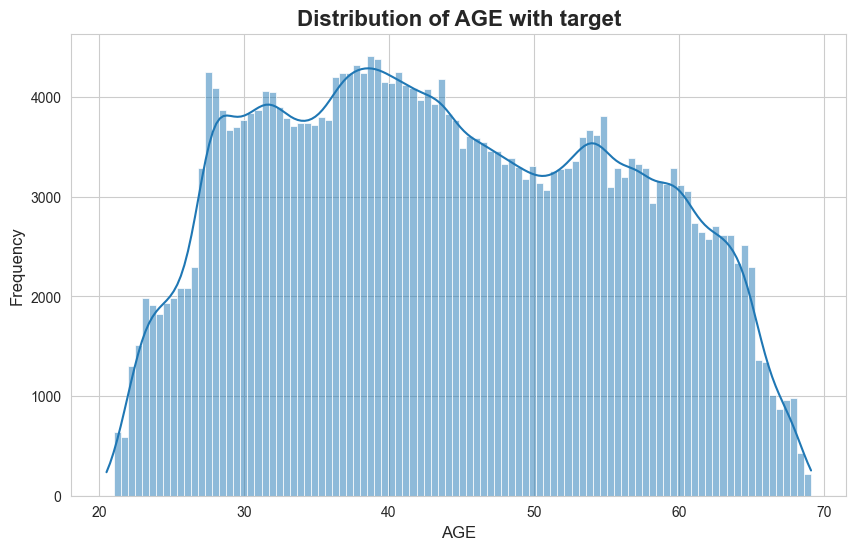

In [13]:
# showing the age to check the outliers
plot_histgram(train_reduced, "AGE")

* age column has no problems 

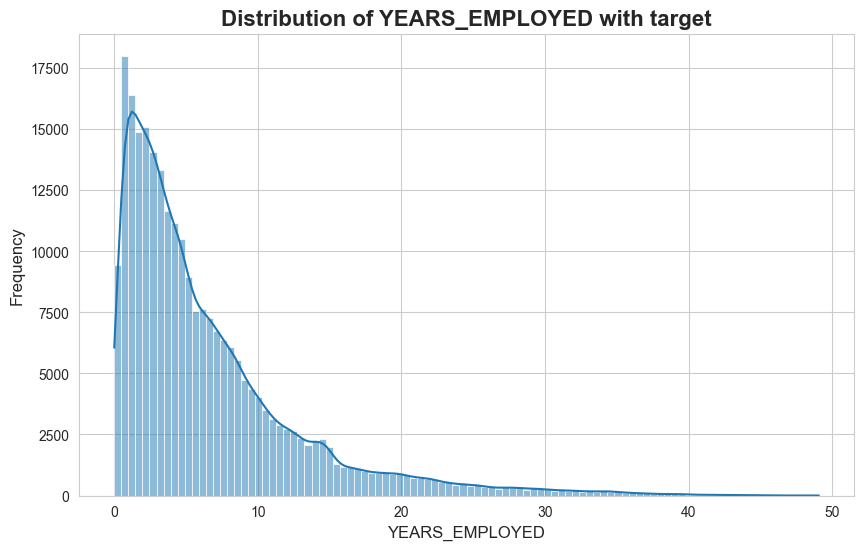

In [14]:
plot_histgram(train_reduced, "YEARS_EMPLOYED")

* based on this distribution we can 1000 not logic we need to impute this with the nan

In [14]:
train_reduced['YEARS_EMPLOYED'] = train_reduced['YEARS_EMPLOYED'].apply(lambda x:np.nan if x < 0 else x)

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\3051505957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced['YEARS_EMPLOYED'] = train_reduced['YEARS_EMPLOYED'].apply(lambda x:np.nan if x < 0 else x)


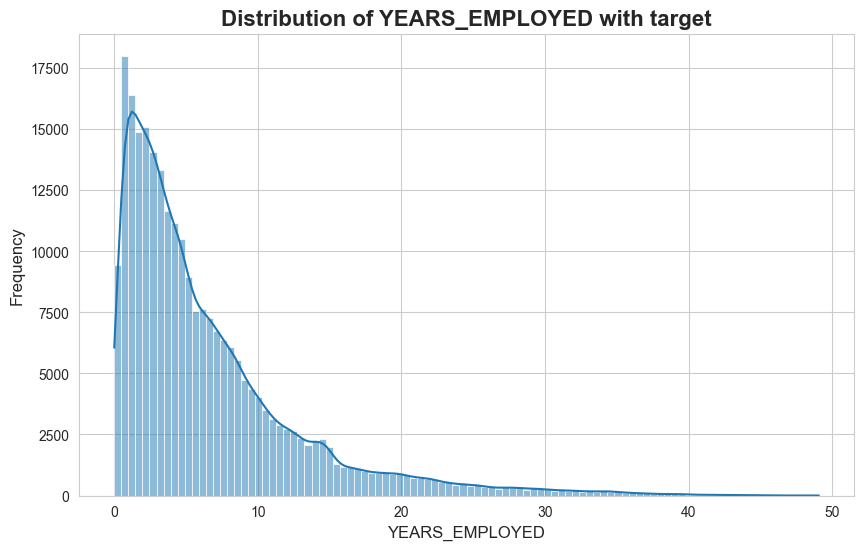

In [17]:
plot_histgram(train_reduced, "YEARS_EMPLOYED")

In [15]:
# now we can drop days birth days employed 
train_reduced.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION'], axis=1, inplace=True)

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\4129216624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION'], axis=1, inplace=True)


## Univariate Analysis for numerical columns 

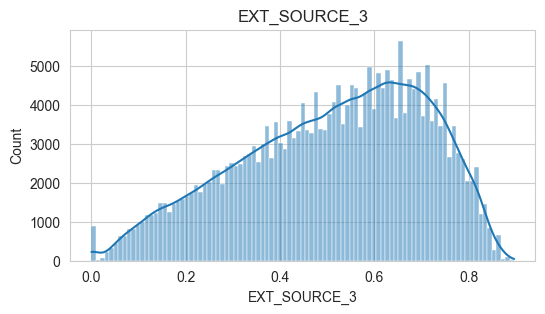

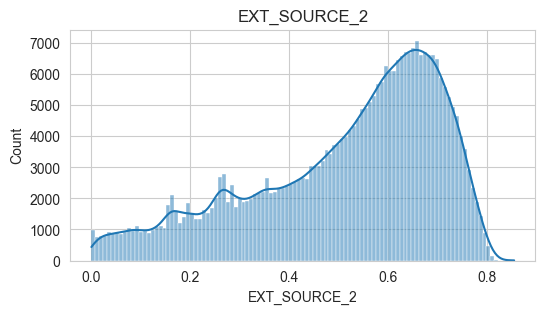

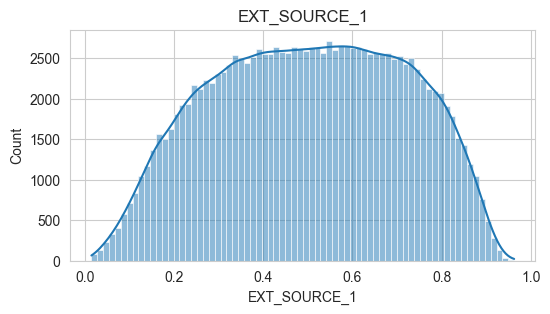

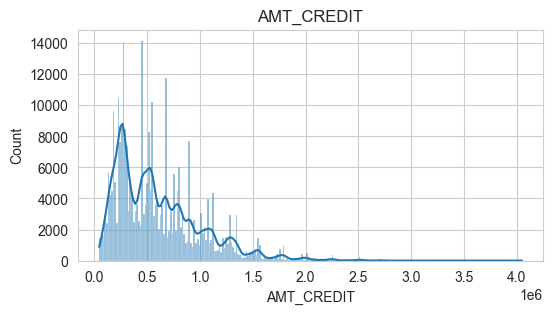

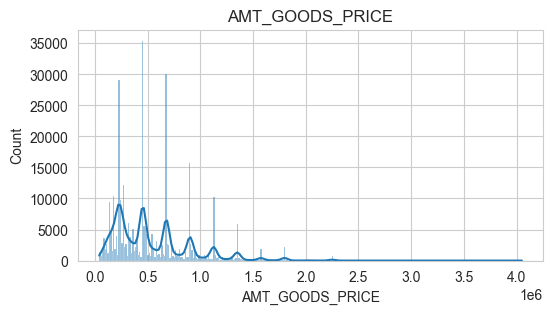

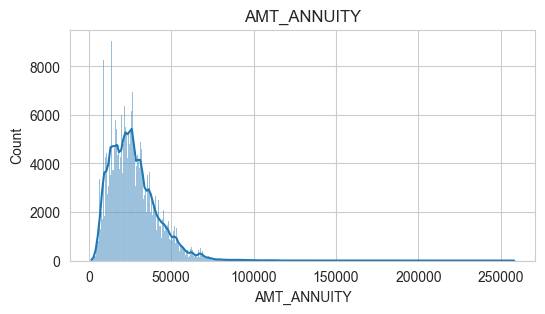

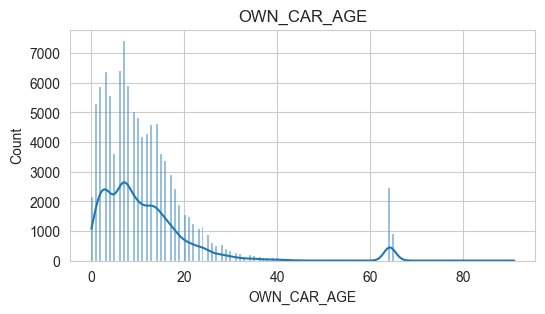

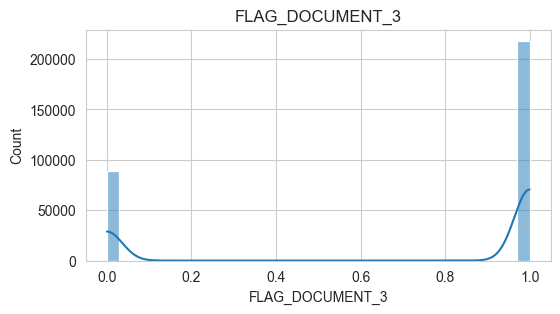

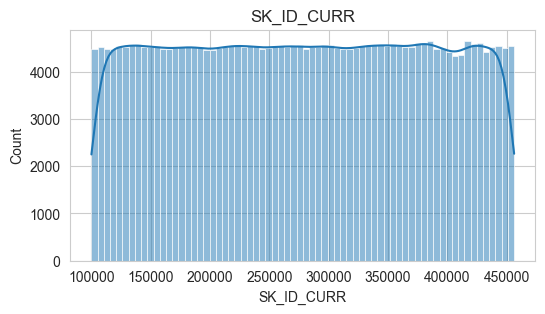

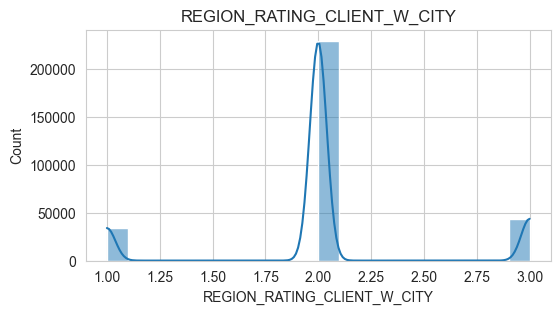

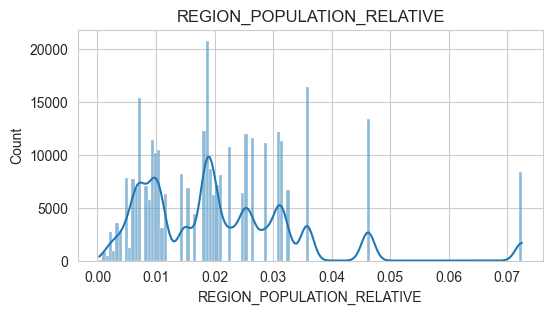

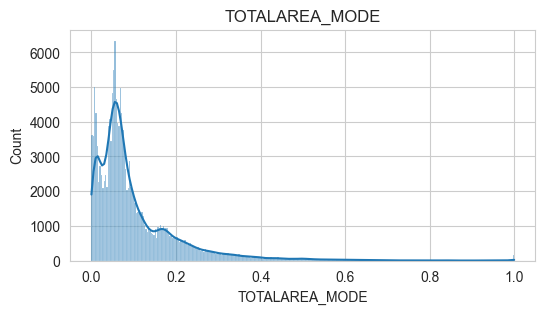

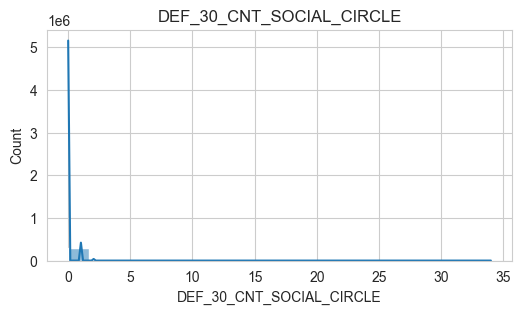

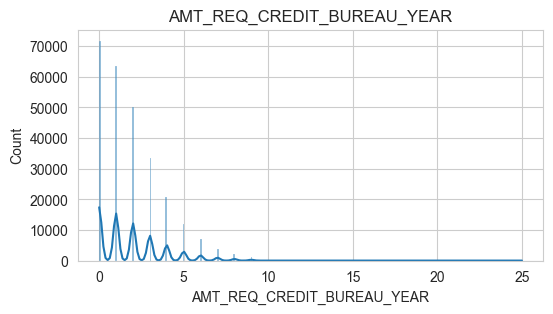

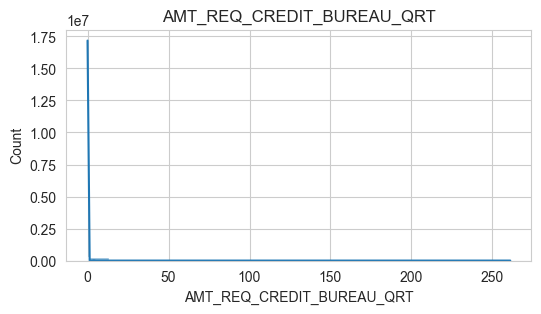

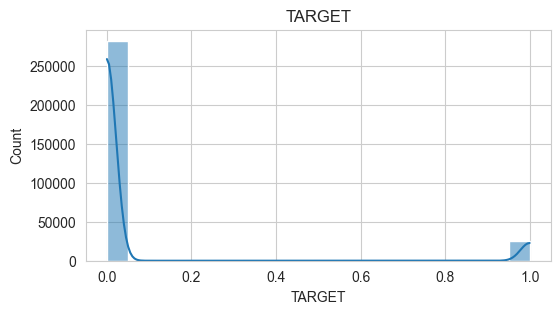

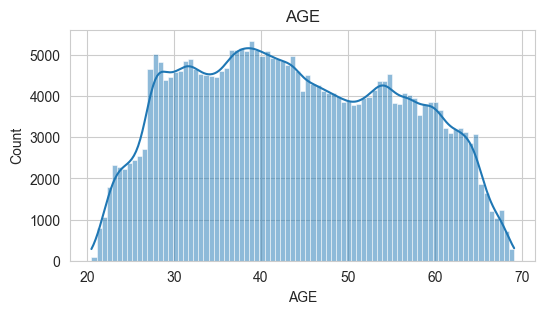

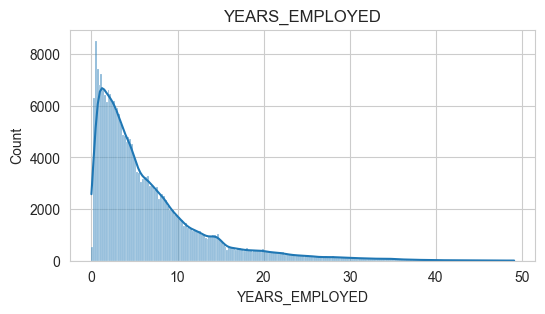

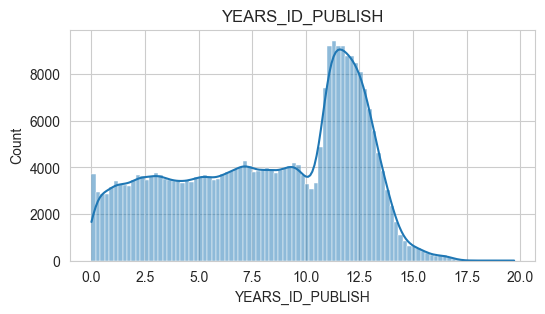

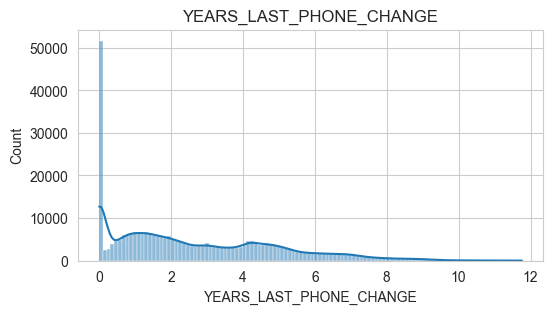

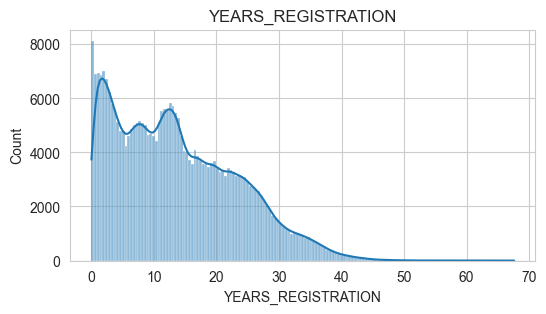

In [19]:
num_cols = train_reduced.select_dtypes(include='number').columns.to_list()
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(train_reduced[col], kde=True)
    plt.title(col)
    plt.show()

* flag_document_3 is a categorical variable 
* region rating is a categorical variable 
* region_rating_client_w_city --> category
* def_30_cnt_social_circle --> 
* amt_req_credit_bureau_qrt

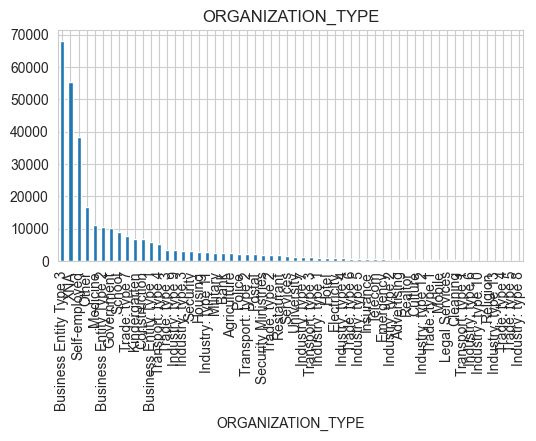

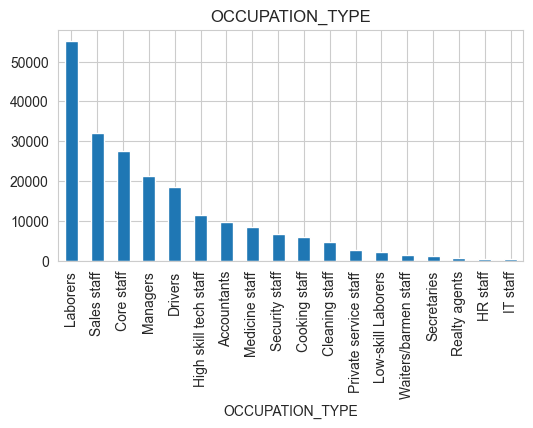

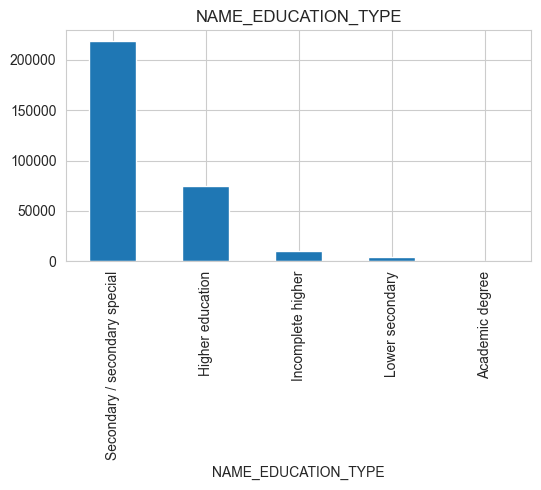

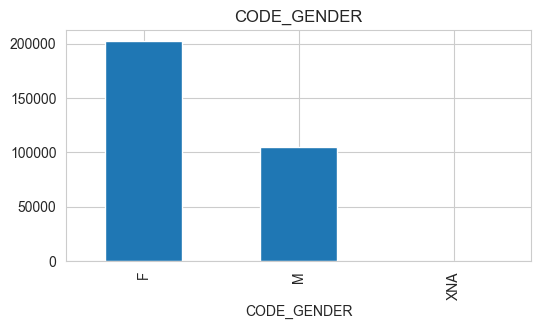

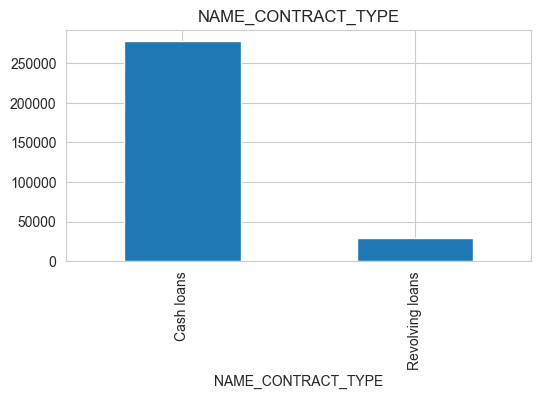

In [20]:
cat_cols = train_reduced.select_dtypes(include='category').columns.to_list()
for col in cat_cols:
    plt.figure(figsize=(6,3))
    train_reduced[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57],
 [Text(0, 0, 'Advertising'),
  Text(1, 0, 'Agriculture'),
  Text(2, 0, 'Bank'),
  Text(3, 0, 'Business Entity Type 1'),
  Text(4, 0, 'Business Entity Type 2'),
  Text(5, 0, 'Business Entity Type 3'),
  Text(6, 0, 'Cleaning'),
  Text(7, 0, 'Construction'),
  Text(8, 0, 'Culture'),
  Text(9, 0, 'Electricity'),
  Text(10, 0, 'Emergency'),
  Text(11, 0, 'Government'),
  Text(12, 0, 'Hotel'),
  Text(13, 0, 'Housing'),
  Text(14, 0, 'Industry: type 1'),
  Text(15, 0, 'Industry: type 10'),
  Text(16, 0, 'Industry: type 11'),
  Text(17, 0, 'Industry: type 12'),
  Text(18, 0, 'Industry: type 13'),
  Text(19, 0, 'Industry: type 2'),
  Text(20, 0, 'Industry: type 

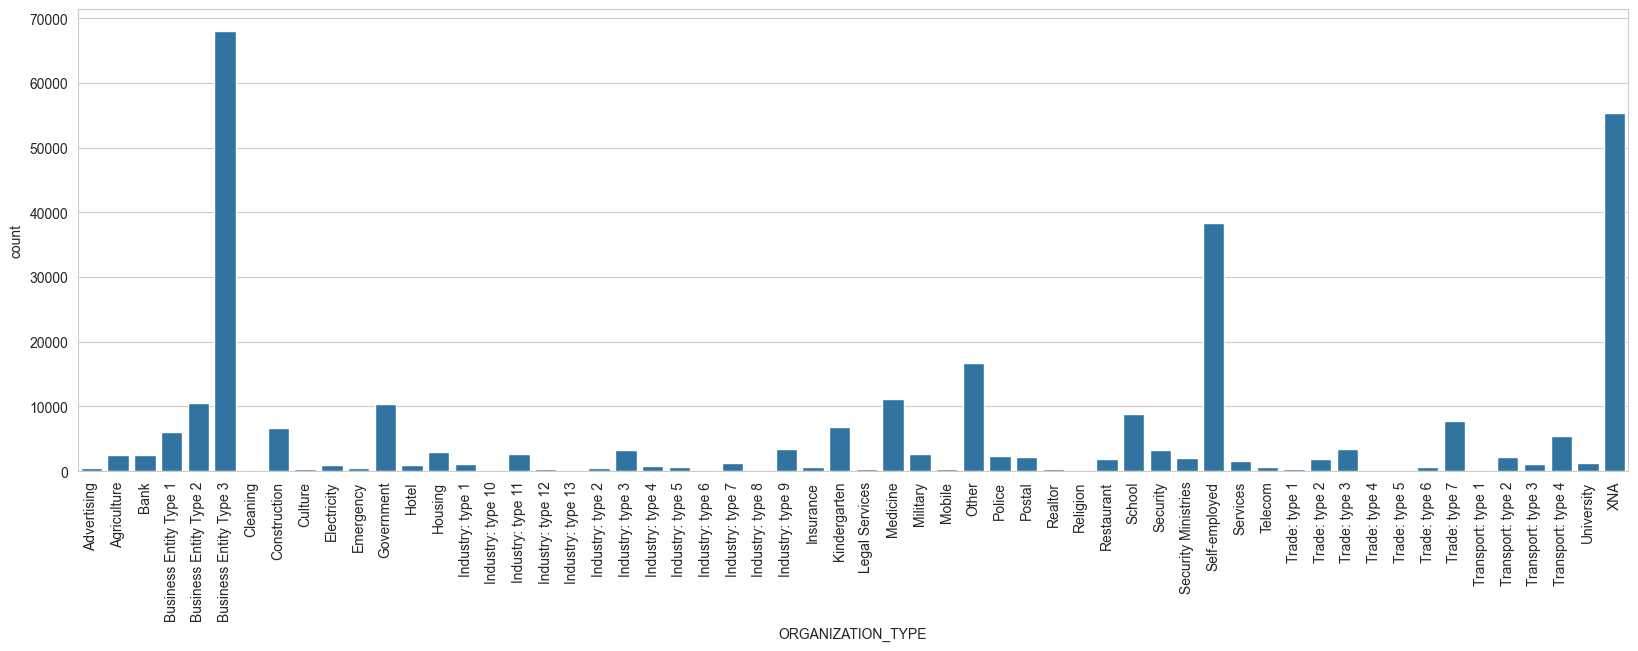

In [29]:
plt.figure(figsize=(20,6))
sns.countplot(data=train_reduced, x='ORGANIZATION_TYPE')
plt.xticks(rotation = 90)


* in the univariant analysis we discover the categories and if there any outliers or skwness

## Bivariate Analysis

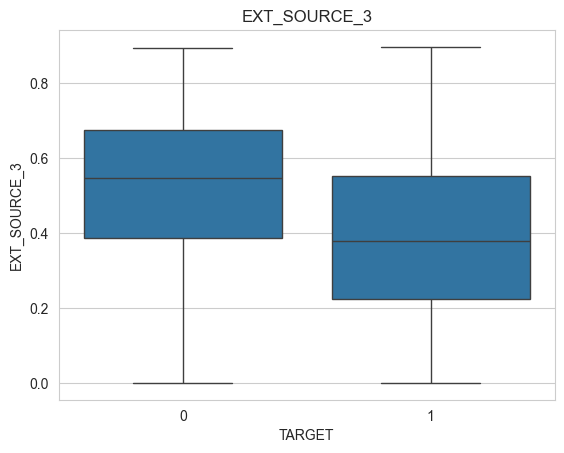

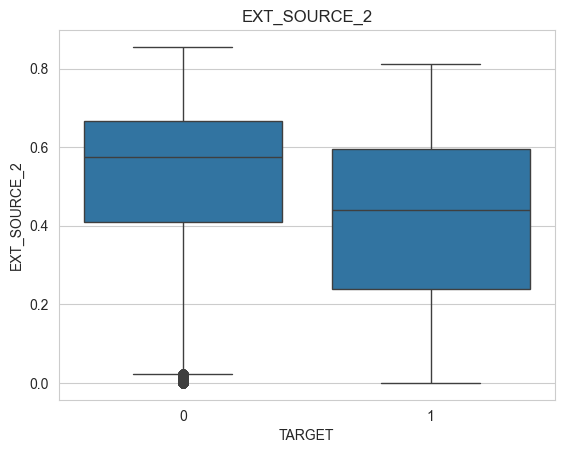

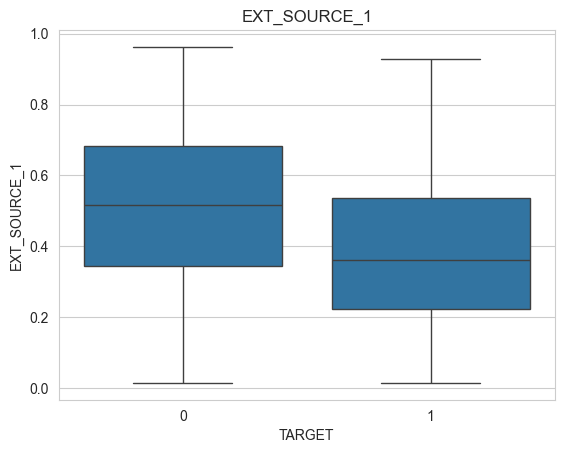

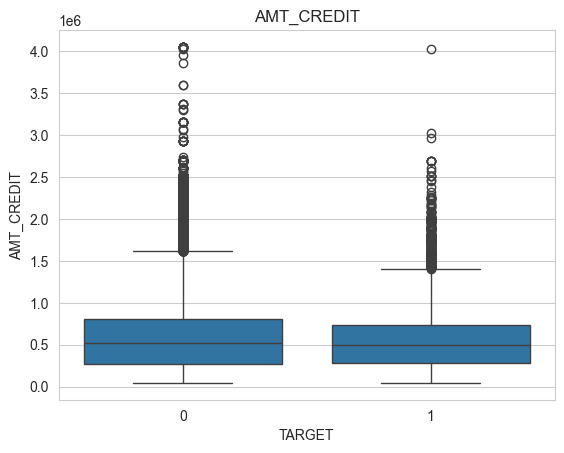

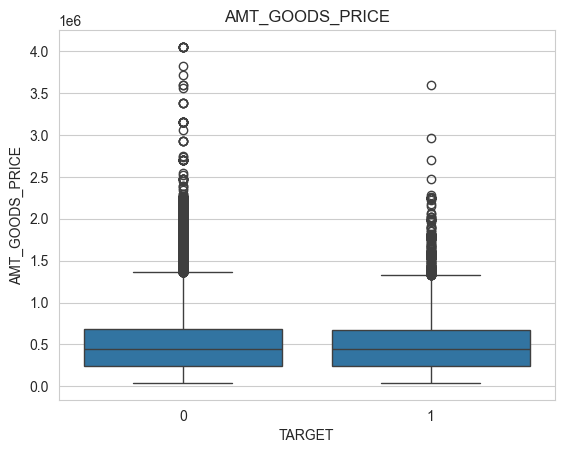

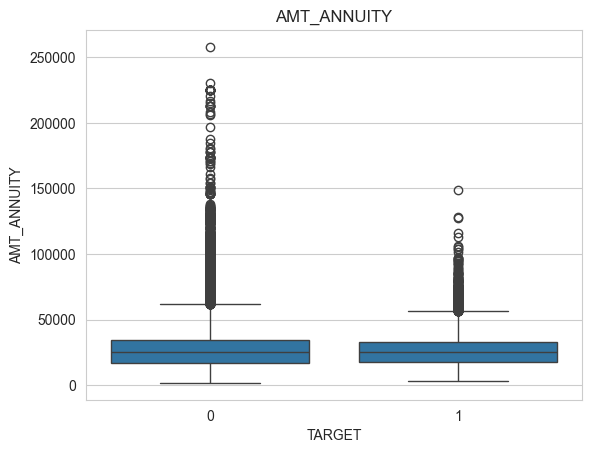

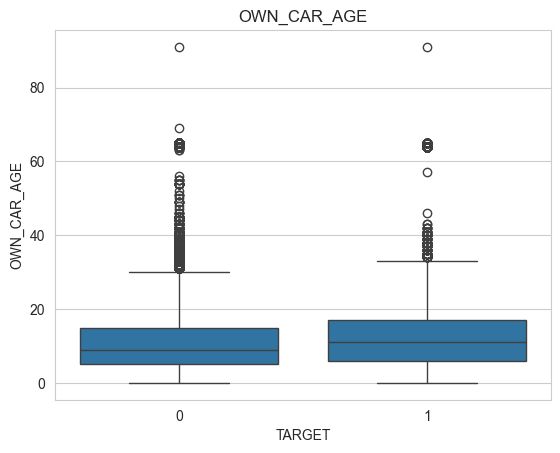

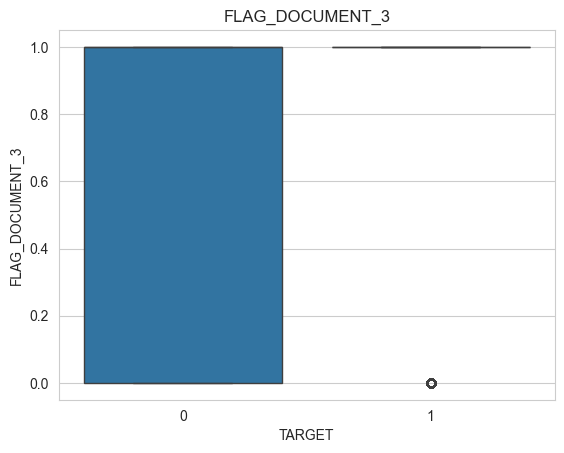

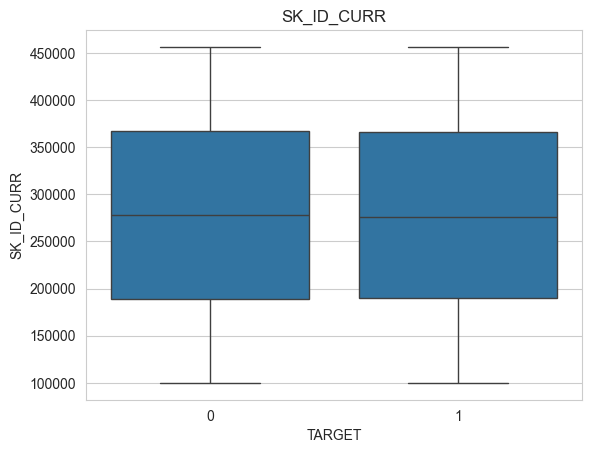

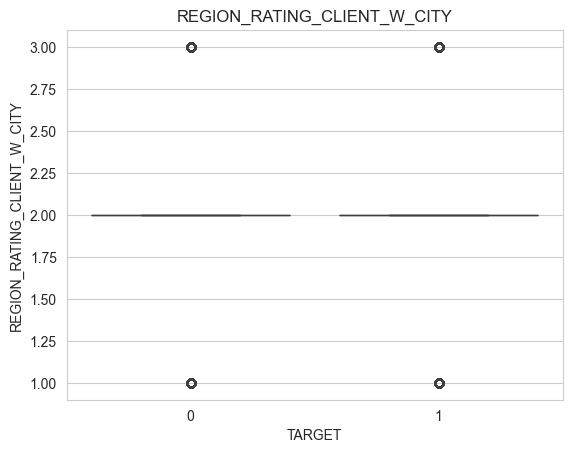

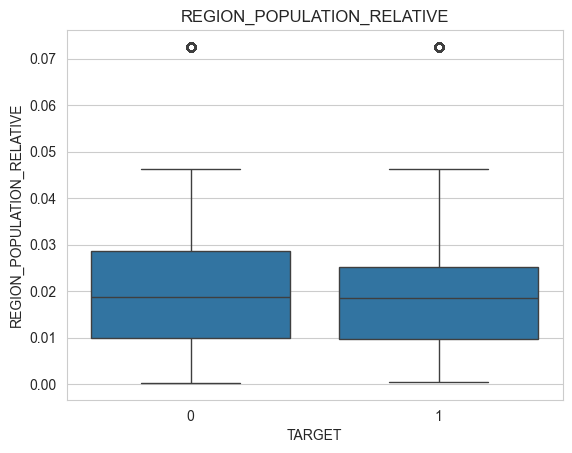

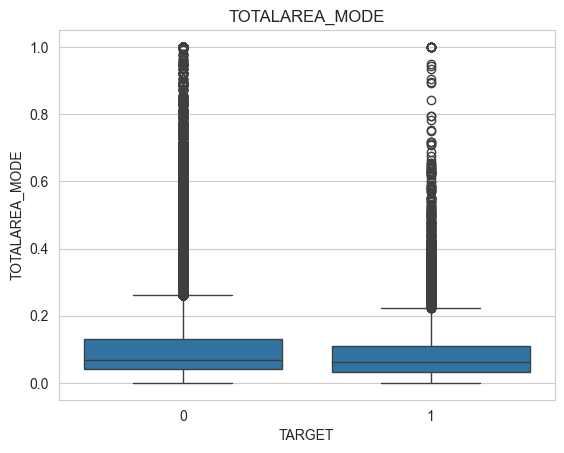

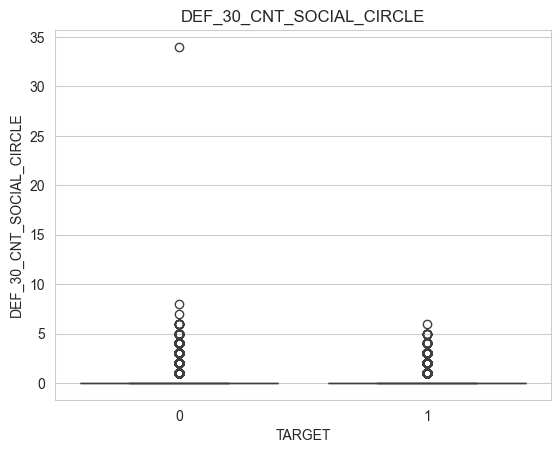

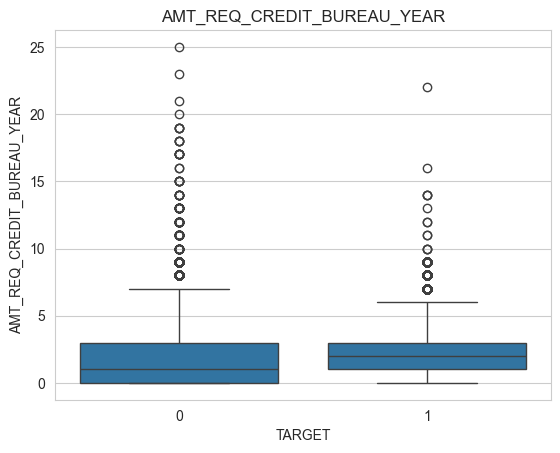

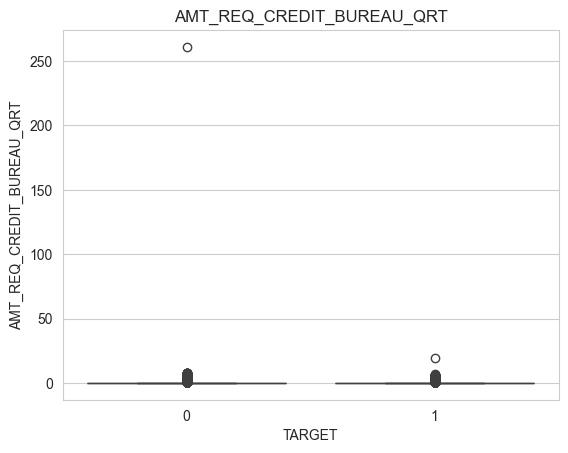

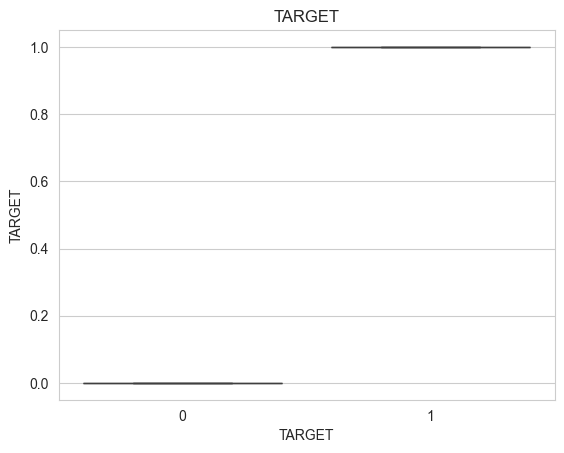

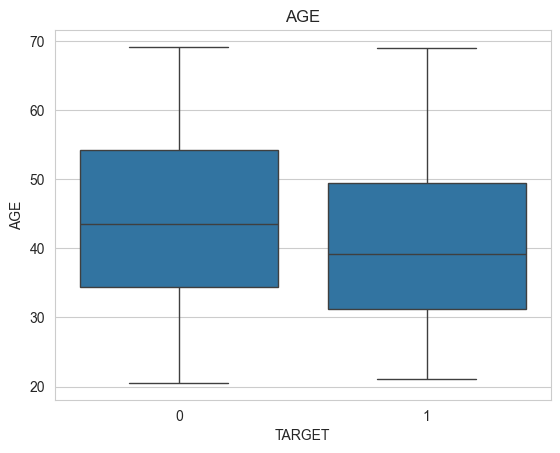

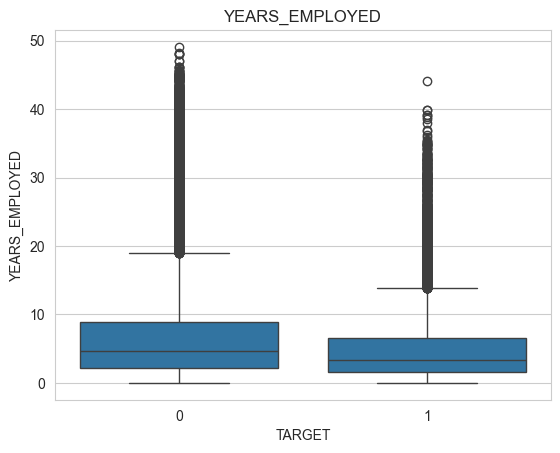

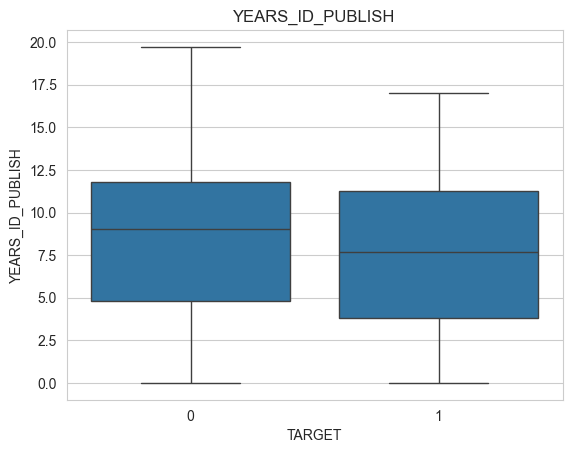

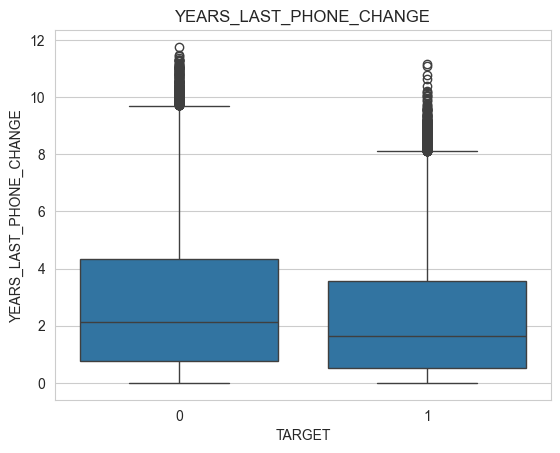

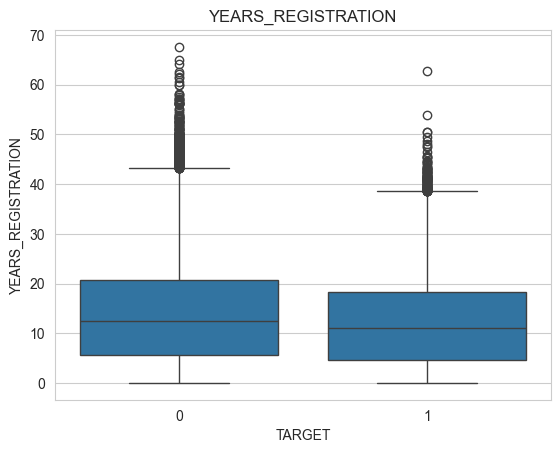

In [30]:
for col in num_cols:
    sns.boxplot(data=train_reduced, x="TARGET", y=col)
    plt.title(col)
    plt.show()


    * based on amt_cridet column the loan amount itself is not what drives default risk.
    * based on amt_goods_price the price of the purchased item will not drive risk.
    * based on amt_annuity the monthly repayment amount alone will not drive rist.
    * region_population_relative--> It is not informative on its own.
    * totalarea_mode --> alone will not be informative but we can use another feature with it to be useful
    * amt_req_credit_bureau_qrt--> the 2 categories here are the same so it will not influence 

* ext_source_3 --> people with high score will not default 
* ext_source_2 --> people with high score will not default 
* ext_source_1 --> people with high score will not default 
* own_car_age--> people with old cars tend to not pay the money
* amt_req_credit_bureau_yaer --> Clients who default tend to have more frequent credit bureau inquiries
* age--> Young clients default more than old people 
* years_employed --> fresh people at work tend to default 
* years_id_publish --> people who changes their id alot tend to default 
* years_last_phone_change --> people who change their phone number tend to default 

In [16]:
train_reduced.columns

Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'ORGANIZATION_TYPE',
       'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'OCCUPATION_TYPE',
       'OWN_CAR_AGE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'FLAG_DOCUMENT_3',
       'NAME_CONTRACT_TYPE', 'SK_ID_CURR', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_POPULATION_RELATIVE', 'TOTALAREA_MODE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET', 'AGE', 'YEARS_EMPLOYED',
       'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE', 'YEARS_REGISTRATION'],
      dtype='object')

In [17]:
train_reduced['DEF_30_CNT_SOCIAL_CIRCLE'] = train_reduced['DEF_30_CNT_SOCIAL_CIRCLE'].astype('category')
train_reduced['FLAG_DOCUMENT_3'] = train_reduced['FLAG_DOCUMENT_3'].astype('category')
train_reduced['REGION_RATING_CLIENT_W_CITY'] = train_reduced['REGION_RATING_CLIENT_W_CITY'].astype('category')

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\3714917801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced['DEF_30_CNT_SOCIAL_CIRCLE'] = train_reduced['DEF_30_CNT_SOCIAL_CIRCLE'].astype('category')
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\3714917801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced['FLAG_DOCUMENT_3'] = train_reduced['FLAG_DOCUMENT_3'].astype('category')
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\3714917801.py:3: SettingWithCopyWarning: 

In [18]:
train_reduced['DEF_30_CNT_SOCIAL_CIRCLE_CAT'] = pd.cut(
    train_reduced['DEF_30_CNT_SOCIAL_CIRCLE'],
    bins=[-1, 0, 1, 2, float('inf')],
    labels=['0', '1', '2', '3+']
).astype('category')
train_reduced.drop('DEF_30_CNT_SOCIAL_CIRCLE', axis=1, inplace=True)

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\3479525141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced['DEF_30_CNT_SOCIAL_CIRCLE_CAT'] = pd.cut(
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\3479525141.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced.drop('DEF_30_CNT_SOCIAL_CIRCLE', axis=1, inplace=True)


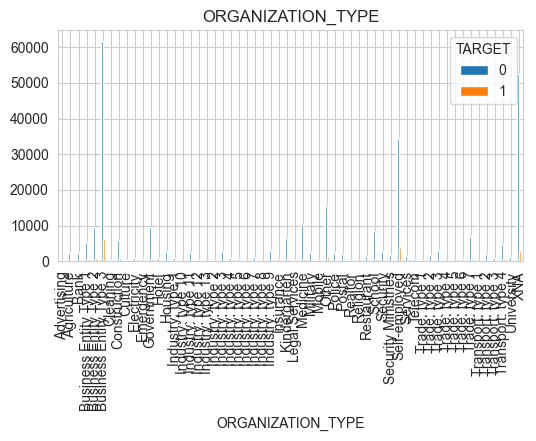

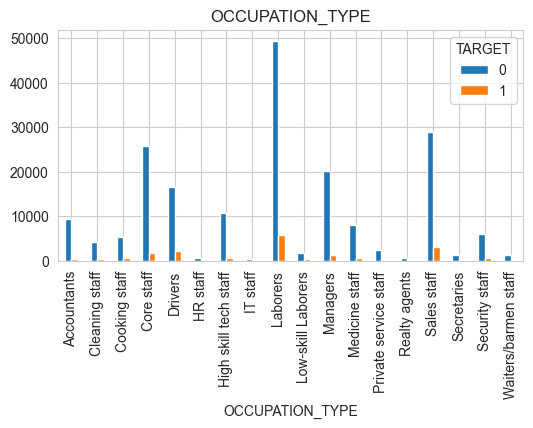

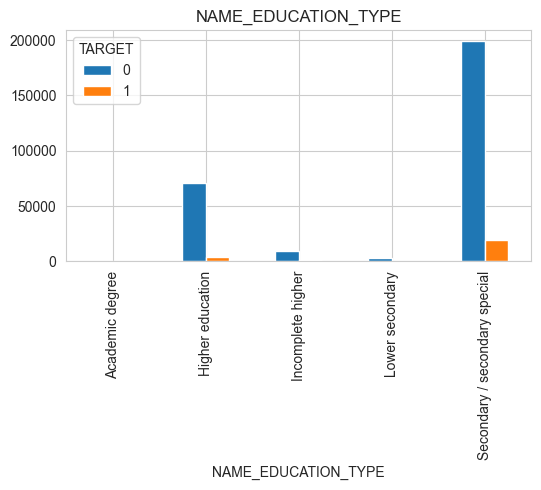

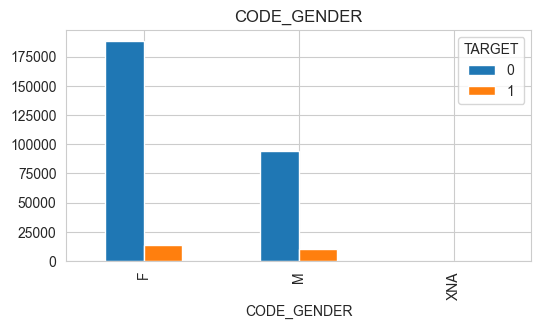

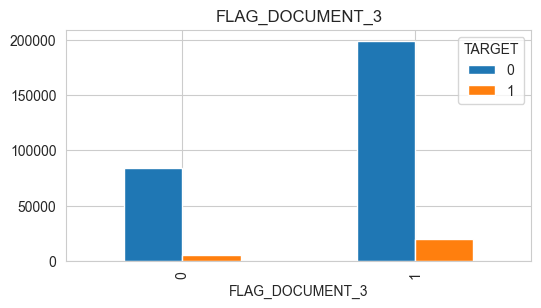

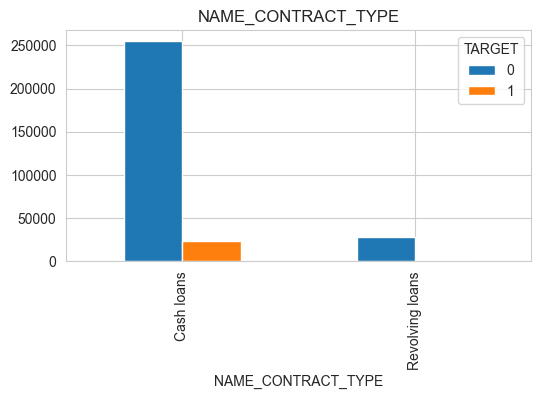

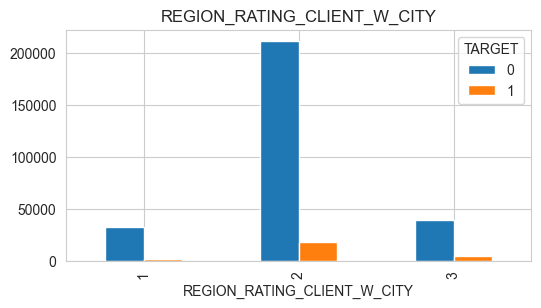

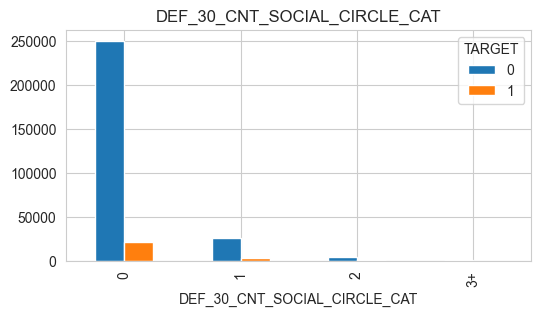

In [99]:
cat_cols = train_reduced.select_dtypes('category')
for col in cat_cols:
    pd.crosstab(train_reduced[col], train_reduced["TARGET"]).plot(kind="bar", figsize=(6,3))
    plt.title(col)
    plt.show()


* for this it not fair to compare the results because there are demonating categories so its not obviouse to take a specific desigion 

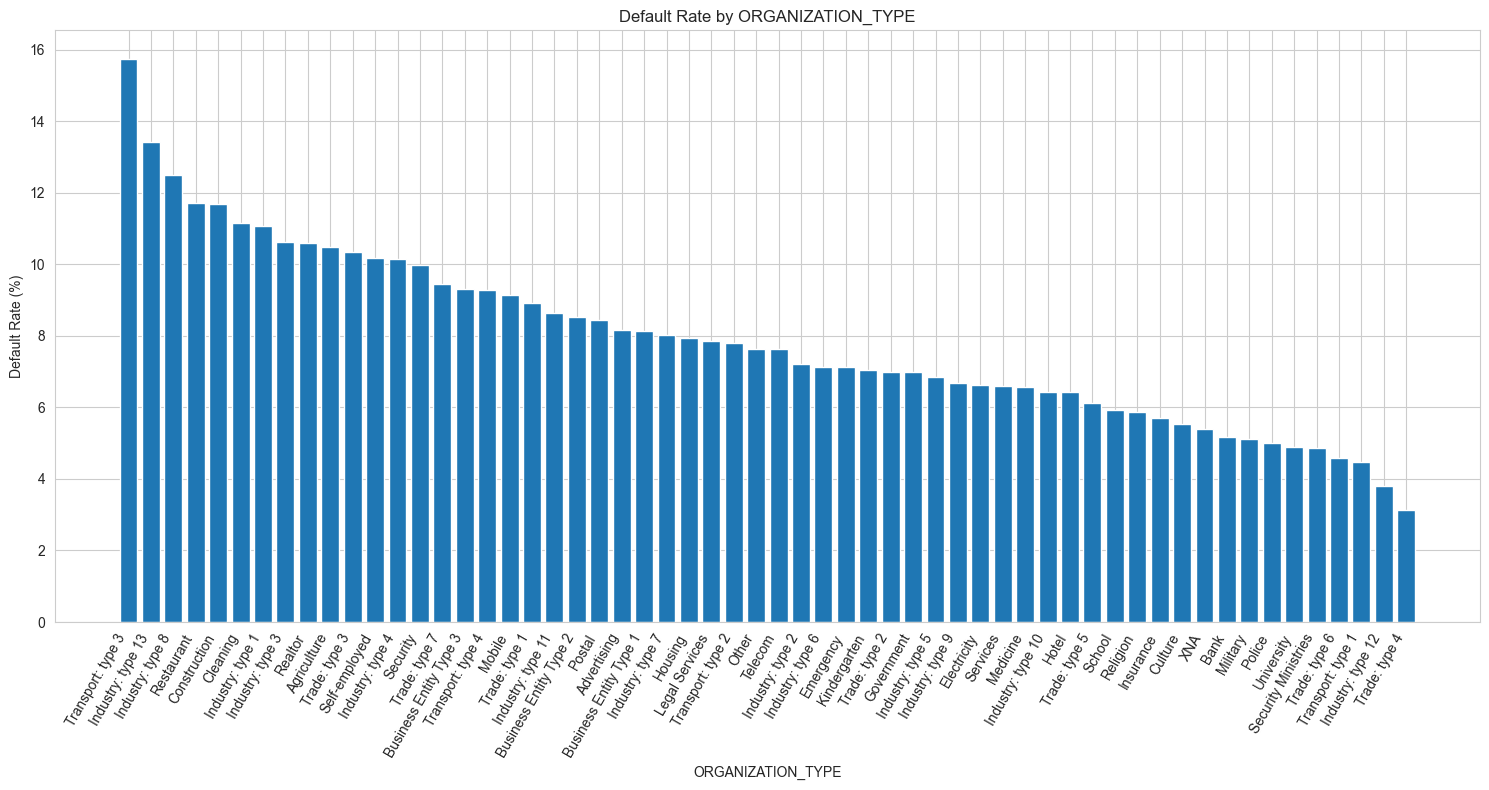

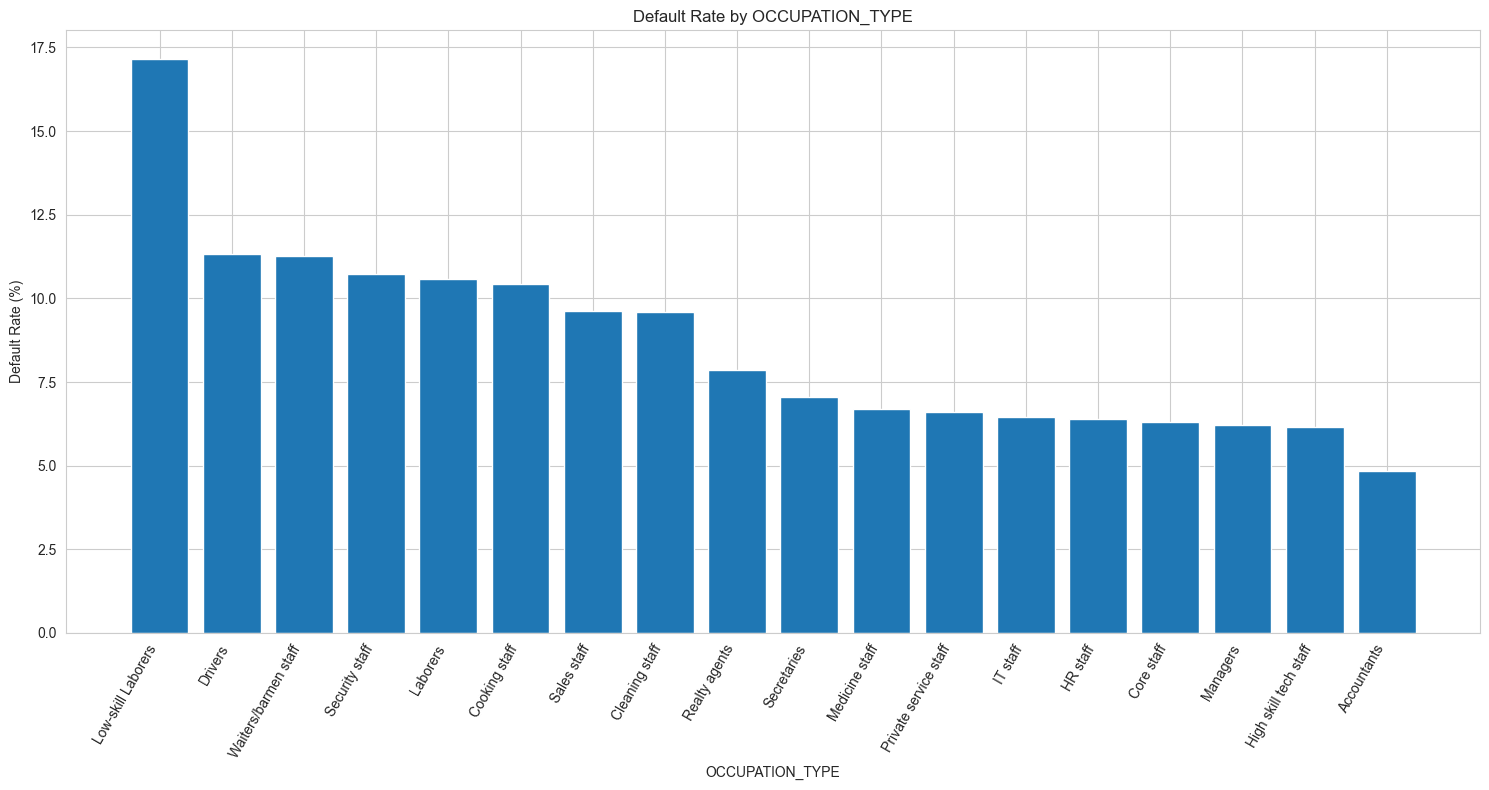

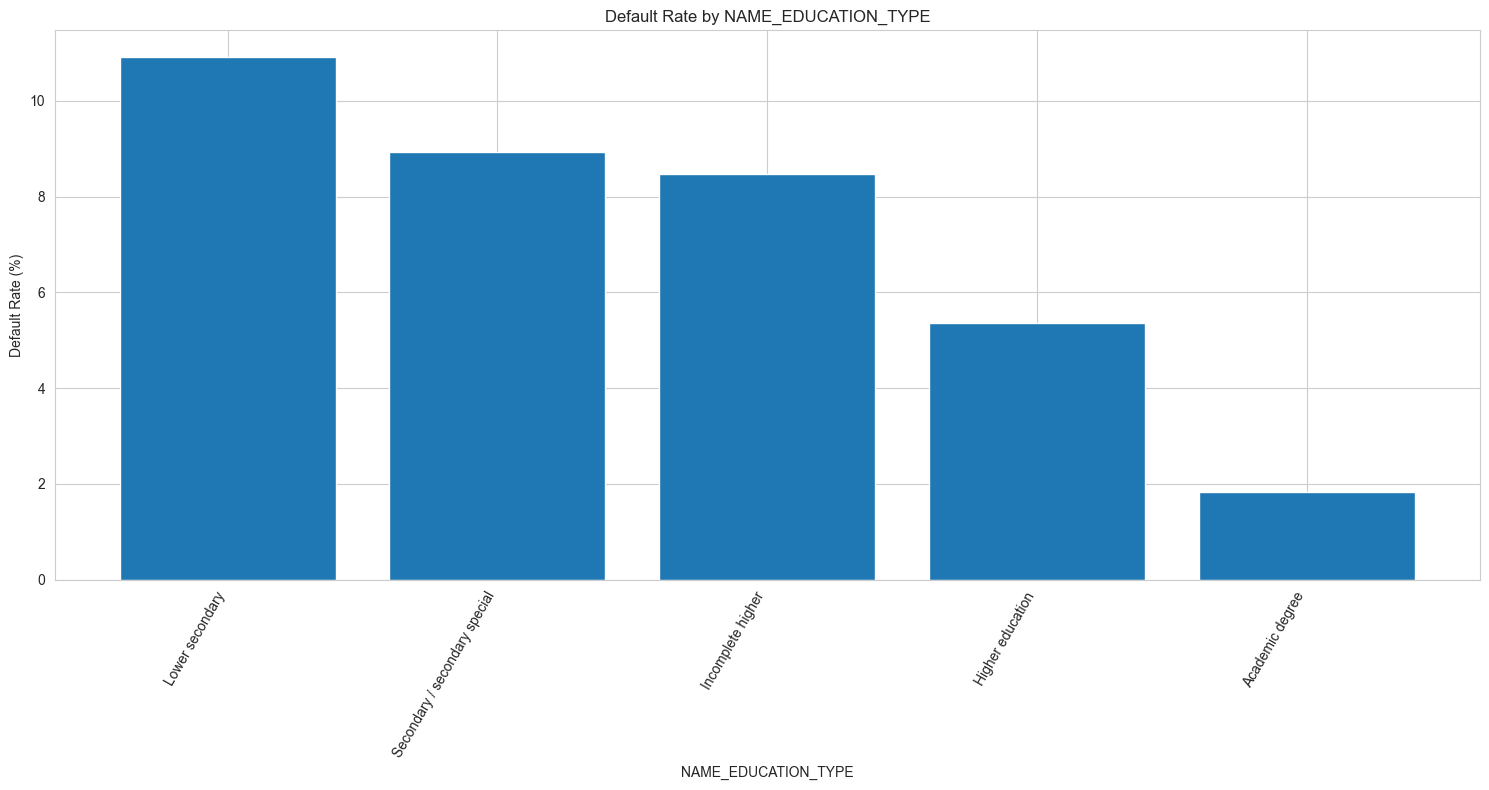

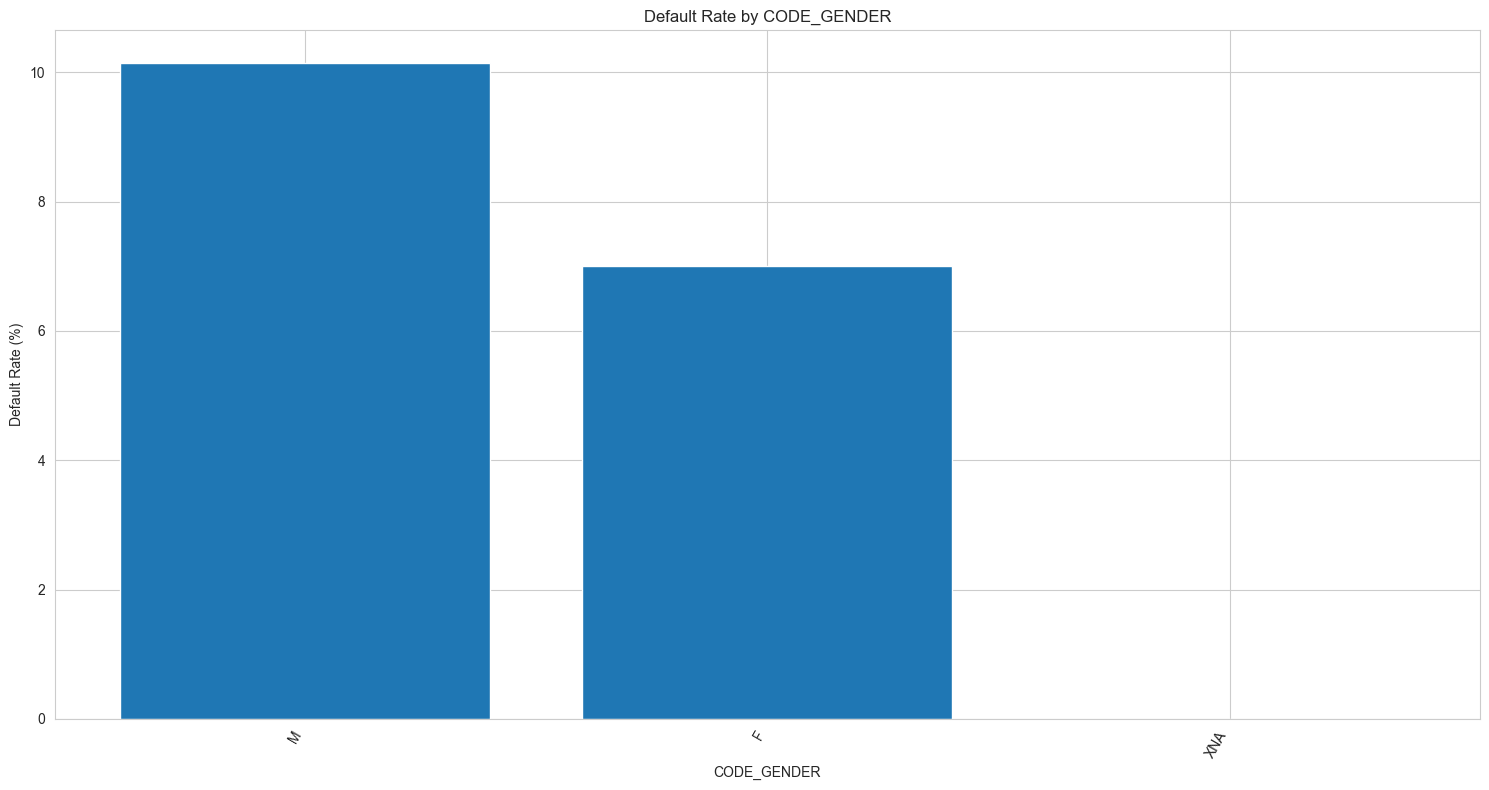

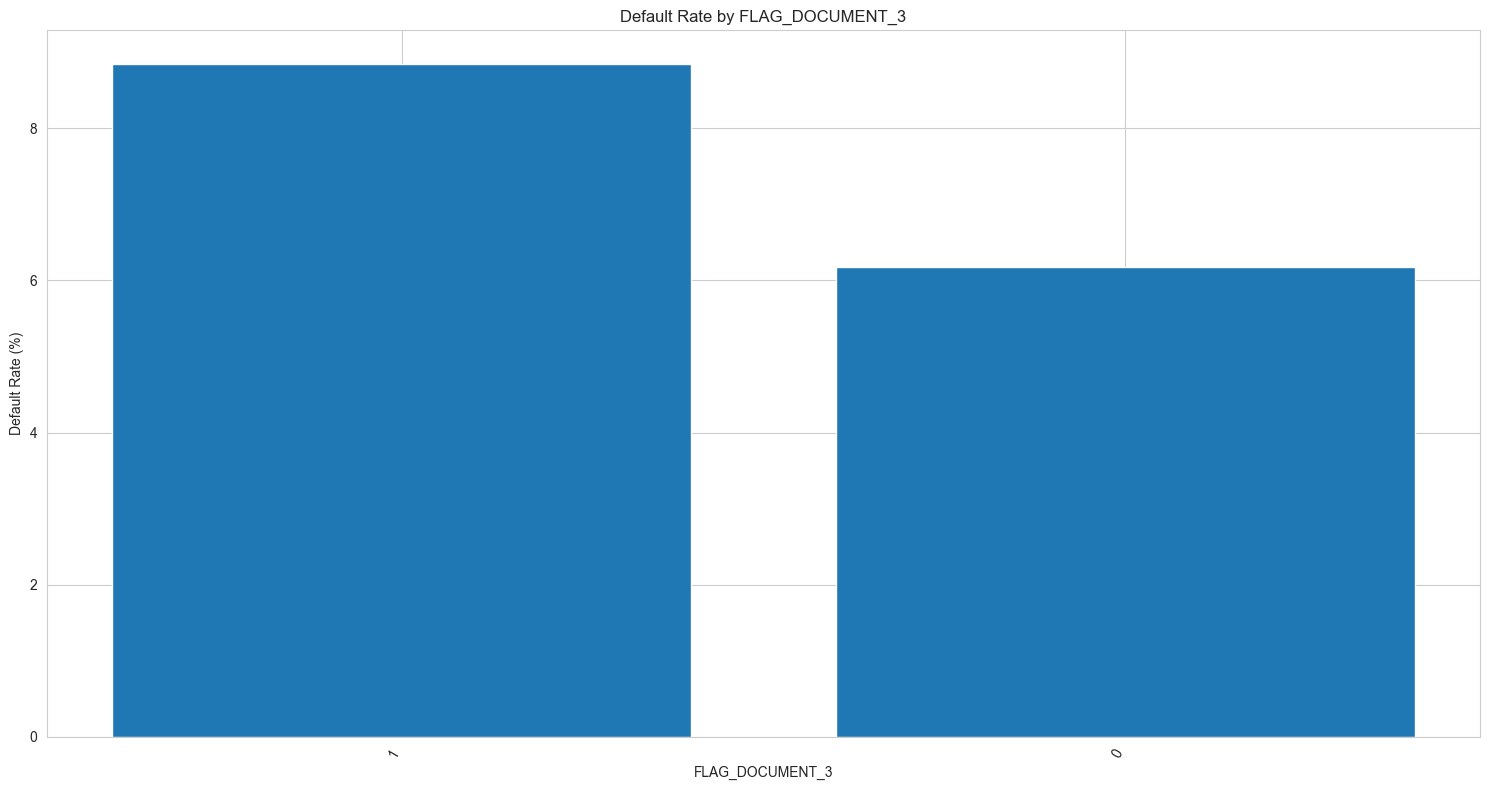

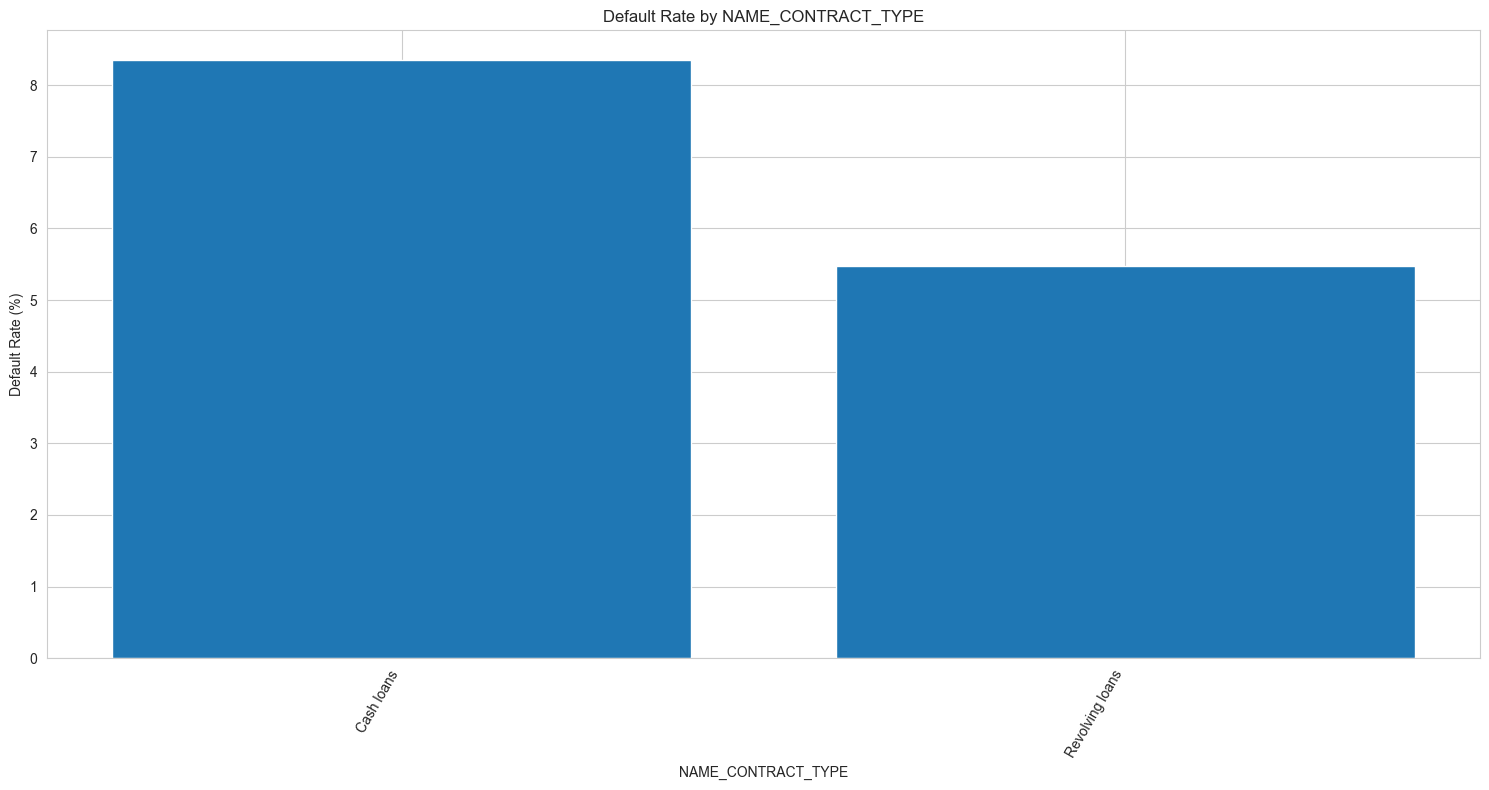

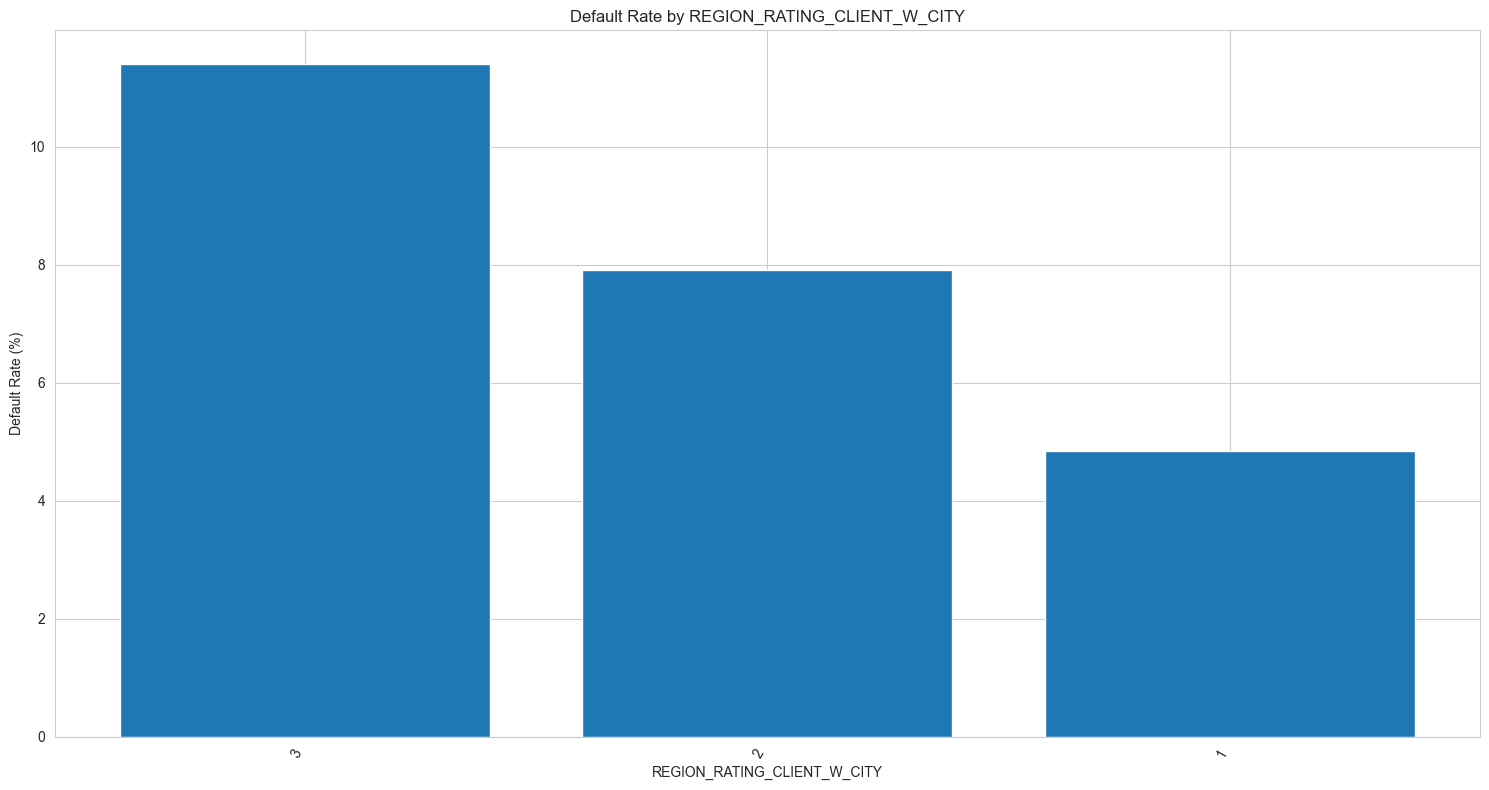

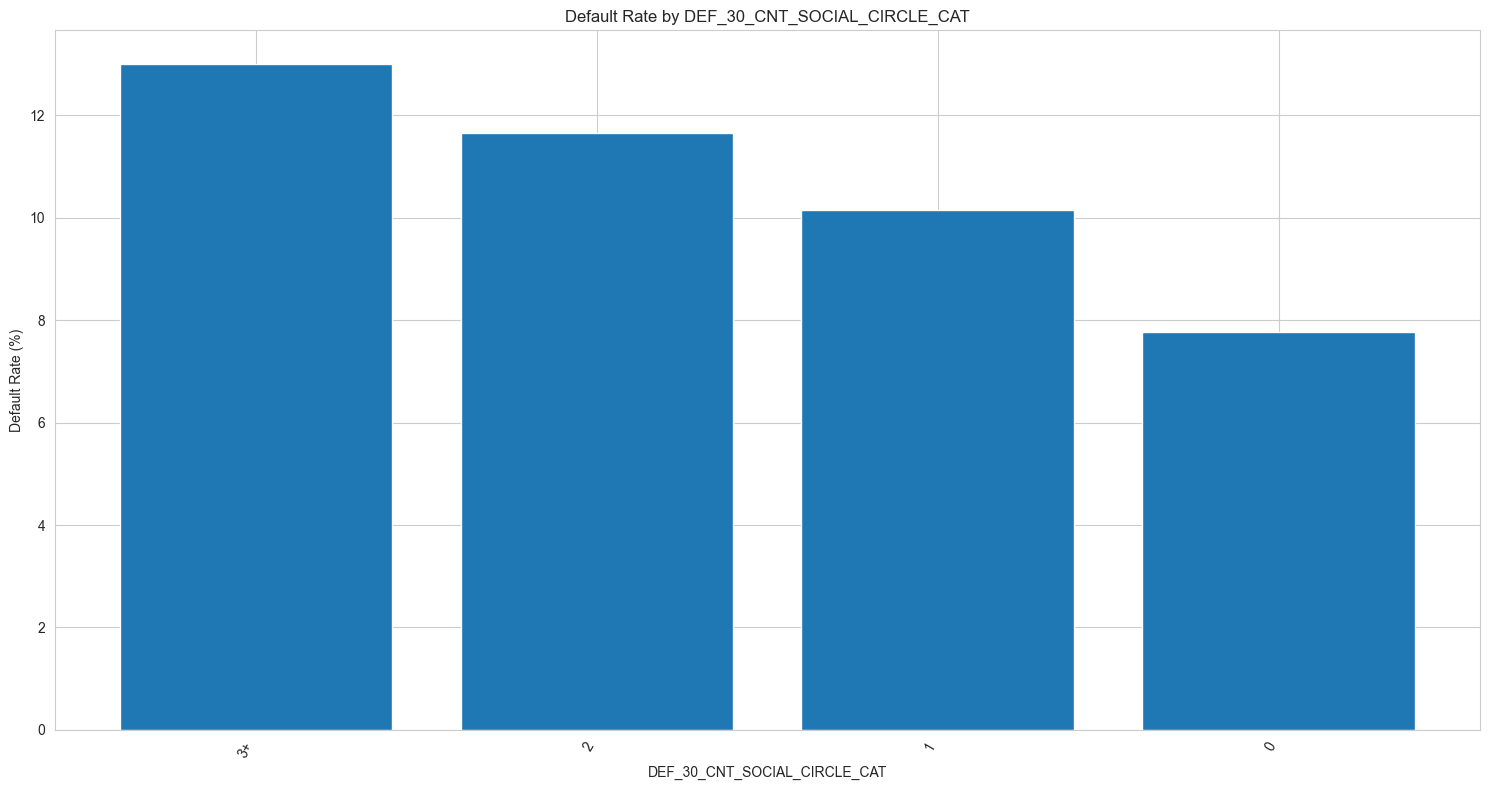

In [51]:
cat_cols = train_reduced.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    default_rate = (
        train_reduced.groupby(col)['TARGET']
        .mean()
        .reset_index()
        .rename(columns={'TARGET': 'default_rate'})
    )
    default_rate = default_rate.sort_values(by='default_rate', ascending=False)
    plt.figure(figsize=(15,8))
    plt.bar(default_rate[col].astype(str), default_rate['default_rate']*100)
    plt.title(f"Default Rate by {col}")
    plt.ylabel("Default Rate (%)")
    plt.xlabel(col)
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()


* Applicants connected to risky social networks are themselves more likely to default.
* Clients in economically weaker or lower rated regions are significantly more likely to default.
* Borrowers who take cash loans are more financially strained / riskier.
* Male default Rate is higher than Female while the number of female is higher than male
* Default rate decreases with higher education (Lower education → lower earning power → higher credit risk.)

* Top-risk occupations:                                             
    * Low-skill Laborers
    * Drivers
    * Waiters/Barmen staff
    * Security staff
    * Laborers
* Lowest-risk occupations:
    * Accountants
    * Managers
    * High skill tech staff
    * Core staff
    * IT staff

* Organizations like(transport, construction, cleaning, trade) show higher default rates, while government, banking, military, and education sectors show lower risk

## now feature engineering and selection part 

In [19]:
train_reduced.columns


Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'ORGANIZATION_TYPE',
       'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'OCCUPATION_TYPE',
       'OWN_CAR_AGE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'FLAG_DOCUMENT_3',
       'NAME_CONTRACT_TYPE', 'SK_ID_CURR', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_POPULATION_RELATIVE', 'TOTALAREA_MODE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET',
       'AGE', 'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE',
       'YEARS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT'],
      dtype='object')

In [20]:
train_reduced["area_per_population"] = train_reduced["TOTALAREA_MODE"] / (train_reduced["REGION_POPULATION_RELATIVE"] + 1)

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\695517725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["area_per_population"] = train_reduced["TOTALAREA_MODE"] / (train_reduced["REGION_POPULATION_RELATIVE"] + 1)


In [21]:
train_reduced["CREDIT_TO_PRICE"]  = train_reduced["AMT_CREDIT"]      / (train_reduced["AMT_GOODS_PRICE"])
train_reduced["ANNUITY_TO_CREDIT"] = train_reduced["AMT_ANNUITY"]    / (train_reduced["AMT_CREDIT"])
train_reduced["ANNUITY_TO_PRICE"]  = train_reduced["AMT_ANNUITY"]    / (train_reduced["AMT_GOODS_PRICE"])

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\2918697546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["CREDIT_TO_PRICE"]  = train_reduced["AMT_CREDIT"]      / (train_reduced["AMT_GOODS_PRICE"])
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\2918697546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["ANNUITY_TO_CREDIT"] = train_reduced["AMT_ANNUITY"]    / (train_reduced["AMT_CREDIT"])
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\2918697546.py:3: SettingWi

* we are trying to find relationship among the previous features because as we saw before in the EDA process it the relationship between them and target was so week so try to drive other features and then we will train our base model to see it improves the result or not 

In [22]:
exts = [c for c in ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"] if c in train_reduced.columns]
train_reduced["EXT_MEAN"]  = train_reduced[exts].mean(axis=1, skipna=True)
train_reduced["EXT_MIN"]   = train_reduced[exts].min(axis=1, skipna=True)
train_reduced["EXT_MAX"]   = train_reduced[exts].max(axis=1, skipna=True)
train_reduced["EXT_STD"]   = train_reduced[exts].std(axis=1, ddof=0, skipna=True)
train_reduced["EXT_NA_CNT"] = train_reduced[exts].isna().sum(axis=1)

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\652633552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["EXT_MEAN"]  = train_reduced[exts].mean(axis=1, skipna=True)
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\652633552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["EXT_MIN"]   = train_reduced[exts].min(axis=1, skipna=True)
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\652633552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

* in the above cell we know that ext_soursces are very important features so we try to connect them together to help the model to find relationships beween them which helps to imporve the performace 

In [23]:
train_reduced.columns


Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'ORGANIZATION_TYPE',
       'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'OCCUPATION_TYPE',
       'OWN_CAR_AGE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'FLAG_DOCUMENT_3',
       'NAME_CONTRACT_TYPE', 'SK_ID_CURR', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_POPULATION_RELATIVE', 'TOTALAREA_MODE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET',
       'AGE', 'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE',
       'YEARS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT',
       'area_per_population', 'CREDIT_TO_PRICE', 'ANNUITY_TO_CREDIT',
       'ANNUITY_TO_PRICE', 'EXT_MEAN', 'EXT_MIN', 'EXT_MAX', 'EXT_STD',
       'EXT_NA_CNT'],
      dtype='object')

In [24]:
# normalize car age with the person age 
train_reduced["CAR_AGE_TO_AGE"] = train_reduced["OWN_CAR_AGE"] / train_reduced["AGE"]

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\768742100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["CAR_AGE_TO_AGE"] = train_reduced["OWN_CAR_AGE"] / train_reduced["AGE"]


In [25]:
# "stability" summary from several year counters
yrs_cols = [c for c in ["YEARS_EMPLOYED","YEARS_REGISTRATION","YEARS_ID_PUBLISH","YEARS_LAST_PHONE_CHANGE"] if c in train_reduced.columns]
train_reduced["YEARS_MIN"]  = train_reduced[yrs_cols].min(axis=1, skipna=True)
train_reduced["YEARS_MAX"]  = train_reduced[yrs_cols].max(axis=1, skipna=True)
train_reduced["YEARS_MEAN"] = train_reduced[yrs_cols].mean(axis=1, skipna=True)
train_reduced["YEARS_STD"]  = train_reduced[yrs_cols].std(axis=1, ddof=0, skipna=True)

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\1989388422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["YEARS_MIN"]  = train_reduced[yrs_cols].min(axis=1, skipna=True)
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\1989388422.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["YEARS_MAX"]  = train_reduced[yrs_cols].max(axis=1, skipna=True)
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\1989388422.py:5: SettingWithCopyWarning: 
A value is trying to be set on a 

* as we did in ext_source we are doing it with the ages group

In [26]:
# convert year & quarter counts into monthly rates to compare between them because it will not be fair to compare between values on a year and on 3 months 
train_reduced["REQ_YEAR_PER_MON"] = train_reduced["AMT_REQ_CREDIT_BUREAU_YEAR"] / 12.0
train_reduced["REQ_QRT_PER_MON"]  = train_reduced["AMT_REQ_CREDIT_BUREAU_QRT"]  / 3.0
train_reduced["REQ_TOTAL_PER_MON"] = train_reduced[["REQ_YEAR_PER_MON","REQ_QRT_PER_MON"]].sum(axis=1, skipna=True)
cutoff = train_reduced["REQ_TOTAL_PER_MON"].quantile(0.9)
train_reduced["REQ_HIGH_90P"] = (train_reduced["REQ_TOTAL_PER_MON"] >= cutoff).astype("Int8")


C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\1579175330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["REQ_YEAR_PER_MON"] = train_reduced["AMT_REQ_CREDIT_BUREAU_YEAR"] / 12.0
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\1579175330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["REQ_QRT_PER_MON"]  = train_reduced["AMT_REQ_CREDIT_BUREAU_QRT"]  / 3.0
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\1579175330.py:4: SettingWithCopyWarning: 
A value is trying 

In [27]:
# inverse population (proxy for rurality); cap for stability
train_reduced["REGION_INVERSE_POP"] = 1.0 / (train_reduced["REGION_POPULATION_RELATIVE"].replace(0, np.nan))
train_reduced["REGION_INVERSE_POP"] = train_reduced["REGION_INVERSE_POP"].clip(upper=train_reduced["REGION_INVERSE_POP"].quantile(0.99))
train_reduced["REGION_POP_BUCKET"] = pd.qcut(train_reduced["REGION_POPULATION_RELATIVE"], q=5, duplicates="drop").astype(str)
train_reduced["AREA_PER_POP"] = train_reduced["TOTALAREA_MODE"] / (train_reduced["REGION_POPULATION_RELATIVE"])
train_reduced["AREA_MISS"] = train_reduced["TOTALAREA_MODE"].isna().astype("Int8")


C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\3381170974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["REGION_INVERSE_POP"] = 1.0 / (train_reduced["REGION_POPULATION_RELATIVE"].replace(0, np.nan))
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\3381170974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced["REGION_INVERSE_POP"] = train_reduced["REGION_INVERSE_POP"].clip(upper=train_reduced["REGION_INVERSE_POP"].quantile(0.99))
C:\Users\DREAMS\AppData\Local\Temp\ipy

In [28]:
train_reduced.columns

Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'ORGANIZATION_TYPE',
       'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'OCCUPATION_TYPE',
       'OWN_CAR_AGE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'FLAG_DOCUMENT_3',
       'NAME_CONTRACT_TYPE', 'SK_ID_CURR', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_POPULATION_RELATIVE', 'TOTALAREA_MODE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET',
       'AGE', 'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE',
       'YEARS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT',
       'area_per_population', 'CREDIT_TO_PRICE', 'ANNUITY_TO_CREDIT',
       'ANNUITY_TO_PRICE', 'EXT_MEAN', 'EXT_MIN', 'EXT_MAX', 'EXT_STD',
       'EXT_NA_CNT', 'CAR_AGE_TO_AGE', 'YEARS_MIN', 'YEARS_MAX', 'YEARS_MEAN',
       'YEARS_STD', 'REQ_YEAR_PER_MON', 'REQ_QRT_PER_MON', 'REQ_TOTAL_PER_MON',
       'REQ_HIGH_90P', 'REGION_INVERSE_POP', 'REGION_POP_BUCKET',
       'AREA_PER_POP', 'AREA_MISS'],
      dtype='object')

In [29]:
categorical_columns = train_reduced.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    train_reduced[col] = train_reduced[col].astype('category')

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_12692\843059762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduced[col] = train_reduced[col].astype('category')


* now we will see if this help the model to improve the score or not 

In [31]:
# using baseline model with all features 
X = train_reduced.drop(['TARGET'], axis=1)
y = train_reduced['TARGET']
model_full = LGBMClassifier(random_state=42)

scores_full = cross_val_score(
    model_full,
    X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("Baseline AUC:", scores_full.mean())


Baseline AUC: 0.7604146509627636


*BAAAAM it helps the model to do better work 

In [37]:
new_model = LGBMClassifier(random_state=42)
new_model.fit(X,y)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7295
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


LGBMClassifier(random_state=42)

In [38]:
booster = new_model.booster_
importance_gain = booster.feature_importance(importance_type='gain')

imp_df_gain = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance_gain': importance_gain
}).sort_values(by='importance_gain', ascending=False)
features =imp_df_gain['feature']

In [40]:
imp_df_gain

feature  importance_gain
29                      EXT_MEAN     71999.207548
27             ANNUITY_TO_CREDIT     11003.579768
3              ORGANIZATION_TYPE      9775.042884
0                   EXT_SOURCE_3      5971.856365
26               CREDIT_TO_PRICE      4957.064924
20                YEARS_EMPLOYED      3990.030075
30                       EXT_MIN      3925.336730
2                   EXT_SOURCE_1      3333.601407
19                           AGE      3267.637496
6                    AMT_ANNUITY      2901.517851
28              ANNUITY_TO_PRICE      2749.823413
7                OCCUPATION_TYPE      2375.317068
9            NAME_EDUCATION_TYPE      2029.455866
5                AMT_GOODS_PRICE      1987.068321
31                       EXT_MAX      1927.119688
10                   CODE_GENDER      1711.104367
21              YEARS_ID_PUBLISH      1672.582773
8                    OWN_CAR_AGE      1578.990639
4                     AMT_CREDIT      1527.417535
32                       EXT_STD      1421.520488
37                    YEARS_MEAN      1317.713780
34                CAR_AGE_TO_AGE      1307.038099
1                   EXT_SOURCE_2      1087.134913
22       YEARS_LAST_PHONE_CHANGE       955.340592
24  DEF_30_CNT_SOCIAL_CIRCLE_CAT       947.658011
16                TOTALAREA_MODE       944.637105
13                    SK_ID_CURR       924.714816
14   REGION_RATING_CLIENT_W_CITY       873.060884
45                  AREA_PER_POP       855.154462
11               FLAG_DOCUMENT_3       807.993577
15    REGION_POPULATION_RELATIVE       757.981309
23            YEARS_REGISTRATION       736.210810
35                     YEARS_MIN       684.737398
18     AMT_REQ_CREDIT_BUREAU_QRT       682.730228
17    AMT_REQ_CREDIT_BUREAU_YEAR       540.635541
36                     YEARS_MAX       465.160578
33                    EXT_NA_CNT       417.640503
25           area_per_population       412.106501
12            NAME_CONTRACT_TYPE       404.504296
38                     YEARS_STD       349.356737
44             REGION_POP_BUCKET       153.728601
41             REQ_TOTAL_PER_MON       145.920880
43            REGION_INVERSE_POP        20.474400
42                  REQ_HIGH_90P         0.000000
40               REQ_QRT_PER_MON         0.000000
39              REQ_YEAR_PER_MON         0.000000
46                     AREA_MISS         0.000000

* the final choice for features because they are increased alot so we need to select the most important

In [309]:
imp_df_gain.reset_index()

index                                            feature  importance_gain
0       0                                           EXT_MEAN     71964.556355
1       2                                  ORGANIZATION_TYPE     10126.604279
2       1                                  ANNUITY_TO_CREDIT      9213.348796
3       4                                    CREDIT_TO_PRICE      5133.330667
4      42                                       DEBT_RATIO_x      4485.303503
..    ...                                                ...              ...
78     76     CREDIT_TYPE_Loan_for_the_purchase_of_equipment         0.000000
79     75  CREDIT_TYPE_Loan_for_purchase_of_shares_(margi...         0.000000
80     79                   CREDIT_TYPE_Mobile_operator_loan         0.000000
81     81                       CREDIT_TYPE_Real_estate_loan         0.000000
82     82                   CREDIT_TYPE_Unknown_type_of_loan         0.000000

[83 rows x 3 columns]

In [235]:
# selecting features to be work on 
selected_features =imp_df_gain.head(30)['feature'].to_list()
selected_features.append('SK_ID_CURR')

In [344]:
selected_features = ['EXT_MEAN', 'ANNUITY_TO_CREDIT', 'ORGANIZATION_TYPE', 'EXT_SOURCE_3',
       'CREDIT_TO_PRICE', 'YEARS_EMPLOYED', 'EXT_MIN', 'EXT_SOURCE_1', 'AGE',
       'AMT_ANNUITY', 'ANNUITY_TO_PRICE', 'OCCUPATION_TYPE',
       'NAME_EDUCATION_TYPE', 'AMT_GOODS_PRICE', 'EXT_MAX', 'CODE_GENDER',
       'YEARS_ID_PUBLISH', 'OWN_CAR_AGE', 'AMT_CREDIT', 'EXT_STD',
       'YEARS_MEAN', 'CAR_AGE_TO_AGE', 'EXT_SOURCE_2',
       'YEARS_LAST_PHONE_CHANGE', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT',
       'TOTALAREA_MODE', 'SK_ID_CURR', 'REGION_RATING_CLIENT_W_CITY',
       'AREA_PER_POP', 'FLAG_DOCUMENT_3', 'SK_ID_CURR']

In [345]:
train_reduced_2 = train_reduced[selected_features]
train_reduced_2.columns

Index(['EXT_MEAN', 'ANNUITY_TO_CREDIT', 'ORGANIZATION_TYPE', 'EXT_SOURCE_3',
       'CREDIT_TO_PRICE', 'YEARS_EMPLOYED', 'EXT_MIN', 'EXT_SOURCE_1', 'AGE',
       'AMT_ANNUITY', 'ANNUITY_TO_PRICE', 'OCCUPATION_TYPE',
       'NAME_EDUCATION_TYPE', 'AMT_GOODS_PRICE', 'EXT_MAX', 'CODE_GENDER',
       'YEARS_ID_PUBLISH', 'OWN_CAR_AGE', 'AMT_CREDIT', 'EXT_STD',
       'YEARS_MEAN', 'CAR_AGE_TO_AGE', 'EXT_SOURCE_2',
       'YEARS_LAST_PHONE_CHANGE', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT',
       'TOTALAREA_MODE', 'SK_ID_CURR', 'REGION_RATING_CLIENT_W_CITY',
       'AREA_PER_POP', 'FLAG_DOCUMENT_3', 'SK_ID_CURR'],
      dtype='object')

In [38]:
# using baseline model with all features 
X = train_reduced_2
y = train_reduced['TARGET']
model_full_2 = LGBMClassifier(random_state=42)

scores_full_2 = cross_val_score(
    model_full_2,
    X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("Baseline AUC:", scores_full_2.mean())

Baseline AUC: 0.7596301082237655


In [39]:
# create a set of number of features and the model will train each model with different number of feature
features = [5]
for i in range(23):
    new_item = features[i] + 5
    features.append(new_item)

In [40]:
# training the model with different number of features to show the model
models_results = {}
for num_features in features:
    top_features = imp_df_gain.head(num_features)['feature'].tolist()
    X_top = train_reduced[top_features]
    model_top = LGBMClassifier(random_state=42)
    scores_top = cross_val_score(
    model_top,
    X_top, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
    )
    models_results[num_features] = scores_top.mean()


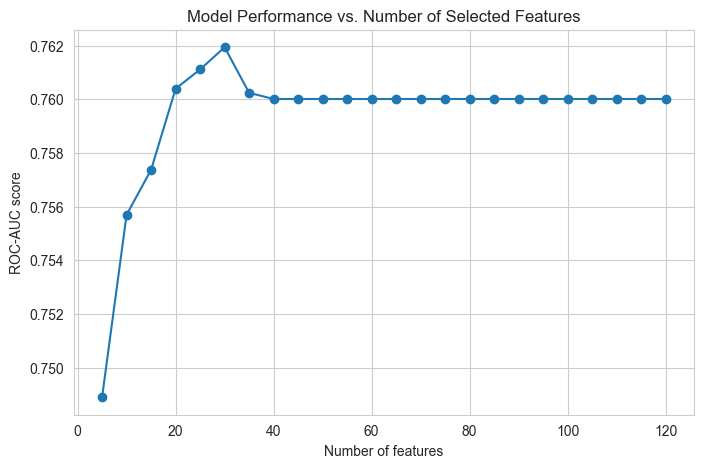

In [41]:
import matplotlib.pyplot as plt
# Extract x and y values
x = list(models_results.keys())
y = [float(v) for v in models_results.values()]  # ensure standard floats
# Plot
plt.figure(figsize=(8,5))
plt.plot(x, y, marker='o')
plt.xlabel("Number of features")
plt.ylabel("ROC-AUC score")
plt.title("Model Performance vs. Number of Selected Features")
plt.grid(True)
plt.show()


## now we are done from the train file 

## bureau

In [215]:
bureau_copy = bureau.copy()

In [53]:
bureau_balance['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

In [55]:
# aggregating this dataset and merge it with bureau 
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE':['min', 'max', 'count'],
        'STATUS': [
        lambda x: (x == '0').sum(),
        lambda x: (x == 'C').sum(),
        lambda x: (x == 'X').sum(),
        lambda x: (x == '1').sum(),
        lambda x: (x == '2').sum(),
        lambda x: (x == '3').sum(),
        lambda x: (x == '5').sum(),
    ]
    
})
bureau_balance_agg.columns = [
    'MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_COUNT',
    'STATUS_0_COUNT', 'STATUS_C_COUNT', 'STATUS_X_COUNT',
    'STATUS_1_COUNT', 'STATUS_2_COUNT', 'STATUS_3_COUNT', 'STATUS_5_COUNT'
]

In [346]:
bureau_balance_agg.reset_index()

SK_ID_BUREAU  MONTHS_BALANCE_MIN  MONTHS_BALANCE_MAX  \
0            5001709                 -96                   0   
1            5001710                 -82                   0   
2            5001711                  -3                   0   
3            5001712                 -18                   0   
4            5001713                 -21                   0   
...              ...                 ...                 ...   
817390       6842884                 -47                   0   
817391       6842885                 -23                   0   
817392       6842886                 -32                   0   
817393       6842887                 -36                   0   
817394       6842888                 -61                   0   

        MONTHS_BALANCE_COUNT  STATUS_0_COUNT  STATUS_C_COUNT  STATUS_X_COUNT  \
0                         97               0              86              11   
1                         83               5              48              30   
2                          4               3               0               1   
3                         19              10               9               0   
4                         22               0               0              22   
...                      ...             ...             ...             ...   
817390                    48               9              20              19   
817391                    24              12               0               0   
817392                    33               8              25               0   
817393                    37               6              31               0   
817394                    62               9              52               0   

        STATUS_1_COUNT  STATUS_2_COUNT  STATUS_3_COUNT  STATUS_5_COUNT  
0                    0               0               0               0  
1                    0               0               0               0  
2                    0               0               0               0  
3                    0               0               0               0  
4                    0               0               0               0  
...                ...             ...             ...             ...  
817390               0               0               0               0  
817391               0               0               0              12  
817392               0               0               0               0  
817393               0               0               0               0  
817394               1               0               0               0  

[817395 rows x 11 columns]

In [347]:
bureau_copy = bureau_copy.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')

In [348]:
nulls_df(bureau_copy).sort_values(by='Nulls_Percentage', ascending=False)

Column  Nulls_Count  Nulls_Percentage         Type
16             AMT_ANNUITY      1226791         71.473490    Numerical
8   AMT_CREDIT_MAX_OVERDUE      1124488         65.513264    Numerical
26          STATUS_1_COUNT       942074         54.885728    Numerical
29          STATUS_5_COUNT       942074         54.885728    Numerical
27          STATUS_2_COUNT       942074         54.885728    Numerical
25          STATUS_X_COUNT       942074         54.885728    Numerical
22    MONTHS_BALANCE_COUNT       942074         54.885728    Numerical
23          STATUS_0_COUNT       942074         54.885728    Numerical
24          STATUS_C_COUNT       942074         54.885728    Numerical
28          STATUS_3_COUNT       942074         54.885728    Numerical
21      MONTHS_BALANCE_MAX       942074         54.885728    Numerical
20      MONTHS_BALANCE_MIN       942074         54.885728    Numerical
7        DAYS_ENDDATE_FACT       633653         36.916958    Numerical
12    AMT_CREDIT_SUM_LIMIT       591780         34.477415    Numerical
11     AMT_CREDIT_SUM_DEBT       257669         15.011932    Numerical
6      DAYS_CREDIT_ENDDATE       105553          6.149573    Numerical
10          AMT_CREDIT_SUM           13          0.000757    Numerical
1             SK_ID_BUREAU            0          0.000000    Numerical
2            CREDIT_ACTIVE            0          0.000000  Categorical
3          CREDIT_CURRENCY            0          0.000000  Categorical
4              DAYS_CREDIT            0          0.000000    Numerical
5       CREDIT_DAY_OVERDUE            0          0.000000    Numerical
13  AMT_CREDIT_SUM_OVERDUE            0          0.000000    Numerical
9       CNT_CREDIT_PROLONG            0          0.000000    Numerical
0               SK_ID_CURR            0          0.000000    Numerical
18             LIMIT_USAGE            0          0.000000    Numerical
14             CREDIT_TYPE            0          0.000000  Categorical
19           OVERDUE_RATIO            0          0.000000    Numerical
15      DAYS_CREDIT_UPDATE            0          0.000000    Numerical
17              DEBT_RATIO            0          0.000000    Numerical

In [353]:
bureau_copy.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'DEBT_RATIO', 'LIMIT_USAGE', 'OVERDUE_RATIO',
       'MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_COUNT',
       'STATUS_0_COUNT', 'STATUS_C_COUNT', 'STATUS_X_COUNT', 'STATUS_1_COUNT',
       'STATUS_2_COUNT', 'STATUS_3_COUNT', 'STATUS_5_COUNT'],
      dtype='object')

In [356]:
num_cols = bureau_copy.select_dtypes(include='number').columns.to_list()
num_cols.remove('SK_ID_CURR'); num_cols.remove('SK_ID_BUREAU')
num_cols

['DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY',
 'DEBT_RATIO',
 'LIMIT_USAGE',
 'OVERDUE_RATIO',
 'MONTHS_BALANCE_MIN',
 'MONTHS_BALANCE_MAX',
 'MONTHS_BALANCE_COUNT',
 'STATUS_0_COUNT',
 'STATUS_C_COUNT',
 'STATUS_X_COUNT',
 'STATUS_1_COUNT',
 'STATUS_2_COUNT',
 'STATUS_3_COUNT',
 'STATUS_5_COUNT']

In [357]:
agg_dict = {col: 'mean' for col in num_cols}
aggregated_bureau = bureau_copy.groupby('SK_ID_CURR').agg(agg_dict).reset_index()

In [358]:
aggregated_bureau

SK_ID_CURR  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
0           100001  -735.000000                 0.0            82.428571   
1           100002  -874.000000                 0.0          -349.000000   
2           100003 -1400.750000                 0.0          -544.500000   
3           100004  -867.000000                 0.0          -488.500000   
4           100005  -190.666667                 0.0           439.333333   
...            ...          ...                 ...                  ...   
305806      456249 -1667.076923                 0.0         -1232.333333   
305807      456250  -862.000000                 0.0          1288.333333   
305808      456253  -867.500000                 0.0           280.500000   
305809      456254 -1104.000000                 0.0          -859.000000   
305810      456255 -1089.454545                 0.0          3231.272727   

        DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0             -825.500000                     NaN            0.000000   
1             -697.500000                1681.029            0.000000   
2            -1097.333333                   0.000            0.000000   
3             -532.500000                   0.000            0.000000   
4             -123.000000                   0.000            0.000000   
...                   ...                     ...                 ...   
305806       -1364.750000                6147.000            0.000000   
305807        -760.000000                   0.000            0.000000   
305808        -794.000000                     NaN            0.000000   
305809        -859.000000                     NaN            0.000000   
305810        -968.333333               12056.481            0.090909   

        AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  ...  \
0         2.076236e+05         85240.928571               0.00000  ...   
1         1.081319e+05         49156.200000            7997.14125  ...   
2         2.543501e+05             0.000000          202500.00000  ...   
3         9.451890e+04             0.000000               0.00000  ...   
4         2.190420e+05        189469.500000               0.00000  ...   
...                ...                  ...                   ...  ...   
305806    2.841430e+05         16307.100000               0.00000  ...   
305807    1.028820e+06        744013.365000           19422.79500  ...   
305808    9.900000e+05        448958.250000               0.00000  ...   
305809    4.500000e+04             0.000000                   NaN  ...   
305810    3.456290e+05        191864.126250               0.00000  ...   

        MONTHS_BALANCE_MIN  MONTHS_BALANCE_MAX  MONTHS_BALANCE_COUNT  \
0               -23.571429            0.000000             24.571429   
1               -28.250000          -15.500000             13.750000   
2                      NaN                 NaN                   NaN   
3                      NaN                 NaN                   NaN   
4                -6.000000            0.000000              7.000000   
...                    ...                 ...                   ...   
305806                 NaN                 NaN                   NaN   
305807          -28.000000            0.000000             29.000000   
305808          -28.250000            0.000000             29.250000   
305809          -36.000000            0.000000             37.000000   
305810          -35.090909           -9.454545             26.636364   

        STATUS_0_COUNT  STATUS_C_COUNT  STATUS_X_COUNT  STATUS_1_COUNT  \
0             4.428571       15.714286        4.285714        0.142857   
1             5.625000        2.875000        1.875000        3.375000   
2                  NaN             NaN             NaN             NaN   
3                  NaN             NaN             NaN             NaN   
4             4.666667        1.666667        0.666667        0.000000   
...                .

In [359]:
aggregated_bureau.describe().T

count           mean            std           min  \
SK_ID_CURR              305811.0  278047.300091  102849.568343  1.000010e+05   
DAYS_CREDIT             305811.0   -1083.802103     558.441124 -2.922000e+03   
CREDIT_DAY_OVERDUE      305811.0       0.965926      24.957209  0.000000e+00   
DAYS_CREDIT_ENDDATE     303226.0     662.420814    3282.359178 -4.187500e+04   
DAYS_ENDDATE_FACT       268155.0    -967.018316     531.158694 -8.376500e+03   
AMT_CREDIT_MAX_OVERDUE  212971.0    5004.933760  285681.900244  0.000000e+00   
CNT_CREDIT_PROLONG      305811.0       0.007010       0.062334  0.000000e+00   
AMT_CREDIT_SUM          305809.0  380739.782262  879286.461085  0.000000e+00   
AMT_CREDIT_SUM_DEBT     297439.0  161634.125335  536767.654508 -1.083615e+06   
AMT_CREDIT_SUM_LIMIT    280503.0    5898.538756   29921.818853 -9.789166e+04   
AMT_CREDIT_SUM_OVERDUE  305811.0      45.950721    4956.640161  0.000000e+00   
DAYS_CREDIT_UPDATE      305811.0    -542.965748     446.427113 -4.189000e+04   
AMT_ANNUITY             118224.0   15608.249223  152401.993036  0.000000e+00   
DEBT_RATIO              305811.0       0.368909      21.028539 -1.241705e+02   
LIMIT_USAGE             305811.0      21.044293    2278.499128 -9.532212e+02   
OVERDUE_RATIO           305811.0       0.000187       0.029584  0.000000e+00   
MONTHS_BALANCE_MIN      134542.0     -34.573140      17.663957 -9.600000e+01   
MONTHS_BALANCE_MAX      134542.0      -5.319916       9.346281 -9.200000e+01   
MONTHS_BALANCE_COUNT    134542.0      30.253224      17.466661  1.000000e+00   
STATUS_0_COUNT          134542.0       9.351876       6.911002  0.000000e+00   
STATUS_C_COUNT          134542.0      14.047435      14.216694  0.000000e+00   
STATUS_X_COUNT          134542.0       6.381404       9.947159  0.000000e+00   
STATUS_1_COUNT          134542.0       0.322768       0.958576  0.000000e+00   
STATUS_2_COUNT          134542.0       0.033240       0.213909  0.000000e+00   
STATUS_3_COUNT          134542.0       0.013680       0.121570  0.000000e+00   
STATUS_5_COUNT          134542.0       0.093624       1.300114  0.000000e+00   

                                  25%            50%            75%  \
SK_ID_CURR              188878.500000  277895.000000  367184.500000   
DAYS_CREDIT              -1431.000000   -1052.500000    -670.369318   
CREDIT_DAY_OVERDUE           0.000000       0.000000       0.000000   
DAYS_CREDIT_ENDDATE       -697.525000    -131.788889     613.000000   
DAYS_ENDDATE_FACT        -1288.591667    -926.400000    -573.666667   
AMT_CREDIT_MAX_OVERDUE       0.000000       0.000000    2063.745000   
CNT_CREDIT_PROLONG           0.000000       0.000000       0.000000   
AMT_CREDIT_SUM          103961.587500  197297.250000  397864.650000   
AMT_CREDIT_SUM_DEBT          0.000000   44760.375000  143600.369318   
AMT_CREDIT_SUM_LIMIT         0.000000       0.000000       0.000000   
AMT_CREDIT_SUM_OVERDUE       0.000000       0.000000       0.000000   
DAYS_CREDIT_UPDATE        -773.696154    -479.300000    -209.000000   
AMT_ANNUITY                702.000000    6516.000000   14843.349519   
DEBT_RATIO                   0.000000       0.145016       0.307580   
LIMIT_USAGE                  0.000000       0.000000       0.000000   
OVERDUE_RATIO                0.000000       0.000000       0.000000   
MONTHS_BALANCE_MIN         -45.500000     -33.545455     -21.666667   
MONTHS_BALANCE_MAX          -8.000000       0.000000       0.000000   
MONTHS_BALANCE_COUNT        17.000000      28.000000      40.888889   
STATUS_0_COUNT               5.000000       8.000000      12.000000   
STATUS_C_COUNT               2.500000      10.555556      21.333333   
STATUS_X_COUNT               0.500000       2.400000       8.250000   
STATUS_1_COUNT               0.000000       0.000000       0.250000   
STATUS_2_COUNT               0.000000       0.000000       0.000000   
STATUS_3_COUNT               0.000000       0.000000       0.000000   
STATUS_5_COUNT      

In [360]:
feature_to_correct = ['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT']
for col in feature_to_correct:
    aggregated_bureau[col] = aggregated_bureau[col].clip(lower=0)

In [361]:
aggregated_bureau['Years_Credit'] = -aggregated_bureau['DAYS_CREDIT']/365
aggregated_bureau['Years_ENDDATE_FACT'] = -aggregated_bureau['DAYS_ENDDATE_FACT']/365
aggregated_bureau['YEARS_CREDIT_UPDATE'] = -aggregated_bureau['DAYS_CREDIT_UPDATE']/365
aggregated_bureau['YEARS_CREDIT_UPDATE'] = aggregated_bureau['YEARS_CREDIT_UPDATE'].clip(lower=0)

In [362]:
aggregated_bureau.describe().T

count           mean            std            min  \
SK_ID_CURR              305811.0  278047.300091  102849.568343  100001.000000   
DAYS_CREDIT             305811.0   -1083.802103     558.441124   -2922.000000   
CREDIT_DAY_OVERDUE      305811.0       0.965926      24.957209       0.000000   
DAYS_CREDIT_ENDDATE     303226.0     662.420814    3282.359178  -41875.000000   
DAYS_ENDDATE_FACT       268155.0    -967.018316     531.158694   -8376.500000   
AMT_CREDIT_MAX_OVERDUE  212971.0    5004.933760  285681.900244       0.000000   
CNT_CREDIT_PROLONG      305811.0       0.007010       0.062334       0.000000   
AMT_CREDIT_SUM          305809.0  380739.782262  879286.461085       0.000000   
AMT_CREDIT_SUM_DEBT     297439.0  161658.650553  536747.515560       0.000000   
AMT_CREDIT_SUM_LIMIT    280503.0    5900.902610   29919.811697       0.000000   
AMT_CREDIT_SUM_OVERDUE  305811.0      45.950721    4956.640161       0.000000   
DAYS_CREDIT_UPDATE      305811.0    -542.965748     446.427113  -41890.000000   
AMT_ANNUITY             118224.0   15608.249223  152401.993036       0.000000   
DEBT_RATIO              305811.0       0.368909      21.028539    -124.170532   
LIMIT_USAGE             305811.0      21.044293    2278.499128    -953.221219   
OVERDUE_RATIO           305811.0       0.000187       0.029584       0.000000   
MONTHS_BALANCE_MIN      134542.0     -34.573140      17.663957     -96.000000   
MONTHS_BALANCE_MAX      134542.0      -5.319916       9.346281     -92.000000   
MONTHS_BALANCE_COUNT    134542.0      30.253224      17.466661       1.000000   
STATUS_0_COUNT          134542.0       9.351876       6.911002       0.000000   
STATUS_C_COUNT          134542.0      14.047435      14.216694       0.000000   
STATUS_X_COUNT          134542.0       6.381404       9.947159       0.000000   
STATUS_1_COUNT          134542.0       0.322768       0.958576       0.000000   
STATUS_2_COUNT          134542.0       0.033240       0.213909       0.000000   
STATUS_3_COUNT          134542.0       0.013680       0.121570       0.000000   
STATUS_5_COUNT          134542.0       0.093624       1.300114       0.000000   
Years_Credit            305811.0       2.969321       1.529976      -0.000000   
Years_ENDDATE_FACT      268155.0       2.649365       1.455229      -0.000000   
YEARS_CREDIT_UPDATE     305811.0       1.487578       1.223088      -0.000000   

                                  25%            50%            75%  \
SK_ID_CURR              188878.500000  277895.000000  367184.500000   
DAYS_CREDIT              -1431.000000   -1052.500000    -670.369318   
CREDIT_DAY_OVERDUE           0.000000       0.000000       0.000000   
DAYS_CREDIT_ENDDATE       -697.525000    -131.788889     613.000000   
DAYS_ENDDATE_FACT        -1288.591667    -926.400000    -573.666667   
AMT_CREDIT_MAX_OVERDUE       0.000000       0.000000    2063.745000   
CNT_CREDIT_PROLONG           0.000000       0.000000       0.000000   
AMT_CREDIT_SUM          103961.587500  197297.250000  397864.650000   
AMT_CREDIT_SUM_DEBT          0.000000   44760.375000  143600.369318   
AMT_CREDIT_SUM_LIMIT         0.000000       0.000000       0.000000   
AMT_CREDIT_SUM_OVERDUE       0.000000       0.000000       0.000000   
DAYS_CREDIT_UPDATE        -773.696154    -479.300000    -209.000000   
AMT_ANNUITY                702.000000    6516.000000   14843.349519   
DEBT_RATIO                   0.000000       0.145016       0.307580   
LIMIT_USAGE                  0.000000       0.000000       0.000000   
OVERDUE_RATIO                0.000000       0.000000       0.000000   
MONTHS_BALANCE_MIN         -45.500000     -33.545455     -21.666667   
MONTHS_BALANCE_MAX          -8.000000       0.000000       0.000000   
MONTHS_BALANCE_COUNT        17.000000      28.000000      40.888889   
STATUS_0_COUNT               5.000000       8.000000      12.000000   
STATUS_C_COUNT               2.500000      10.555556      21.333333   
STATUS_X_COUNT               0.500

<Axes: xlabel='Years_Credit', ylabel='Count'>

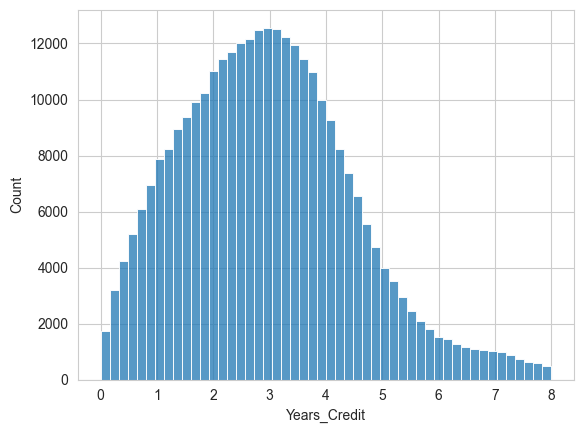

In [296]:
sns.histplot(data=aggregated_bureau, x='Years_Credit', bins=50)

* DAYS_CREDIT --> above 75% of the clients within last 5 years 

<Axes: xlabel='Years_ENDDATE_FACT', ylabel='Count'>

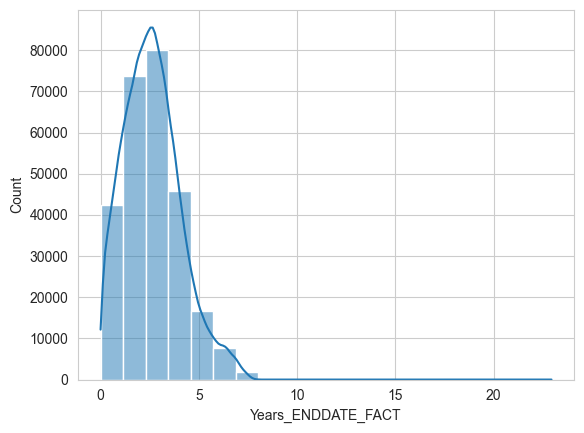

In [93]:
sns.histplot(data=aggregated_bureau, x='Years_ENDDATE_FACT', kde=True, bins=20)

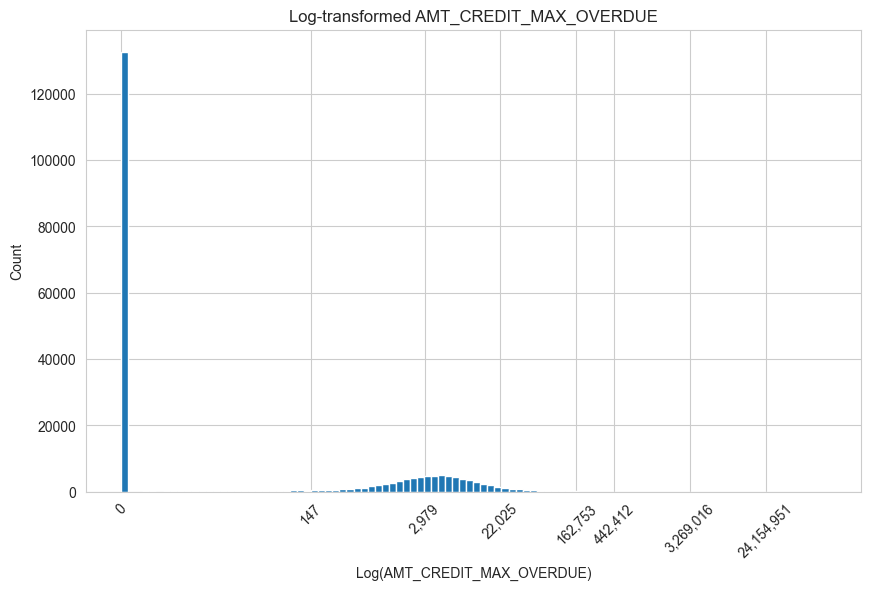

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(aggregated_bureau['AMT_CREDIT_MAX_OVERDUE']), bins=100)
plt.title('Log-transformed AMT_CREDIT_MAX_OVERDUE')
plt.xlabel('Log(AMT_CREDIT_MAX_OVERDUE)')
plt.ylabel('Count')
xticks = [0, 5, 8, 10, 12, 13, 15, 17]
plt.xticks(xticks, [f"{int(np.expm1(x)):,}" for x in xticks], rotation = 45)
plt.show()


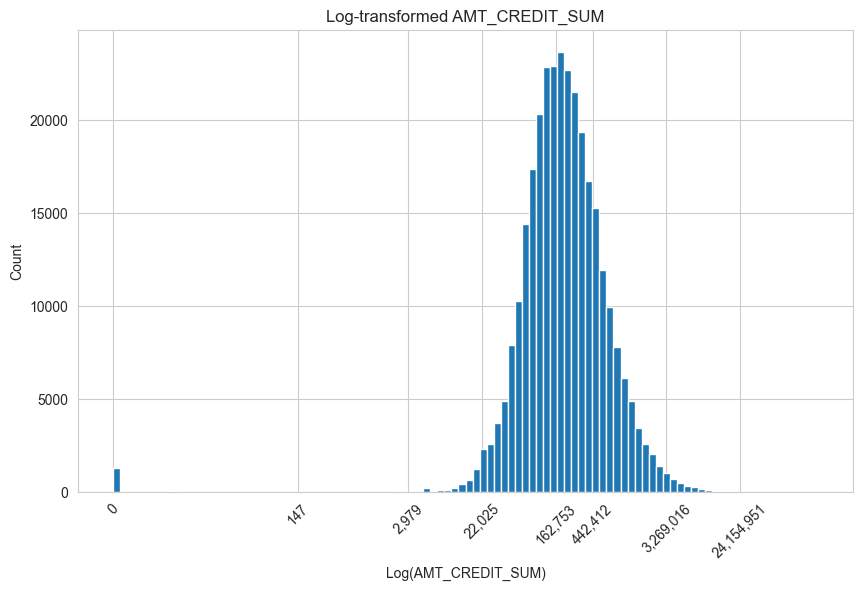

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(aggregated_bureau['AMT_CREDIT_SUM']), bins=100)
plt.title('Log-transformed AMT_CREDIT_SUM')
plt.xlabel('Log(AMT_CREDIT_SUM)')
plt.ylabel('Count')
xticks = [0, 5, 8, 10, 12, 13, 15, 17]
plt.xticks(xticks, [f"{int(np.expm1(x)):,}" for x in xticks], rotation = 45)
plt.show()


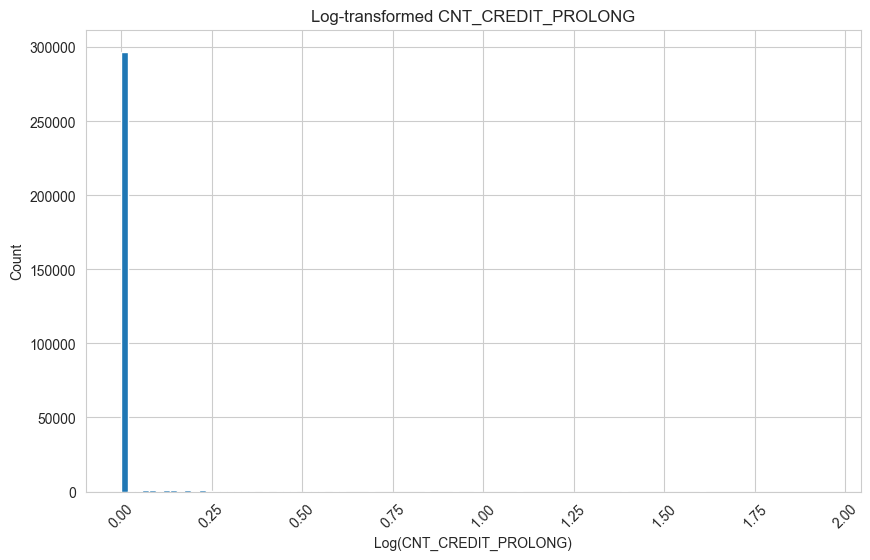

In [216]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(aggregated_bureau['CNT_CREDIT_PROLONG']), bins=100)
plt.title('Log-transformed CNT_CREDIT_PROLONG')
plt.xlabel('Log(CNT_CREDIT_PROLONG)')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

d:\Data Science Projects\Home Credit Default Risk\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


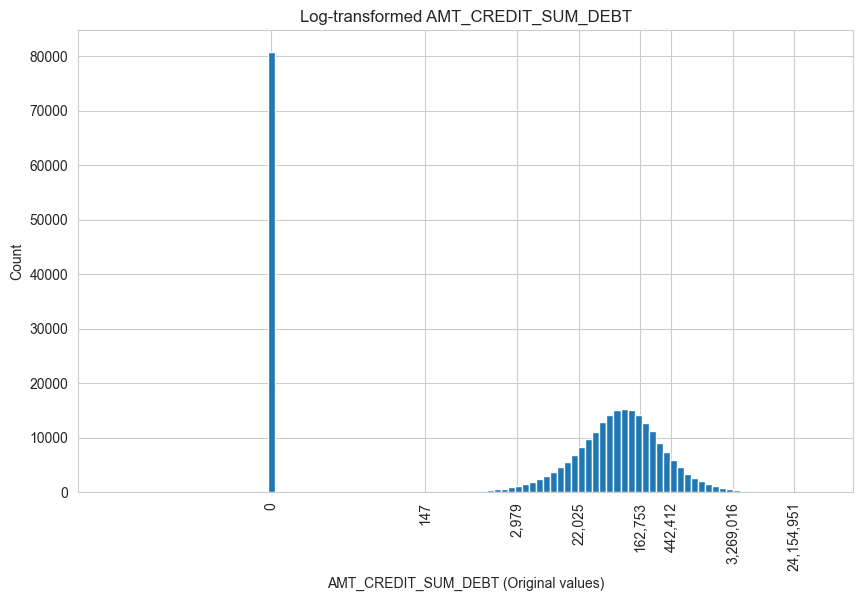

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(aggregated_bureau['AMT_CREDIT_SUM_DEBT']), bins=100)
plt.title('Log-transformed AMT_CREDIT_SUM_DEBT')
xticks = [0, 5, 8, 10, 12, 13, 15, 17]
plt.xticks(xticks, [f"{int(np.expm1(v)):,}" for v in xticks], rotation = 90)
plt.xlabel('AMT_CREDIT_SUM_DEBT (Original values)')
plt.ylabel('Count')
plt.show()

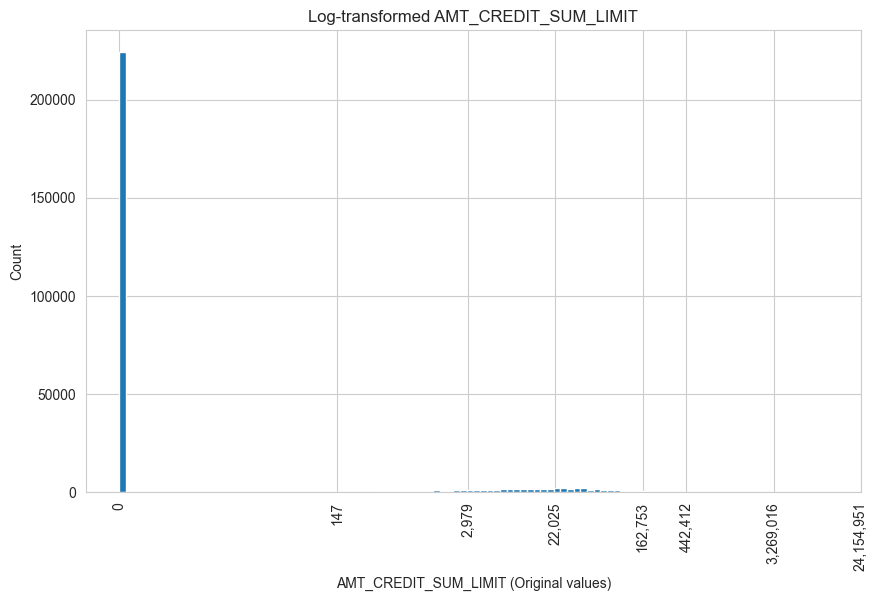

In [120]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(aggregated_bureau['AMT_CREDIT_SUM_LIMIT']), bins=100)
plt.title('Log-transformed AMT_CREDIT_SUM_LIMIT')
xticks = [0, 5, 8, 10, 12, 13, 15, 17]
plt.xticks(xticks, [f"{int(np.expm1(v)):,}" for v in xticks], rotation = 90)
plt.xlabel('AMT_CREDIT_SUM_LIMIT (Original values)')
plt.ylabel('Count')
plt.show()

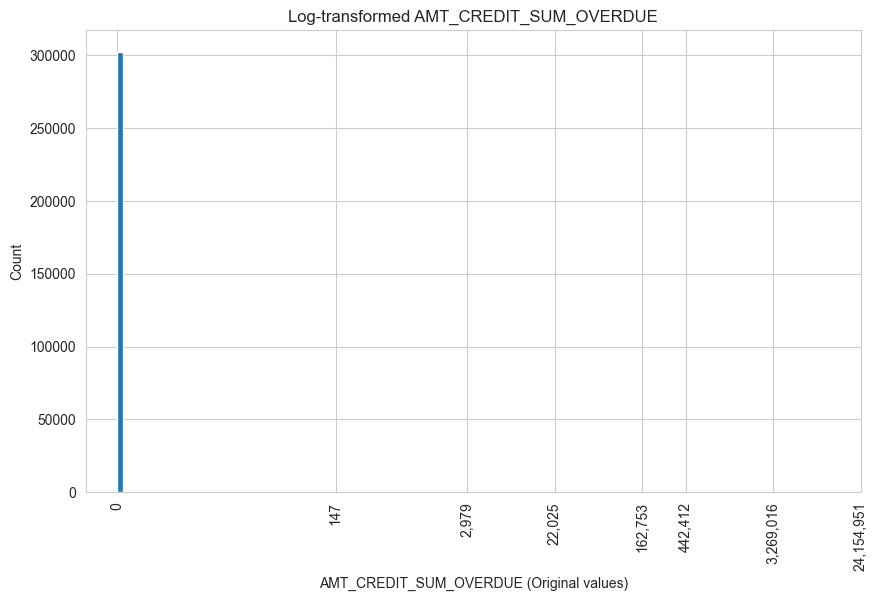

In [121]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(aggregated_bureau['AMT_CREDIT_SUM_OVERDUE']), bins=100)
plt.title('Log-transformed AMT_CREDIT_SUM_OVERDUE')
xticks = [0, 5, 8, 10, 12, 13, 15, 17]
plt.xticks(xticks, [f"{int(np.expm1(v)):,}" for v in xticks], rotation = 90)
plt.xlabel('AMT_CREDIT_SUM_OVERDUE (Original values)')
plt.ylabel('Count')
plt.show()

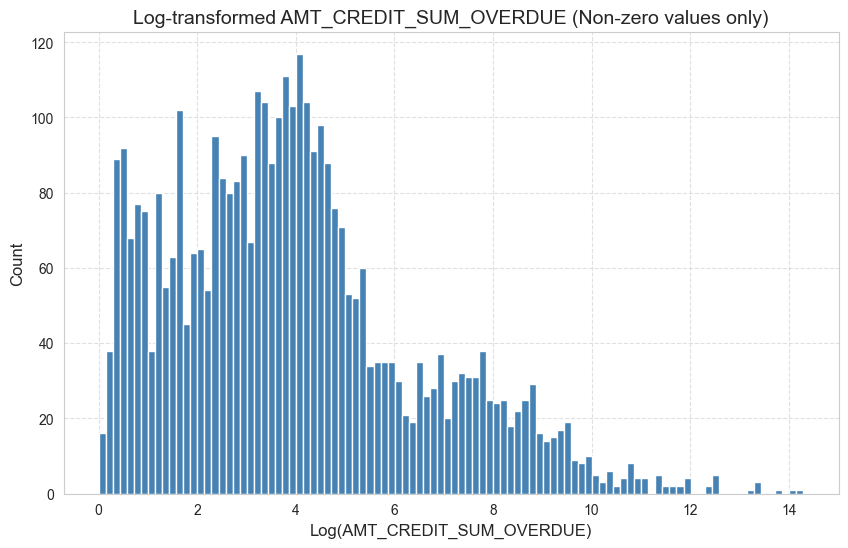

In [125]:
# we can visualize with non zero 
overdue_nonzero = aggregated_bureau[aggregated_bureau['AMT_CREDIT_SUM_OVERDUE'] > 0]
plt.figure(figsize=(10,6))
plt.hist(np.log1p(overdue_nonzero['AMT_CREDIT_SUM_OVERDUE']), bins=100, color='steelblue')
plt.title('Log-transformed AMT_CREDIT_SUM_OVERDUE (Non-zero values only)', fontsize=14)
plt.xlabel('Log(AMT_CREDIT_SUM_OVERDUE)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


<Axes: xlabel='YEARS_CREDIT_UPDATE', ylabel='Count'>

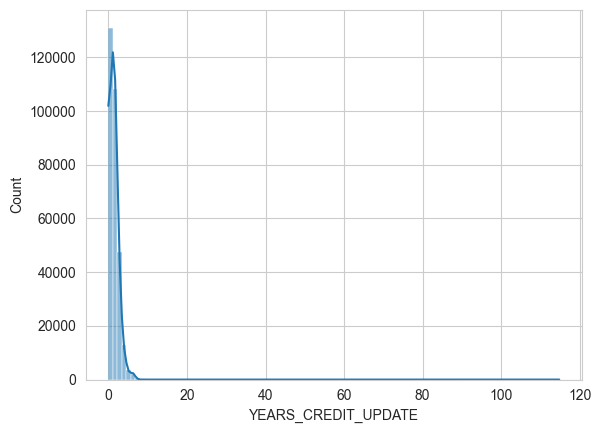

In [133]:
sns.histplot(data=aggregated_bureau, x='YEARS_CREDIT_UPDATE', kde=True, bins=100)

In [363]:
aggregated_bureau = aggregated_bureau[aggregated_bureau['YEARS_CREDIT_UPDATE'] >= 0]
aggregated_bureau = aggregated_bureau[aggregated_bureau['YEARS_CREDIT_UPDATE'] < 20]

<Axes: xlabel='YEARS_CREDIT_UPDATE', ylabel='Count'>

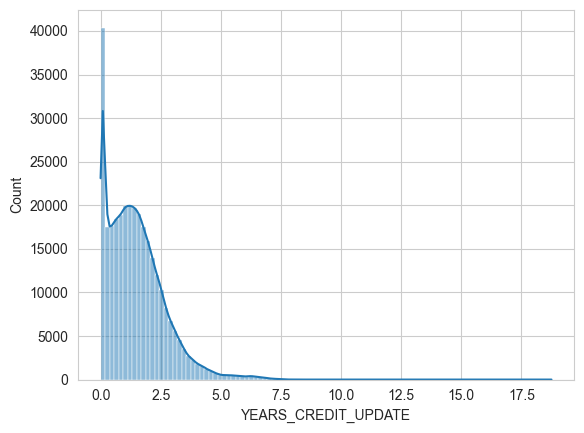

In [298]:
sns.histplot(data=aggregated_bureau, x='YEARS_CREDIT_UPDATE', kde=True, bins=100)

* DAYS_CREDIT --> above 75% of the clients within last 5 years 
* CREDIT_DAY_OVERDUE --> above 95% of the clients dont have day_overdue this mean that people they are above 1 day overdue may default 
* DAYS_ENDDATE_FACT --> 75% of the clients will end their bureau after 3.6 years 
* AMT_CREDIT_MAX_OVERDUE --> 75% of the clients have less then 2000$ while i have clients overdue with millions
* AMT_CREDIT_SUM --> most of the clients has credit between 20000-400000 
* AMT_CREDIT_SUM_DEBT --> we can split this to still has debt or not and i have values with negative values and this is not logic so we need to clip them 
* AMT_CREDIT_SUM_LIMIT --> most of the clients don't have limit and we can split the clients to has limit and not with removing negative values 
* AMT_CREDIT_SUM_OVERDUE --> more than 300 thousand clients doest overdue anything while very few people overdue we can split them based on overdue
* YEARS_CREDIT_UPDATE --> we have values more than 20 years and this is not logic while we have values less then 0 and this is not logic too

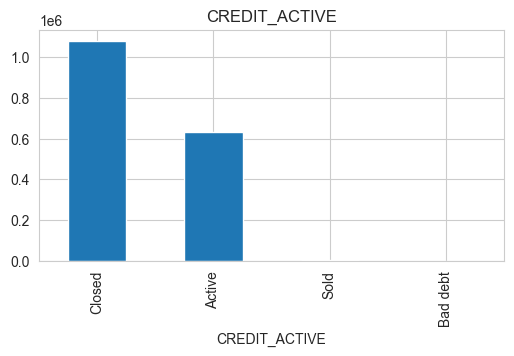

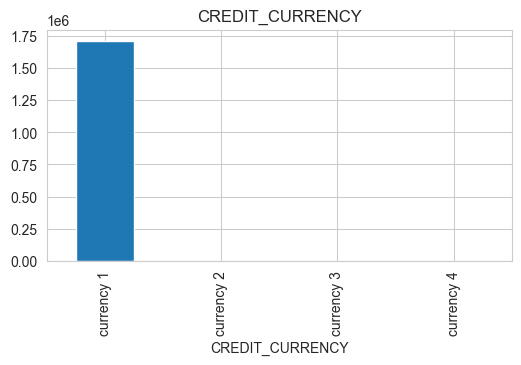

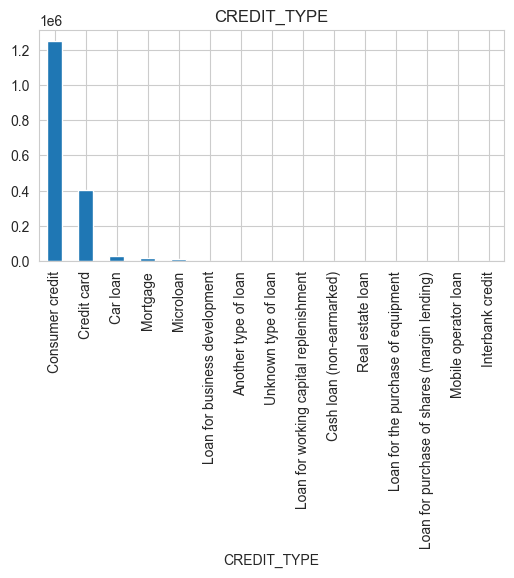

In [209]:
cat_cols = bureau.select_dtypes(include=['category', 'object']).columns.to_list()
for col in cat_cols:
    plt.figure(figsize=(6,3))
    bureau[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

In [370]:
# Debt ratio
aggregated_bureau['DEBT_RATIO'] = aggregated_bureau['AMT_CREDIT_SUM_DEBT'] / aggregated_bureau['AMT_CREDIT_SUM']
aggregated_bureau['DEBT_RATIO'] = aggregated_bureau['DEBT_RATIO'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [371]:
# Utilization ratio
aggregated_bureau['LIMIT_USAGE'] = aggregated_bureau['AMT_CREDIT_SUM'] / aggregated_bureau['AMT_CREDIT_SUM_LIMIT']
aggregated_bureau['LIMIT_USAGE'] = aggregated_bureau['LIMIT_USAGE'].replace([np.inf, -np.inf], np.nan).fillna(0)


In [372]:
# Overdue ratio
aggregated_bureau['OVERDUE_RATIO'] = aggregated_bureau['AMT_CREDIT_SUM_OVERDUE'] / aggregated_bureau['AMT_CREDIT_SUM']
aggregated_bureau['OVERDUE_RATIO'] = aggregated_bureau['OVERDUE_RATIO'].replace([np.inf, -np.inf], np.nan).fillna(0)


In [373]:
aggregated_bureau.describe().T

count           mean            std       min  \
SK_ID_CURR              305788.0  278045.167691  102849.322475  100001.0   
CREDIT_DAY_OVERDUE      305788.0       0.965787      24.957879       0.0   
DAYS_CREDIT_ENDDATE     303203.0     662.395890    3282.438207  -41875.0   
AMT_CREDIT_MAX_OVERDUE  212948.0    5005.401893  285697.323836       0.0   
CNT_CREDIT_PROLONG      305788.0       0.007010       0.062335       0.0   
AMT_CREDIT_SUM          305786.0  380751.842730  879317.155942       0.0   
AMT_CREDIT_SUM_DEBT     297416.0  161665.669597  536766.963783       0.0   
AMT_CREDIT_SUM_LIMIT    280481.0    5897.481236   29914.627747       0.0   
AMT_CREDIT_SUM_OVERDUE  305788.0      45.954176    4956.826551       0.0   
AMT_ANNUITY             118222.0   15608.411375  152403.277059       0.0   
DEBT_RATIO              305788.0       0.318633       0.332611       0.0   
LIMIT_USAGE             305788.0    1892.556164  135931.392385       0.0   
OVERDUE_RATIO           305788.0       0.000193       0.029314       0.0   
MONTHS_BALANCE_MIN      134540.0     -34.573161      17.664086     -96.0   
MONTHS_BALANCE_MAX      134540.0      -5.319871       9.346324     -92.0   
MONTHS_BALANCE_COUNT    134540.0      30.253290      17.466763       1.0   
STATUS_0_COUNT          134540.0       9.351935       6.911024       0.0   
STATUS_C_COUNT          134540.0      14.047563      14.216758       0.0   
STATUS_X_COUNT          134540.0       6.381296       9.947053       0.0   
STATUS_1_COUNT          134540.0       0.322753       0.958560       0.0   
STATUS_2_COUNT          134540.0       0.033240       0.213911       0.0   
STATUS_3_COUNT          134540.0       0.013680       0.121571       0.0   
STATUS_5_COUNT          134540.0       0.093625       1.300124       0.0   
Years_Credit            305788.0       2.969355       1.530004      -0.0   
Years_ENDDATE_FACT      268134.0       2.649376       1.455231      -0.0   
YEARS_CREDIT_UPDATE     305788.0       1.485259       1.180638      -0.0   

                                  25%            50%            75%  \
SK_ID_CURR              188877.750000  277890.500000  367182.250000   
CREDIT_DAY_OVERDUE           0.000000       0.000000       0.000000   
DAYS_CREDIT_ENDDATE       -697.600000    -131.800000     613.000000   
AMT_CREDIT_MAX_OVERDUE       0.000000       0.000000    2064.001500   
CNT_CREDIT_PROLONG           0.000000       0.000000       0.000000   
AMT_CREDIT_SUM          103962.870000  197298.647727  397876.357969   
AMT_CREDIT_SUM_DEBT          0.000000   44760.262500  143607.375000   
AMT_CREDIT_SUM_LIMIT         0.000000       0.000000       0.000000   
AMT_CREDIT_SUM_OVERDUE       0.000000       0.000000       0.000000   
AMT_ANNUITY                702.000000    6516.375000   14843.548558   
DEBT_RATIO                   0.000000       0.244597       0.538141   
LIMIT_USAGE                  0.000000       0.000000       0.000000   
OVERDUE_RATIO                0.000000       0.000000       0.000000   
MONTHS_BALANCE_MIN         -45.500000     -33.545455     -21.666667   
MONTHS_BALANCE_MAX          -8.000000       0.000000       0.000000   
MONTHS_BALANCE_COUNT        17.000000      28.000000      40.888889   
STATUS_0_COUNT               5.000000       8.000000      12.000000   
STATUS_C_COUNT               2.500000      10.555556      21.333333   
STATUS_X_COUNT               0.500000       2.400000       8.250000   
STATUS_1_COUNT               0.000000       0.000000       0.250000   
STATUS_2_COUNT               0.000000       0.000000       0.000000   
STATUS_3_COUNT               0.000000       0.000000       0.000000   
STATUS_5_COUNT               0.000000       0.000000       0.000000   
Years_Credit                 1.836644       2.883562       3.920548   
Years_ENDDATE_FACT           1.571689       2.538150       3.530548   
YEARS_CREDIT_UPDATE          0.572603       1.313014       2.119586   

                                 max  
SK_ID_CURR       

In [374]:
aggregated_bureau.drop(['DAYS_CREDIT', 'DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE'], axis=1, inplace=True)
aggregated_bureau

KeyError: "['DAYS_CREDIT', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'] not found in axis"

In [306]:
cat_features = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
bureau_cat = pd.get_dummies(bureau[cat_features + ['SK_ID_CURR']], columns=cat_features)
aggregated_cats = bureau_cat.groupby('SK_ID_CURR').sum().reset_index()
aggregated_bureau = aggregated_bureau.merge(aggregated_cats, on='SK_ID_CURR', how='left')


In [375]:
train_reduced_2 = train_reduced_2.loc[:, ~train_reduced_2.columns.duplicated()]


In [376]:
train_reduced_2 = train_reduced_2.merge(aggregated_bureau, on='SK_ID_CURR', how='left')

In [377]:
target_data = train[['SK_ID_CURR', 'TARGET']]
final_data = train_reduced_2.merge(target_data, on='SK_ID_CURR', how='left')

In [378]:
final_data.columns

Index(['EXT_MEAN', 'ANNUITY_TO_CREDIT', 'ORGANIZATION_TYPE', 'EXT_SOURCE_3',
       'CREDIT_TO_PRICE', 'YEARS_EMPLOYED', 'EXT_MIN', 'EXT_SOURCE_1', 'AGE',
       'AMT_ANNUITY_x', 'ANNUITY_TO_PRICE', 'OCCUPATION_TYPE',
       'NAME_EDUCATION_TYPE', 'AMT_GOODS_PRICE', 'EXT_MAX', 'CODE_GENDER',
       'YEARS_ID_PUBLISH', 'OWN_CAR_AGE', 'AMT_CREDIT', 'EXT_STD',
       'YEARS_MEAN', 'CAR_AGE_TO_AGE', 'EXT_SOURCE_2',
       'YEARS_LAST_PHONE_CHANGE', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT',
       'TOTALAREA_MODE', 'SK_ID_CURR', 'REGION_RATING_CLIENT_W_CITY',
       'AREA_PER_POP', 'FLAG_DOCUMENT_3', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY_y', 'DEBT_RATIO', 'LIMIT_USAGE',
       'OVERDUE_RATIO', 'MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX',
       'MONTHS_BALANCE_COUNT', 'STATUS_0_COUNT', 'STATUS_C_COUNT',
       'STATUS_X_COUN

In [379]:
# using baseline model with all features 
X = final_data.drop(columns=['TARGET'])
y = final_data['TARGET']
model_full_2 = LGBMClassifier(random_state=42)

scores_full_2 = cross_val_score(
    model_full_2,
    X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
print("Baseline AUC:", scores_full_2.mean())

Baseline AUC: 0.7649461979971639


In [380]:
model_full_3 = LGBMClassifier()
model_full_3.fit(X, y)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11600
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


LGBMClassifier()

In [382]:
booster = model_full_3.booster_
importance_gain = booster.feature_importance(importance_type='gain')

imp_df_gain = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance_gain': importance_gain
}).sort_values(by='importance_gain', ascending=False)
imp_df_gain[imp_df_gain['importance_gain'] > 0].reset_index()

index                       feature  importance_gain
0       0                      EXT_MEAN     71919.145369
1       2             ORGANIZATION_TYPE     10072.658898
2       1             ANNUITY_TO_CREDIT      9159.906549
3       4               CREDIT_TO_PRICE      4895.520239
4       3                  EXT_SOURCE_3      4490.035909
5      39                    DEBT_RATIO      4227.154613
6       5                YEARS_EMPLOYED      3724.717529
7       6                       EXT_MIN      3447.379215
8       7                  EXT_SOURCE_1      3092.570823
9       8                           AGE      3037.976420
10      9                 AMT_ANNUITY_x      2807.096061
11     34                AMT_CREDIT_SUM      2642.969561
12     10              ANNUITY_TO_PRICE      2586.766658
13     11               OCCUPATION_TYPE      2291.481986
14     13               AMT_GOODS_PRICE      2084.172193
15     12           NAME_EDUCATION_TYPE      2024.908284
16     32        AMT_CREDIT_MAX_OVERDUE      1947.253195
17     14                       EXT_MAX      1755.205417
18     15                   CODE_GENDER      1682.758676
19     20                    YEARS_MEAN      1668.455121
20     17                   OWN_CAR_AGE      1632.180081
21     16              YEARS_ID_PUBLISH      1314.989120
22     40                   LIMIT_USAGE      1291.721805
23     31           DAYS_CREDIT_ENDDATE      1140.919210
24     22                  EXT_SOURCE_2      1139.924312
25     52                  Years_Credit      1063.894403
26     27   REGION_RATING_CLIENT_W_CITY       994.269675
27     21                CAR_AGE_TO_AGE       958.425129
28     18                    AMT_CREDIT       943.747090
29     23       YEARS_LAST_PHONE_CHANGE       920.468050
30     53            Years_ENDDATE_FACT       909.790298
31     24  DEF_30_CNT_SOCIAL_CIRCLE_CAT       903.223341
32     28                  AREA_PER_POP       892.952294
33     25                TOTALAREA_MODE       881.987459
34     19                       EXT_STD       828.398534
35     29               FLAG_DOCUMENT_3       825.673733
36     48                STATUS_1_COUNT       744.608499
37     54           YEARS_CREDIT_UPDATE       701.422535
38     37        AMT_CREDIT_SUM_OVERDUE       635.465766
39     26                    SK_ID_CURR       587.903912
40     35           AMT_CREDIT_SUM_DEBT       577.092796
41     45                STATUS_0_COUNT       442.410311
42     44          MONTHS_BALANCE_COUNT       405.412398
43     38                 AMT_ANNUITY_y       286.427005
44     36          AMT_CREDIT_SUM_LIMIT       278.268501
45     46                STATUS_C_COUNT       269.680798
46     43            MONTHS_BALANCE_MAX       233.660360
47     47                STATUS_X_COUNT       221.608201
48     42            MONTHS_BALANCE_MIN       188.088400
49     50                STATUS_3_COUNT       144.417499
50     41                 OVERDUE_RATIO       132.082001
51     51                STATUS_5_COUNT        63.738000
52     30            CREDIT_DAY_OVERDUE        52.715000

In [383]:
imp_df_gain.shape[0]

55

In [384]:
features = [5]
while features[-1] <  65:
    new_item = features[-1] + 5
    features.append(new_item)
features.append(68)
features

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 68]

In [385]:
len(X.columns)

55

In [ ]:
imp_df_gain.head(68)['feature'].tolist()

['EXT_MEAN',
 'ORGANIZATION_TYPE',
 'ANNUITY_TO_CREDIT',
 'CREDIT_TO_PRICE',
 'EXT_SOURCE_3',
 'DEBT_RATIO',
 'YEARS_EMPLOYED',
 'EXT_MIN',
 'EXT_SOURCE_1',
 'AGE',
 'AMT_ANNUITY_x',
 'AMT_CREDIT_SUM',
 'ANNUITY_TO_PRICE',
 'OCCUPATION_TYPE',
 'AMT_GOODS_PRICE',
 'NAME_EDUCATION_TYPE',
 'AMT_CREDIT_MAX_OVERDUE',
 'EXT_MAX',
 'CODE_GENDER',
 'YEARS_MEAN',
 'OWN_CAR_AGE',
 'YEARS_ID_PUBLISH',
 'LIMIT_USAGE',
 'DAYS_CREDIT_ENDDATE',
 'EXT_SOURCE_2',
 'Years_Credit',
 'REGION_RATING_CLIENT_W_CITY',
 'CAR_AGE_TO_AGE',
 'AMT_CREDIT',
 'YEARS_LAST_PHONE_CHANGE',
 'Years_ENDDATE_FACT',
 'DEF_30_CNT_SOCIAL_CIRCLE_CAT',
 'AREA_PER_POP',
 'TOTALAREA_MODE',
 'EXT_STD',
 'FLAG_DOCUMENT_3',
 'STATUS_1_COUNT',
 'YEARS_CREDIT_UPDATE',
 'AMT_CREDIT_SUM_OVERDUE',
 'SK_ID_CURR',
 'AMT_CREDIT_SUM_DEBT',
 'STATUS_0_COUNT',
 'MONTHS_BALANCE_COUNT',
 'AMT_ANNUITY_y',
 'AMT_CREDIT_SUM_LIMIT',
 'STATUS_C_COUNT',
 'MONTHS_BALANCE_MAX',
 'STATUS_X_COUNT',
 'MONTHS_BALANCE_MIN',
 'STATUS_3_COUNT',
 'OVERDUE_RATIO

In [399]:
X.columns.tolist()

['EXT_MEAN',
 'ANNUITY_TO_CREDIT',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_3',
 'CREDIT_TO_PRICE',
 'YEARS_EMPLOYED',
 'EXT_MIN',
 'EXT_SOURCE_1',
 'AGE',
 'AMT_ANNUITY_x',
 'ANNUITY_TO_PRICE',
 'OCCUPATION_TYPE',
 'NAME_EDUCATION_TYPE',
 'AMT_GOODS_PRICE',
 'EXT_MAX',
 'CODE_GENDER',
 'YEARS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'AMT_CREDIT',
 'EXT_STD',
 'YEARS_MEAN',
 'CAR_AGE_TO_AGE',
 'EXT_SOURCE_2',
 'YEARS_LAST_PHONE_CHANGE',
 'DEF_30_CNT_SOCIAL_CIRCLE_CAT',
 'TOTALAREA_MODE',
 'SK_ID_CURR',
 'REGION_RATING_CLIENT_W_CITY',
 'AREA_PER_POP',
 'FLAG_DOCUMENT_3',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_ANNUITY_y',
 'DEBT_RATIO',
 'LIMIT_USAGE',
 'OVERDUE_RATIO',
 'MONTHS_BALANCE_MIN',
 'MONTHS_BALANCE_MAX',
 'MONTHS_BALANCE_COUNT',
 'STATUS_0_COUNT',
 'STATUS_C_COUNT',
 'STATUS_X_COUNT',
 'STATUS_1_COUNT',
 'STATUS_2_COUNT',
 'STATUS_3_COUN

In [400]:
# training the model with different number of features to show the model
models_results = {}
for num_features in features:
    top_features = imp_df_gain.head(num_features)['feature'].tolist()
    print(top_features)
    X_top = X[top_features]
    model_top = LGBMClassifier(random_state=42)
    scores_top = cross_val_score(
    model_top,
    X_top, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
    )
    models_results[num_features] = scores_top.mean()

['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'EXT_SOURCE_3']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'EXT_SOURCE_3', 'DEBT_RATIO', 'YEARS_EMPLOYED', 'EXT_MIN', 'EXT_SOURCE_1', 'AGE']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'EXT_SOURCE_3', 'DEBT_RATIO', 'YEARS_EMPLOYED', 'EXT_MIN', 'EXT_SOURCE_1', 'AGE', 'AMT_ANNUITY_x', 'AMT_CREDIT_SUM', 'ANNUITY_TO_PRICE', 'OCCUPATION_TYPE', 'AMT_GOODS_PRICE']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'EXT_SOURCE_3', 'DEBT_RATIO', 'YEARS_EMPLOYED', 'EXT_MIN', 'EXT_SOURCE_1', 'AGE', 'AMT_ANNUITY_x', 'AMT_CREDIT_SUM', 'ANNUITY_TO_PRICE', 'OCCUPATION_TYPE', 'AMT_GOODS_PRICE', 'NAME_EDUCATION_TYPE', 'AMT_CREDIT_MAX_OVERDUE', 'EXT_MAX', 'CODE_GENDER', 'YEARS_MEAN']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'EXT_SOURCE_3', 'DEBT_RATIO', 'YEARS_EMPLOYED', 'EXT_MIN', 'EXT_SOURCE_1', 'AGE', 'AMT_ANNUIT

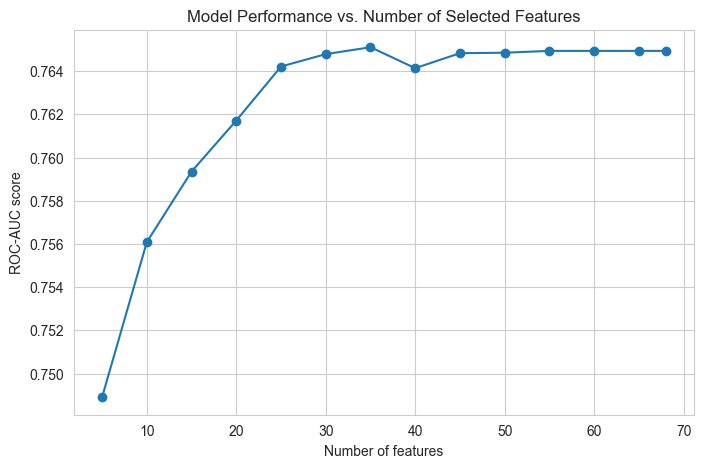

In [401]:
import matplotlib.pyplot as plt
# Extract x and y values
x = list(models_results.keys())
y = [float(v) for v in models_results.values()]  # ensure standard floats
# Plot
plt.figure(figsize=(8,5))
plt.plot(x, y, marker='o')
plt.xlabel("Number of features")
plt.ylabel("ROC-AUC score")
plt.title("Model Performance vs. Number of Selected Features")
plt.grid(True)
plt.show()


* we increased this by adding new features 

In [404]:
new_top_feature = imp_df_gain.head(35).feature.tolist()
new_top_feature.append('SK_ID_CURR')

In [405]:
selecte_columns = final_data[new_top_feature]
target_data = train[['SK_ID_CURR', 'TARGET']]
final_data = selecte_columns.merge(target_data, on='SK_ID_CURR', how='left')

In [408]:
cat_features = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
bureau_cat = pd.get_dummies(bureau[cat_features + ['SK_ID_CURR']], columns=cat_features)
aggregated_cats = bureau_cat.groupby('SK_ID_CURR').sum().reset_index()

In [409]:
final_data = final_data.merge(aggregated_cats, on='SK_ID_CURR', how='left')

In [410]:
final_data

EXT_MEAN       ORGANIZATION_TYPE  ANNUITY_TO_CREDIT  CREDIT_TO_PRICE  \
0       0.161787  Business Entity Type 3           0.060749         1.158397   
1       0.466757                  School           0.027598         1.145199   
2       0.642739              Government           0.050000         1.000000   
3       0.650442  Business Entity Type 3           0.094941         1.052803   
4       0.322738                Religion           0.042623         1.000000   
...          ...                     ...                ...              ...   
307506  0.413601                Services           0.108198         1.132000   
307507  0.115992                     XNA           0.044524         1.198000   
307508  0.499536                  School           0.044239         1.158400   
307509  0.587593  Business Entity Type 1           0.054592         1.158394   
307510  0.518984  Business Entity Type 3           0.072767         1.000000   

        EXT_SOURCE_3  DEBT_RATIO  YEARS_EMPLOYED   EXT_MIN  EXT_SOURCE_1  \
0           0.139376    0.454595        1.745205  0.083037      0.083037   
1                NaN    0.000000        3.254795  0.311267      0.311267   
2           0.729567    0.000000        0.616438  0.555912           NaN   
3                NaN         NaN        8.326027  0.650442           NaN   
4                NaN    0.000000        8.323288  0.322738           NaN   
...              ...         ...             ...       ...           ...   
307506           NaN         NaN        0.646575  0.145570      0.145570   
307507           NaN         NaN             NaN  0.115992           NaN   
307508      0.218859    0.453493       21.701370  0.218859      0.744026   
307509      0.661024    0.000000       13.112329  0.514163           NaN   
307510      0.113922    0.555116        3.457534  0.113922      0.734460   

              AGE  ...  CREDIT_TYPE_Interbank credit  \
0       25.920548  ...                           0.0   
1       45.931507  ...                           0.0   
2       52.180822  ...                           0.0   
3       52.068493  ...                           NaN   
4       54.608219  ...                           0.0   
...           ...  ...                           ...   
307506  25.553425  ...                           NaN   
307507  56.917808  ...                           NaN   
307508  41.002740  ...                           0.0   
307509  32.769863  ...                           0.0   
307510  46.180822  ...                           0.0   

        CREDIT_TYPE_Loan for business development  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             NaN   
4                                             0.0   
...                                           ...   
307506                                        NaN   
307507                                        NaN   
307508                                        0.0   
307509                                        0.0   
307510                                        0.0   

        CREDIT_TYPE_Loan for purchase of shares (margin lending)  \
0                                                     0.0          
1                                                     0.0          
2                                                     0.0          
3                                                     NaN          
4                                                     0.0          
...                                                   ...          
307506                                                NaN          
307507                                                NaN          
307508                                                0.0          
307509                                                0.0          
307510                                                0.0          

       

In [411]:
X = final_data.drop(columns=['TARGET'])
y = final_data['TARGET']
model_full_2 = LGBMClassifier(random_state=42)

scores_full_2 = cross_val_score(
    model_full_2,
    X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
print("Baseline AUC:", scores_full_2.mean())

Baseline AUC: 0.7660237012524345


In [413]:
new_top_feature = imp_df_gain.head(35).feature.tolist()
new_top_feature.append('SK_ID_CURR')
selecte_columns = final_data[new_top_feature]
target_data = train[['SK_ID_CURR', 'TARGET']]
final_data = selecte_columns.merge(target_data, on='SK_ID_CURR', how='left')

* this means adding these feature willnot effect the model performance 

In [ ]:
final_data

EXT_MEAN       ORGANIZATION_TYPE  ANNUITY_TO_CREDIT  CREDIT_TO_PRICE  \
0       0.161787  Business Entity Type 3           0.060749         1.158397   
1       0.466757                  School           0.027598         1.145199   
2       0.642739              Government           0.050000         1.000000   
3       0.650442  Business Entity Type 3           0.094941         1.052803   
4       0.322738                Religion           0.042623         1.000000   
...          ...                     ...                ...              ...   
307506  0.413601                Services           0.108198         1.132000   
307507  0.115992                     XNA           0.044524         1.198000   
307508  0.499536                  School           0.044239         1.158400   
307509  0.587593  Business Entity Type 1           0.054592         1.158394   
307510  0.518984  Business Entity Type 3           0.072767         1.000000   

        EXT_SOURCE_3  DEBT_RATIO  YEARS_EMPLOYED   EXT_MIN  EXT_SOURCE_1  \
0           0.139376    0.454595        1.745205  0.083037      0.083037   
1                NaN    0.000000        3.254795  0.311267      0.311267   
2           0.729567    0.000000        0.616438  0.555912           NaN   
3                NaN         NaN        8.326027  0.650442           NaN   
4                NaN    0.000000        8.323288  0.322738           NaN   
...              ...         ...             ...       ...           ...   
307506           NaN         NaN        0.646575  0.145570      0.145570   
307507           NaN         NaN             NaN  0.115992           NaN   
307508      0.218859    0.453493       21.701370  0.218859      0.744026   
307509      0.661024    0.000000       13.112329  0.514163           NaN   
307510      0.113922    0.555116        3.457534  0.113922      0.734460   

              AGE  ...  CAR_AGE_TO_AGE  AMT_CREDIT  YEARS_LAST_PHONE_CHANGE  \
0       25.920548  ...             NaN    406597.5                 3.106849   
1       45.931507  ...             NaN   1293502.5                 2.268493   
2       52.180822  ...        0.498267    135000.0                 2.232877   
3       52.068493  ...             NaN    312682.5                 1.690411   
4       54.608219  ...             NaN    513000.0                 3.030137   
...           ...  ...             ...         ...                      ...   
307506  25.553425  ...             NaN    254700.0                 0.747945   
307507  56.917808  ...             NaN    269550.0                -0.000000   
307508  41.002740  ...             NaN    677664.0                 5.230137   
307509  32.769863  ...             NaN    370107.0                 0.882192   
307510  46.180822  ...             NaN    675000.0                 2.156164   

       Years_ENDDATE_FACT  DEF_30_CNT_SOCIAL_CIRCLE_CAT AREA_PER_POP  \
0                1.910959                             2     0.792511   
1                3.006393                             0    20.163796   
2                1.458904                             0          NaN   
3                     NaN                             0          NaN   
4                2.145205                             0          NaN   
...                   ...                           ...          ...   
307506                NaN                             0     8.900218   
307507                NaN                             0     0.850421   
307508           2.175342                             0   159.336265   
307509           2.353425                             0     1.618671   
307510           2.652968                             0     1.553440   

        TOTALAREA_MODE   EXT_STD SK_ID_CURR  TARGET  
0               0.0149  0.075139     100002       1  
1               0.0714  0.155489     100003       0  
2                  NaN  0.086827     100004       0  
3                  NaN  0.000000     100006       0  
4                  NaN  0.000000     100007       

In [417]:
nulls_df(final_data).sort_values(by='Nulls_Percentage', ascending=False)

Column  Nulls_Count  Nulls_Percentage         Type
20                   OWN_CAR_AGE       202929         65.990810    Numerical
27                CAR_AGE_TO_AGE       202929         65.990810    Numerical
8                   EXT_SOURCE_1       173378         56.381073    Numerical
32                  AREA_PER_POP       148431         48.268517    Numerical
33                TOTALAREA_MODE       148431         48.268517    Numerical
16        AMT_CREDIT_MAX_OVERDUE       123648         40.209293    Numerical
13               OCCUPATION_TYPE        96391         31.345545  Categorical
30            Years_ENDDATE_FACT        77177         25.097314    Numerical
4                   EXT_SOURCE_3        60965         19.825307    Numerical
6                 YEARS_EMPLOYED        55374         18.007161    Numerical
23           DAYS_CREDIT_ENDDATE        46292         15.053770    Numerical
11                AMT_CREDIT_SUM        44044         14.322740    Numerical
25                  Years_Credit        44043         14.322414    Numerical
5                     DEBT_RATIO        44043         14.322414    Numerical
22                   LIMIT_USAGE        44043         14.322414    Numerical
31  DEF_30_CNT_SOCIAL_CIRCLE_CAT         1021          0.332021  Categorical
24                  EXT_SOURCE_2          660          0.214626    Numerical
12              ANNUITY_TO_PRICE          290          0.094306    Numerical
14               AMT_GOODS_PRICE          278          0.090403    Numerical
3                CREDIT_TO_PRICE          278          0.090403    Numerical
0                       EXT_MEAN          172          0.055933    Numerical
7                        EXT_MIN          172          0.055933    Numerical
34                       EXT_STD          172          0.055933    Numerical
17                       EXT_MAX          172          0.055933    Numerical
2              ANNUITY_TO_CREDIT           12          0.003902    Numerical
10                 AMT_ANNUITY_x           12          0.003902    Numerical
29       YEARS_LAST_PHONE_CHANGE            1          0.000325    Numerical
1              ORGANIZATION_TYPE            0          0.000000  Categorical
9                            AGE            0          0.000000    Numerical
19                    YEARS_MEAN            0          0.000000    Numerical
18                   CODE_GENDER            0          0.000000  Categorical
15           NAME_EDUCATION_TYPE            0          0.000000  Categorical
21              YEARS_ID_PUBLISH            0          0.000000    Numerical
28                    AMT_CREDIT            0          0.000000    Numerical
26   REGION_RATING_CLIENT_W_CITY            0          0.000000  Categorical
35                    SK_ID_CURR            0          0.000000    Numerical
36                        TARGET            0          0.000000    Numerical

In [ ]:
final_data.to_csv("final_data.csv", index=False)

In [86]:
final_data = pd.read_csv('final_data.csv')

## previous_application 

In [39]:
previous_application

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
4           1784265      202054         Cash loans    31924.395   
...             ...         ...                ...          ...   
1670209     2300464      352015     Consumer loans    14704.290   
1670210     2357031      334635     Consumer loans     6622.020   
1670211     2659632      249544     Consumer loans    11520.855   
1670212     2785582      400317         Cash loans    18821.520   
1670213     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               NaN         607500.0   
2               112500.0    136444.5               NaN         112500.0   
3               450000.0    470790.0               NaN         450000.0   
4               337500.0    404055.0               NaN         337500.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               NaN         180000.0   
1670213         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                         SATURDAY                       15   
1                         THURSDAY                       11   
2                          TUESDAY                       11   
3                           MONDAY                        7   
4                         THURSDAY                        9   
...                            ...                      ...   
1670209                  WEDNESDAY                       12   
1670210                    TUESDAY                       15   
1670211                     MONDAY                       12   
1670212                  WEDNESDAY                        9   
1670213                     SUNDAY                       10   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                                 Y                       1   
1                                 Y                       1   
2                                 Y                       1   
3                                 Y                       1   
4                                 Y                       1   
...                             ...                     ...   
1670209                           Y                       1   
1670210                           Y                       1   
1670211                           Y                       1   
1670212                           Y                       1   
1670213                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0                 0.000000               0.182832                  0.867336   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
...                    ...                    ...                       ...   
1670209           0.000000                    NaN                       NaN   
1670210           0.340554                    NaN                       NaN   
1670211           0.101401                    NaN                       NaN   

* NAME_CONTRACT_TYPE: Past product type (cash, POS, etc.) can reveal risk patterns by contract type.

* AMT_ANNUITY: Size of annuity on past applications helps measure previous repayment burden and affordability.

* AMT_APPLICATION: Amount the client initially requested shows their demand for credit and possible over-asking behavior.

* AMT_CREDIT: Final approved amount reflects how much the lender actually trusted the client in previous decisions.

* AMT_DOWN_PAYMENT: Higher or lower down payment levels reflect client’s own contribution and risk appetite.

* AMT_GOODS_PRICE: Value of goods financed can indicate spending patterns and exposure to large purchases.

* WEEKDAY_APPR_PROCESS_START: Application weekday can sometimes capture behavioral or operational patterns in risky clients.

* HOUR_APPR_PROCESS_START: Application hour (e.g., late-night behavior) can correlate with different risk segments.

* FLAG_LAST_APPL_PER_CONTRACT: Whether this was the last application for the contract can hint at corrected mistakes or repeated attempts.

* NFLAG_LAST_APPL_IN_DAY: Multiple applications in a single day may indicate credit shopping or suspicious behavior.

* NFLAG_MICRO_CASH: Micro-loan usage can signal liquidity problems or high-frequency borrowing behavior.

* RATE_DOWN_PAYMENT: Normalized down payment rate shows how much skin in the game the client had relative to credit size.

* RATE_INTEREST_PRIMARY: Higher normalized interest rates usually signal higher perceived risk by the lender in past deals.

* RATE_INTEREST_PRIVILEGED: Preferential rates can indicate strong, trusted clients or special segments.

* NAME_CASH_LOAN_PURPOSE: Purpose of past loans helps identify risky purposes (e.g., non-productive consumption vs. assets).

* NAME_CONTRACT_STATUS: Final status (Approved, Refused, Canceled, etc.) is highly informative of past creditworthiness.

* DAYS_DECISION: Timing of past decisions relative to the current application helps distinguish recent vs. old behavior.

* NAME_PAYMENT_TYPE: Chosen payment method (cash, card, etc.) can reflect financial habits and access to banking.

* CODE_REJECT_REASON: Reasons for past refusals directly highlight previous risk or policy violations.

* NAME_TYPE_SUITE: Who accompanied the client may correlate with certain socio-behavioral risk profiles.

* NAME_CLIENT_TYPE: Whether the client was new or existing in past apps helps quantify relationship depth and loyalty.

* NAME_GOODS_CATEGORY: Type of goods requested links to different risk levels by category (e.g. luxury vs. essential).

* NAME_PORTFOLIO: Portfolio type (CASH, POS, CAR…) allows risk differentiation by business line.

* NAME_PRODUCT_TYPE: X-sell vs walk-in indicates whether the client was cross-sold or self-initiated, which can impact risk.

* CHANNEL_TYPE: Acquisition channel (branch, online, partner, etc.) often has different risk distributions.

* SELLERPLACE_AREA: Size/area of seller location may correlate with income level and economic environment.

* NAME_SELLER_INDUSTRY: Industry of the seller can highlight unstable or high-risk sectors.

* CNT_PAYMENT: Planned term of the previous credit helps measure commitment length and typical borrowing structure.

* NAME_YIELD_GROUP: Grouped interest (low/medium/high) is a compact risk signal assigned by the bank.

* PRODUCT_COMBINATION: Detailed product bundle can encode nuanced segments with different risk profiles.

* DAYS_FIRST_DRAWING: Delay to first disbursement shows how quickly the client actually took the money.

* DAYS_FIRST_DUE: Timing of first due date reflects how soon repayment started relative to application.

* DAYS_LAST_DUE_1ST_VERSION: Original last due date gives the initial planned maturity of the credit.

* DAYS_LAST_DUE: Actual last due date captures any modification/extension versus the original plans.

* DAYS_TERMINATION: Expected termination date reflects the full life cycle of the previous credit.

* NFLAG_INSURED_ON_APPROVAL: Whether the client requested insurance can signal risk awareness and financial prudence.

In [26]:
pd.set_option('display.max_columns', None)   
pd.set_option('display.width', None)       
pd.set_option('display.max_colwidth', None)


In [50]:
previous_application

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
4           1784265      202054         Cash loans    31924.395   
...             ...         ...                ...          ...   
1670209     2300464      352015     Consumer loans    14704.290   
1670210     2357031      334635     Consumer loans     6622.020   
1670211     2659632      249544     Consumer loans    11520.855   
1670212     2785582      400317         Cash loans    18821.520   
1670213     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               NaN         607500.0   
2               112500.0    136444.5               NaN         112500.0   
3               450000.0    470790.0               NaN         450000.0   
4               337500.0    404055.0               NaN         337500.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               NaN         180000.0   
1670213         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                         SATURDAY                       15   
1                         THURSDAY                       11   
2                          TUESDAY                       11   
3                           MONDAY                        7   
4                         THURSDAY                        9   
...                            ...                      ...   
1670209                  WEDNESDAY                       12   
1670210                    TUESDAY                       15   
1670211                     MONDAY                       12   
1670212                  WEDNESDAY                        9   
1670213                     SUNDAY                       10   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                                 Y                       1   
1                                 Y                       1   
2                                 Y                       1   
3                                 Y                       1   
4                                 Y                       1   
...                             ...                     ...   
1670209                           Y                       1   
1670210                           Y                       1   
1670211                           Y                       1   
1670212                           Y                       1   
1670213                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0                 0.000000               0.182832                  0.867336   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
...                    ...                    ...                       ...   
1670209           0.000000                    NaN                       NaN   
1670210           0.340554                    NaN                       NaN   
1670211           0.101401                    NaN                       NaN   

In [51]:
# encoding the categories 
prev_ohe = pd.get_dummies(previous_application, columns=[
    'NAME_CONTRACT_TYPE',
    'NAME_CONTRACT_STATUS',
    'NAME_CLIENT_TYPE',
    'NAME_CASH_LOAN_PURPOSE',
    'NAME_PORTFOLIO',
    'PRODUCT_COMBINATION',
    'CHANNEL_TYPE',
    'NAME_SELLER_INDUSTRY'
])

In [ ]:
original_cols = previous_application.columns.to_list()
cols_not_in_original = [c for c in prev_ohe.columns if c not in original_cols]
new_cols = prev_ohe[cols_not_in_original].columns.to_list()

In [45]:
prev_ohe

SK_ID_PREV  SK_ID_CURR  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  \
0           2030495      271877     1730.430          17145.0     17145.0   
1           2802425      108129    25188.615         607500.0    679671.0   
2           2523466      122040    15060.735         112500.0    136444.5   
3           2819243      176158    47041.335         450000.0    470790.0   
4           1784265      202054    31924.395         337500.0    404055.0   
...             ...         ...          ...              ...         ...   
1670209     2300464      352015    14704.290         267295.5    311400.0   
1670210     2357031      334635     6622.020          87750.0     64291.5   
1670211     2659632      249544    11520.855         105237.0    102523.5   
1670212     2785582      400317    18821.520         180000.0    191880.0   
1670213     2418762      261212    16431.300         360000.0    360000.0   

         AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0                     0.0          17145.0                   SATURDAY   
1                     NaN         607500.0                   THURSDAY   
2                     NaN         112500.0                    TUESDAY   
3                     NaN         450000.0                     MONDAY   
4                     NaN         337500.0                   THURSDAY   
...                   ...              ...                        ...   
1670209               0.0         267295.5                  WEDNESDAY   
1670210           29250.0          87750.0                    TUESDAY   
1670211           10525.5         105237.0                     MONDAY   
1670212               NaN         180000.0                  WEDNESDAY   
1670213               NaN         360000.0                     SUNDAY   

         HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                             15                           Y   
1                             11                           Y   
2                             11                           Y   
3                              7                           Y   
4                              9                           Y   
...                          ...                         ...   
1670209                       12                           Y   
1670210                       15                           Y   
1670211                       12                           Y   
1670212                        9                           Y   
1670213                       10                           Y   

         NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                             1           0.000000               0.182832   
1                             1                NaN                    NaN   
2                             1                NaN                    NaN   
3                             1                NaN                    NaN   
4                             1                NaN                    NaN   
...                         ...                ...                    ...   
1670209                       1           0.000000                    NaN   
1670210                       1           0.340554                    NaN   
1670211                       1           0.101401                    NaN   
1670212                       1                NaN                    NaN   
1670213                       1                NaN                    NaN   

         RATE_INTEREST_PRIVILEGED  DAYS_DECISION      NAME_PAYMENT_TYPE  \
0                        0.867336            -73  Cash through the bank   
1                             NaN           -164                    XNA   
2                             NaN           -301  Cash through the bank   
3                             NaN           -512  Cash through the bank   
4                             NaN           -781  Cash through the bank   
...                           ...            ...               

In [ ]:
# Numeric aggregations
prev_agg = prev_ohe.groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': ['mean', 'max'],
    'AMT_APPLICATION': ['mean', 'max', 'min'],
    'AMT_CREDIT': ['mean', 'max', 'min'],
    'AMT_DOWN_PAYMENT': ['mean', 'max'],
    'AMT_GOODS_PRICE': ['mean', 'max'],
    'DAYS_DECISION': ['mean', 'min'],
    'CNT_PAYMENT': ['mean', 'max']
})

# Flatten column names
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]

In [58]:
for col in new_cols:
    prev_agg[col + '_MEAN'] = prev_ohe.groupby('SK_ID_CURR')[col].mean()
    prev_agg[col + '_SUM'] = prev_ohe.groupby('SK_ID_CURR')[col].sum()

C:\Users\DREAMS\AppData\Local\Temp\ipykernel_18756\2323281758.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prev_agg[col + '_SUM'] = prev_ohe.groupby('SK_ID_CURR')[col].sum()
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_18756\2323281758.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prev_agg[col + '_MEAN'] = prev_ohe.groupby('SK_ID_CURR')[col].mean()
C:\Users\DREAMS\AppData\Local\Temp\ipykernel_18756\2323281758.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

In [59]:
# Count features
prev_agg['PREV_TOTAL_APPLICATIONS'] = previous_application.groupby('SK_ID_CURR').size()
prev_agg['PREV_APPROVED'] = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Approved'] \
                            .groupby('SK_ID_CURR').size()
prev_agg['PREV_REFUSED'] = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Refused'] \
                            .groupby('SK_ID_CURR').size()

In [61]:
# Fill missing with 0
prev_agg['PREV_APPROVED'] = prev_agg['PREV_APPROVED'].fillna(0)
prev_agg['PREV_REFUSED'] = prev_agg['PREV_REFUSED'].fillna(0)

# Ratios
prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED'] / prev_agg['PREV_TOTAL_APPLICATIONS']
prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED'] / prev_agg['PREV_TOTAL_APPLICATIONS']

In [62]:
prev_agg

PREV_AMT_ANNUITY_MEAN  PREV_AMT_ANNUITY_MAX  \
SK_ID_CURR                                                
100001                3951.000000              3951.000   
100002                9251.775000              9251.775   
100003               56553.990000             98356.995   
100004                5357.250000              5357.250   
100005                4813.200000              4813.200   
...                           ...                   ...   
456251                6605.910000              6605.910   
456252               10074.465000             10074.465   
456253                4770.405000              5567.715   
456254               10681.132500             19065.825   
456255               20775.391875             54022.140   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                        
100001                      24835.500                   24835.5   
100002                     179055.000                  179055.0   
100003                     435436.500                  900000.0   
100004                      24282.000                   24282.0   
100005                      22308.750                   44617.5   
...                               ...                       ...   
456251                      40455.000                   40455.0   
456252                      57595.500                   57595.5   
456253                      24162.750                   28912.5   
456254                     121317.750                  223789.5   
456255                     362770.875                 1170000.0   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                                   
100001                       24835.5              23787.00   
100002                      179055.0             179055.00   
100003                       68809.5             484191.00   
100004                       24282.0              20106.00   
100005                           0.0              20076.75   
...                              ...                   ...   
456251                       40455.0              40455.00   
456252                       57595.5              56821.50   
456253                       19413.0              20625.75   
456254                       18846.0             134439.75   
456255                       45000.0             424431.00   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                             
100001                  23787.0              23787.0   
100002                 179055.0             179055.0   
100003                1035882.0              68053.5   
100004                  20106.0              20106.0   
100005                  40153.5                  0.0   
...                         ...                  ...   
456251                  40455.0              40455.0   
456252                  56821.5              56821.5   
456253                  27306.0              13945.5   
456254                 247423.5              21456.0   
456255                1271929.5              45000.0   

            PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                          
100001                         2520.00                     2520.0   
100002                            0.00                        0.0   
100003                         3442.50                     6885.0   
100004                         4860.00                     4860.0   
100005                         4464.00                     4464.0   
...                                ...                        ...   
456251                            0.00                        0.0   
456252                         3456.00                     3456.0   
456253                         4403.25                     5913.0   
456254                            0.00                        0.0   
456255  

In [87]:
final_data = final_data.merge(prev_agg, on='SK_ID_CURR', how='left')

In [65]:
categorical_columns = final_data.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    final_data[col] = final_data[col].astype('category')

In [67]:
import re

df = final_data.copy()
df.columns = [re.sub(r'[^0-9a-zA-Z_]+', '_', c) for c in df.columns]


In [68]:
# using baseline model with all features 
X = df.drop(columns=['TARGET'])
y = df['TARGET']
prev_model = LGBMClassifier(random_state=42)

scores_full_2 = cross_val_score(
    prev_model,
    X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
print("Baseline AUC:", scores_full_2.mean())

Baseline AUC: 0.7717220062139558


In [69]:
new_prev_model = LGBMClassifier()
new_prev_model.fit(X, y)
booster = new_prev_model.booster_
importance_gain = booster.feature_importance(importance_type='gain')

imp_df_gain = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance_gain': importance_gain
}).sort_values(by='importance_gain', ascending=False)
imp_df_gain

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20022
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


feature  importance_gain
0                                  EXT_MEAN     71348.601402
1                         ORGANIZATION_TYPE      9481.803290
2                         ANNUITY_TO_CREDIT      5976.068792
3                           CREDIT_TO_PRICE      4672.380538
5                                DEBT_RATIO      4197.284419
..                                      ...              ...
206        NAME_SELLER_INDUSTRY_Jewelry_SUM         0.000000
208   NAME_SELLER_INDUSTRY_MLM_partners_SUM         0.000000
207  NAME_SELLER_INDUSTRY_MLM_partners_MEAN         0.000000
210        NAME_SELLER_INDUSTRY_Tourism_SUM         0.000000
209       NAME_SELLER_INDUSTRY_Tourism_MEAN         0.000000

[213 rows x 2 columns]

## pos_cash

In [14]:
pos_cash

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

* SK_DPD: Higher days past due on previous loans strongly indicate higher default risk.
* SK_DPD_DEF: Serious overdue days are a powerful signal of chronic repayment problems.
* CNT_INSTALMENT_FUTURE: More remaining installments on past loans suggest higher financial pressure and higher risk.
* CNT_INSTALMENT: Long or repeated long-term loans may indicate borrowing beyond the client’s affordability.
* NAME_CONTRACT_STATUS: Frequent “Past Due” or problematic statuses reveal poor historical repayment behavior.
* MONTHS_BALANCE: Trends over time (improving or worsening) provide strong insight into repayment patterns.

In [78]:
# now we have to aggregate this data 

pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
    'SK_DPD': ['max', 'mean', 'sum'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean'],
    'CNT_INSTALMENT': ['min', 'max', 'mean']
})
pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]


In [79]:
# we can drive this new featurs 
pos_agg['POS_NUMBER_OF_LOANS'] = pos_cash.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique() # the number of loans 
pos_agg['POS_MONTHS_OVERDUE'] = pos_cash[pos_cash['SK_DPD'] > 0].groupby('SK_ID_CURR').size() # the number of months which the client overdues 
pos_agg['POS_MONTHS_SERIOUS_OVERDUE'] = pos_cash[pos_cash['SK_DPD_DEF'] > 0].groupby('SK_ID_CURR').size() # the most serious months 

In [80]:
pos_agg['POS_MONTHS_OVERDUE'] = pos_agg['POS_MONTHS_OVERDUE'].fillna(0)
pos_agg['POS_MONTHS_SERIOUS_OVERDUE'] = pos_agg['POS_MONTHS_SERIOUS_OVERDUE'].fillna(0)

In [81]:
# Add contract status mode (most common status)
contract_mode = pos_cash.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'] \
                   .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
pos_agg['POS_STATUS_MODE'] = contract_mode

In [82]:
pos_agg

POS_SK_DPD_MAX  POS_SK_DPD_MEAN  POS_SK_DPD_SUM  \
SK_ID_CURR                                                    
100001                   7         0.777778               7   
100002                   0         0.000000               0   
100003                   0         0.000000               0   
100004                   0         0.000000               0   
100005                   0         0.000000               0   
...                    ...              ...             ...   
456251                   0         0.000000               0   
456252                   0         0.000000               0   
456253                   5         0.294118               5   
456254                   0         0.000000               0   
456255                   5         0.070423               5   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  POS_SK_DPD_DEF_SUM  \
SK_ID_CURR                                                                
100001                       7             0.777778                   7   
100002                       0             0.000000                   0   
100003                       0             0.000000                   0   
100004                       0             0.000000                   0   
100005                       0             0.000000                   0   
...                        ...                  ...                 ...   
456251                       0             0.000000                   0   
456252                       0             0.000000                   0   
456253                       5             0.294118                   5   
456254                       0             0.000000                   0   
456255                       5             0.070423                   5   

            POS_CNT_INSTALMENT_FUTURE_MIN  POS_CNT_INSTALMENT_FUTURE_MAX  \
SK_ID_CURR                                                                 
100001                                0.0                            4.0   
100002                                6.0                           24.0   
100003                                0.0                           12.0   
100004                                0.0                            4.0   
100005                                0.0                           12.0   
...                                   ...                            ...   
456251                                0.0                            8.0   
456252                                0.0                            6.0   
456253                                0.0                            6.0   
456254                                4.0                           16.0   
456255                                0.0                           36.0   

            POS_CNT_INSTALMENT_FUTURE_MEAN  POS_CNT_INSTALMENT_MIN  \
SK_ID_CURR                                                           
100001                            1.444444                     4.0   
100002                           15.000000                    24.0   
100003                            5.785714                     6.0   
100004                            2.250000                     3.0   
100005                            7.200000                     9.0   
...                                    ...                     ...   
456251                            4.375000                     7.0   
456252                            3.000000                     6.0   
456253                            2.000000                     4.0   
456254                           10.350000                    14.0   
456255                           15.140845                     3.0   

            POS_CNT_INSTALMENT_MAX  POS_CNT_INSTALMENT_MEAN  \
SK_ID_CURR                                                    
100001                         4.0                 4.000000   
100002                        24.0                24.000000   
100003                        12.0                10.107143   
1

In [88]:
final_data = final_data.merge(pos_agg, on='SK_ID_CURR', how='left')

In [89]:
final_data

EXT_MEAN       ORGANIZATION_TYPE  ANNUITY_TO_CREDIT  CREDIT_TO_PRICE  \
0       0.161787  Business Entity Type 3           0.060749         1.158397   
1       0.466757                  School           0.027598         1.145199   
2       0.642739              Government           0.050000         1.000000   
3       0.650442  Business Entity Type 3           0.094941         1.052803   
4       0.322738                Religion           0.042623         1.000000   
...          ...                     ...                ...              ...   
307506  0.413601                Services           0.108198         1.132000   
307507  0.115992                     XNA           0.044524         1.198000   
307508  0.499536                  School           0.044239         1.158400   
307509  0.587593  Business Entity Type 1           0.054592         1.158394   
307510  0.518984  Business Entity Type 3           0.072767         1.000000   

        EXT_SOURCE_3  DEBT_RATIO  YEARS_EMPLOYED   EXT_MIN  EXT_SOURCE_1  \
0           0.139376    0.454595        1.745205  0.083037      0.083037   
1                NaN    0.000000        3.254795  0.311267      0.311267   
2           0.729567    0.000000        0.616438  0.555912           NaN   
3                NaN         NaN        8.326027  0.650442           NaN   
4                NaN    0.000000        8.323288  0.322738           NaN   
...              ...         ...             ...       ...           ...   
307506           NaN         NaN        0.646575  0.145570      0.145570   
307507           NaN         NaN             NaN  0.115992           NaN   
307508      0.218859    0.453493       21.701370  0.218859      0.744026   
307509      0.661024    0.000000       13.112329  0.514163           NaN   
307510      0.113922    0.555116        3.457534  0.113922      0.734460   

              AGE  AMT_ANNUITY_x  AMT_CREDIT_SUM  ANNUITY_TO_PRICE  \
0       25.920548        24700.5   108131.945625          0.070372   
1       45.931507        35698.5   254350.125000          0.031606   
2       52.180822         6750.0    94518.900000          0.050000   
3       52.068493        29686.5             NaN          0.099955   
4       54.608219        21865.5   146250.000000          0.042623   
...           ...            ...             ...               ...   
307506  25.553425        27558.0             NaN          0.122480   
307507  56.917808        12001.5             NaN          0.053340   
307508  41.002740        29979.0   990000.000000          0.051246   
307509  32.769863        20205.0    45000.000000          0.063239   
307510  46.180822        49117.5   345629.045455          0.072767   

       OCCUPATION_TYPE  AMT_GOODS_PRICE            NAME_EDUCATION_TYPE  \
0             Laborers         351000.0  Secondary / secondary special   
1           Core staff        1129500.0               Higher education   
2             Laborers         135000.0  Secondary / secondary special   
3             Laborers         297000.0  Secondary / secondary special   
4           Core staff         513000.0  Secondary / secondary special   
...                ...              ...                            ...   
307506     Sales staff         225000.0  Secondary / secondary special   
307507             NaN         225000.0  Secondary / secondary special   
307508        Managers         585000.0               Higher education   
307509        Laborers         319500.0  Secondary / secondary special   
307510        Laborers         675000.0               Higher education   

        AMT_CREDIT_MAX_OVERDUE   EXT_MAX CODE_GENDER  YEARS_MEAN  OWN_CAR_AGE  \
0                     1681.029  0.262949           M    5.163699          NaN   
1                        0.000  0.622246           F    2.392466          NaN   
2                        0.000  0.729567           M    5.363699         26.0   
3                          NaN  0.650442           F   10.908219          NaN   

In [93]:
categorical_columns = final_data.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    final_data[col] = final_data[col].astype('category')

In [94]:
df = final_data.copy()
df.columns = [re.sub(r'[^0-9a-zA-Z_]+', '_', c) for c in df.columns]

In [95]:
# using baseline model with all features 
X = df.drop(columns=['TARGET'])
y = df['TARGET']
prev_model = LGBMClassifier(random_state=42)

scores_full_2 = cross_val_score(
    prev_model,
    X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
print("Baseline AUC:", scores_full_2.mean())

Baseline AUC: 0.7729259853976099


In [96]:
new_prev_model_1 = LGBMClassifier()
new_prev_model_1.fit(X, y)
booster = new_prev_model_1.booster_
importance_gain = booster.feature_importance(importance_type='gain')

imp_df_gain = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance_gain': importance_gain
}).sort_values(by='importance_gain', ascending=False)
imp_df_gain

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22294
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


feature  importance_gain
0                                 EXT_MEAN     70947.606777
1                        ORGANIZATION_TYPE      9482.256193
2                        ANNUITY_TO_CREDIT      5429.359156
3                          CREDIT_TO_PRICE      4682.521420
5                               DEBT_RATIO      4200.551051
..                                     ...              ...
208  NAME_SELLER_INDUSTRY_MLM_partners_SUM         0.000000
206       NAME_SELLER_INDUSTRY_Jewelry_SUM         0.000000
205      NAME_SELLER_INDUSTRY_Jewelry_MEAN         0.000000
202     NAME_SELLER_INDUSTRY_Furniture_SUM         0.000000
228                        POS_STATUS_MODE         0.000000

[229 rows x 2 columns]

In [ ]:
features = [5]
while features[-1] <  imp_df_gain.shape[0]:
    new_item = features[-1] + 5
    features.append(new_item)


[5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230]

In [98]:
# training the model with different number of features to show the model
models_results = {}
for num_features in features:
    top_features = imp_df_gain.head(num_features)['feature'].tolist()
    print(top_features)
    X_top = X[top_features]
    model_top = LGBMClassifier(random_state=42)
    scores_top = cross_val_score(
    model_top,
    X_top, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
    )
    models_results[num_features] = scores_top.mean()

['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO', 'EXT_MIN', 'EXT_SOURCE_3', 'YEARS_EMPLOYED', 'AMT_ANNUITY_x', 'PREV_REFUSED_RATIO']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO', 'EXT_MIN', 'EXT_SOURCE_3', 'YEARS_EMPLOYED', 'AMT_ANNUITY_x', 'PREV_REFUSED_RATIO', 'EXT_SOURCE_1', 'POS_SK_DPD_DEF_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'AGE']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO', 'EXT_MIN', 'EXT_SOURCE_3', 'YEARS_EMPLOYED', 'AMT_ANNUITY_x', 'PREV_REFUSED_RATIO', 'EXT_SOURCE_1', 'POS_SK_DPD_DEF_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'AGE', 'OCCUPATION_TYPE', 'AMT_CREDIT_SUM', 'ANNUITY_TO_PRICE', 'AMT_CREDIT_MAX_OVERDUE', 'CODE_GENDER']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_

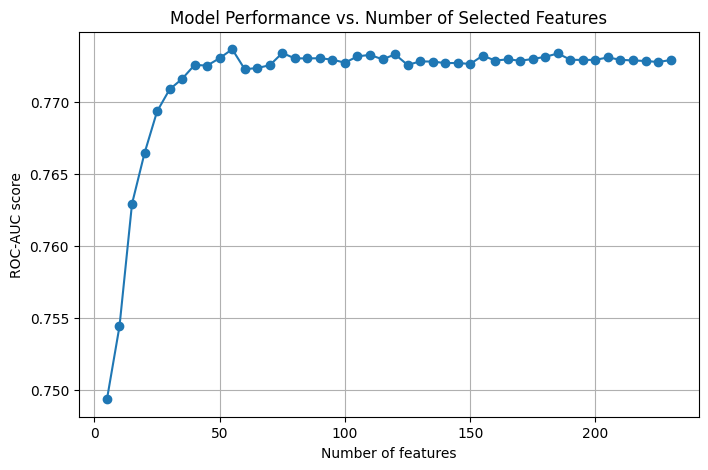

In [99]:
import matplotlib.pyplot as plt
# Extract x and y values
x = list(models_results.keys())
y = [float(v) for v in models_results.values()]  # ensure standard floats
# Plot
plt.figure(figsize=(8,5))
plt.plot(x, y, marker='o')
plt.xlabel("Number of features")
plt.ylabel("ROC-AUC score")
plt.title("Model Performance vs. Number of Selected Features")
plt.grid(True)
plt.show()

* based on this the top 55 features 

In [107]:
selected_columns = imp_df_gain.head(55)['feature'].to_list()
selected_columns.append('SK_ID_CURR')

In [ ]:
final_data = df[selected_columns]
target_data = train[['SK_ID_CURR', 'TARGET']]
final_data = final_data.merge(target_data, on='SK_ID_CURR', how='left')

In [111]:
final_data.to_csv('final_data_updated.csv', index=False)

In [6]:
final_data = pd.read_csv('final_data_updated.csv')

## credit_card

In [10]:
credit_card

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0           2562384      378907              -6       56.970   
1           2582071      363914              -1    63975.555   
2           1740877      371185              -7    31815.225   
3           1389973      337855              -4   236572.110   
4           1891521      126868              -1   453919.455   
...             ...         ...             ...          ...   
3840307     1036507      328243              -9        0.000   
3840308     1714892      347207              -9        0.000   
3840309     1302323      215757              -9   275784.975   
3840310     1624872      430337             -10        0.000   
3840311     2411345      236760             -10        0.000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                         135000                       0.0   
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       NaN   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       NaN   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                       877.5                         0.0   
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         NaN   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         NaN   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  \
0                           877.5                 1700.325   
1                             0.0                 2250.000   
2                             0.0                 2250.000   
3                             0.0                11795.760   
4                         11547.0                22924.890   
...                           ...                      ...   
3840307                       NaN                    0.000   
3840308                       0.0                    0.000   
3840309                       0.0                 2250.000   
3840310                       NaN                    0.000   
3840311                       0.0                    0.000   

         AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                    1800.00                   1800.000   
1                    2250.00                   2250.000   
2                    2250.00                   2250.000   
3                   11925.00                  11925.000   
4                   27000.00                  27000.000   
...                      ...                        ...   
3840307                  NaN                      0.000   
3840308              1879.11                      0.000   
3840309            375750.00                 356994.675   
3840310                  NaN                      0.000   
3840311                 0.00                      0.000   

         AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                           0.000          0.000                 0.000   
1                       60175.080      64875.555             64875.555   
2                       26926.425      31460.085             31460.085   
3           

In [9]:
pd.set_option('display.max_columns', None)   
pd.set_option('display.width', None)       
pd.set_option('display.max_colwidth', None)


In [20]:
num_cols

['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'SK_DPD',
 'SK_DPD_DEF']

In [25]:
# getting the categorical columns and the numerical columns 
num_cols = credit_card.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = ['NAME_CONTRACT_STATUS']
# remove the sk_id_curr and SK_ID_PREV
items_to_remove = ['SK_ID_PREV', 'SK_ID_CURR']
for item in items_to_remove:
    num_cols.remove(item)
num_cols

['MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'SK_DPD',
 'SK_DPD_DEF']

In [ ]:
num_aggs = credit_card.groupby('SK_ID_CURR')[num_cols].agg(['mean', 'max', 'min', 'sum', 'std'])
num_aggs.columns = ['_'.join(col).upper() for col in num_aggs.columns]

In [32]:
status_dummies = pd.get_dummies(credit_card[cat_cols], prefix='STATUS')
status_aggs  = credit_card[['SK_ID_CURR']].join(status_dummies)
status_aggs = status_aggs.groupby('SK_ID_CURR').sum()

In [42]:
most_freq = credit_card.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].agg(lambda x: x.mode()[0]).rename('MOST_FREQ_STATUS')

In [45]:
cat_aggs = status_aggs.join(most_freq)
cat_aggs

STATUS_Active  STATUS_Approved  STATUS_Completed  STATUS_Demand  \
SK_ID_CURR                                                                    
100006                  6                0                 0              0   
100011                 74                0                 0              0   
100013                 96                0                 0              0   
100021                  7                0                10              0   
100023                  8                0                 0              0   
...                   ...              ...               ...            ...   
456244                 36                0                 5              0   
456246                  8                0                 0              0   
456247                 95                0                 0              0   
456248                 23                0                 0              0   
456250                 12                0                 0              0   

            STATUS_Refused  STATUS_Sent proposal  STATUS_Signed  \
SK_ID_CURR                                                        
100006                   0                     0              0   
100011                   0                     0              0   
100013                   0                     0              0   
100021                   0                     0              0   
100023                   0                     0              0   
...                    ...                   ...            ...   
456244                   0                     0              0   
456246                   0                     0              0   
456247                   0                     0              0   
456248                   0                     0              0   
456250                   0                     0              0   

           MOST_FREQ_STATUS  
SK_ID_CURR                   
100006               Active  
100011               Active  
100013               Active  
100021            Completed  
100023               Active  
...                     ...  
456244               Active  
456246               Active  
456247               Active  
456248               Active  
456250               Active  

[103558 rows x 8 columns]

In [46]:
final_agg = num_aggs.join(cat_aggs, how='left')

In [48]:
df = final_data.copy()

In [49]:
df = df.merge(final_agg, on='SK_ID_CURR', how='left')

In [50]:
df

EXT_MEAN       ORGANIZATION_TYPE  ANNUITY_TO_CREDIT  CREDIT_TO_PRICE  \
0       0.161787  Business Entity Type 3           0.060749         1.158397   
1       0.466757                  School           0.027598         1.145199   
2       0.642739              Government           0.050000         1.000000   
3       0.650442  Business Entity Type 3           0.094941         1.052803   
4       0.322738                Religion           0.042623         1.000000   
...          ...                     ...                ...              ...   
307506  0.413601                Services           0.108198         1.132000   
307507  0.115992                     XNA           0.044524         1.198000   
307508  0.499536                  School           0.044239         1.158400   
307509  0.587593  Business Entity Type 1           0.054592         1.158394   
307510  0.518984  Business Entity Type 3           0.072767         1.000000   

        DEBT_RATIO   EXT_MIN  EXT_SOURCE_3  YEARS_EMPLOYED  AMT_ANNUITY_x  \
0         0.454595  0.083037      0.139376        1.745205        24700.5   
1         0.000000  0.311267           NaN        3.254795        35698.5   
2         0.000000  0.555912      0.729567        0.616438         6750.0   
3              NaN  0.650442           NaN        8.326027        29686.5   
4         0.000000  0.322738           NaN        8.323288        21865.5   
...            ...       ...           ...             ...            ...   
307506         NaN  0.145570           NaN        0.646575        27558.0   
307507         NaN  0.115992           NaN             NaN        12001.5   
307508    0.453493  0.218859      0.218859       21.701370        29979.0   
307509    0.000000  0.514163      0.661024       13.112329        20205.0   
307510    0.555116  0.113922      0.113922        3.457534        49117.5   

        PREV_REFUSED_RATIO  EXT_SOURCE_1  POS_SK_DPD_DEF_MEAN  \
0                 0.000000      0.083037             0.000000   
1                 0.000000      0.311267             0.000000   
2                 0.000000           NaN             0.000000   
3                 0.111111           NaN             0.000000   
4                 0.000000           NaN             0.000000   
...                    ...           ...                  ...   
307506            0.000000      0.145570             0.000000   
307507            0.000000           NaN             0.000000   
307508            0.000000      0.744026             0.294118   
307509            0.000000           NaN             0.000000   
307510            0.250000      0.734460             0.070423   

        PREV_AMT_DOWN_PAYMENT_MAX  POS_CNT_INSTALMENT_FUTURE_MEAN        AGE  \
0                             0.0                       15.000000  25.920548   
1                          6885.0                        5.785714  45.931507   
2                          4860.0                        2.250000  52.180822   
3                         66987.0                        8.650000  52.068493   
4                          3676.5                        8.969697  54.608219   
...                           ...                             ...        ...   
307506                        0.0                        4.375000  25.553425   
307507                     3456.0                        3.000000  56.917808   
307508                     5913.0                        2.000000  41.002740   
307509                        0.0                       10.350000  32.769863   
307510                     9000.0                       15.140845  46.180822   

       OCCUPATION_TYPE  AMT_CREDIT_SUM  ANNUITY_TO_PRICE  \
0             Laborers   108131.945625          0.070372   
1           Core staff   254350.125000          0.031606   
2             Laborers    94518.900000          0.050000   
3             Laborers             NaN          0.099955   
4           Core staff   146250.000000          0.042623   
...                .

## installments


In [51]:
installments

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
0            1054186      161674                     1.0   
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                             6          -1180.0             -1187.0   
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT  AMT_PAYMENT  
0               6948.360     6948.360  
1               1716.525     1716.525  
2              25425.000    25425.000  
3              24350.130    24350.130  
4               2165.040     2160.585  
...                  ...          ...  
13605396          67.500          NaN  
13605397          67.500          NaN  
13605398       43737.435          NaN  
13605399          67.500          NaN  
13605400       11504.250          NaN  

[13605401 rows x 8 columns]

In [52]:
# getting the categorical columns and the numerical columns 
num_cols = installments.select_dtypes(include=['int64', 'float64']).columns.tolist()
# remove the sk_id_curr and SK_ID_PREV
items_to_remove = ['SK_ID_PREV', 'SK_ID_CURR']
for item in items_to_remove:
    num_cols.remove(item)
num_cols

['NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT']

In [53]:
num_aggs = installments.groupby('SK_ID_CURR')[num_cols].agg(['mean', 'max', 'min', 'sum', 'std'])
num_aggs.columns = ['_'.join(col).upper() for col in num_aggs.columns]

In [54]:
num_aggs

NUM_INSTALMENT_VERSION_MEAN  NUM_INSTALMENT_VERSION_MAX  \
SK_ID_CURR                                                            
100001                         1.142857                         2.0   
100002                         1.052632                         2.0   
100003                         1.040000                         2.0   
100004                         1.333333                         2.0   
100005                         1.111111                         2.0   
...                                 ...                         ...   
456251                         1.142857                         2.0   
456252                         1.000000                         1.0   
456253                         1.000000                         1.0   
456254                         1.000000                         1.0   
456255                         1.824324                         4.0   

            NUM_INSTALMENT_VERSION_MIN  NUM_INSTALMENT_VERSION_SUM  \
SK_ID_CURR                                                           
100001                             1.0                         8.0   
100002                             1.0                        20.0   
100003                             1.0                        26.0   
100004                             1.0                         4.0   
100005                             1.0                        10.0   
...                                ...                         ...   
456251                             1.0                         8.0   
456252                             1.0                         6.0   
456253                             1.0                        14.0   
456254                             1.0                        19.0   
456255                             1.0                       135.0   

            NUM_INSTALMENT_VERSION_STD  NUM_INSTALMENT_NUMBER_MEAN  \
SK_ID_CURR                                                           
100001                        0.377964                    2.714286   
100002                        0.229416                   10.000000   
100003                        0.200000                    5.080000   
100004                        0.577350                    2.000000   
100005                        0.333333                    5.000000   
...                                ...                         ...   
456251                        0.377964                    4.000000   
456252                        0.000000                    3.500000   
456253                        0.000000                    4.785714   
456254                        0.000000                    5.263158   
456255                        0.970215                    8.851351   

            NUM_INSTALMENT_NUMBER_MAX  NUM_INSTALMENT_NUMBER_MIN  \
SK_ID_CURR                                                         
100001                              4                          1   
100002                             19                          1   
100003                             12                          1   
100004                              3                          1   
100005                              9                          1   
...                               ...                        ...   
456251                              7                          1   
456252                              6                          1   
456253                             12                          1   
456254                             10                          1   
456255                             24                          1   

            NUM_INSTALMENT_NUMBER_SUM  NUM_INSTALMENT_NUMBER_STD  \
SK_ID_CURR                                                         
100001                             19                   1.112697   
100002                            190                   5.627314   
100003                            127                   3.134751   
100004                              6    

In [55]:
df = df.merge(num_aggs, on='SK_ID_CURR', how='left')

## Feature selection for the last dataframe 


In [76]:
df

EXT_MEAN       ORGANIZATION_TYPE  ANNUITY_TO_CREDIT  CREDIT_TO_PRICE  \
0       0.161787  Business Entity Type 3           0.060749         1.158397   
1       0.466757                  School           0.027598         1.145199   
2       0.642739              Government           0.050000         1.000000   
3       0.650442  Business Entity Type 3           0.094941         1.052803   
4       0.322738                Religion           0.042623         1.000000   
...          ...                     ...                ...              ...   
307506  0.413601                Services           0.108198         1.132000   
307507  0.115992                     XNA           0.044524         1.198000   
307508  0.499536                  School           0.044239         1.158400   
307509  0.587593  Business Entity Type 1           0.054592         1.158394   
307510  0.518984  Business Entity Type 3           0.072767         1.000000   

        DEBT_RATIO   EXT_MIN  EXT_SOURCE_3  AMT_PAYMENT_MIN  YEARS_EMPLOYED  \
0         0.454595  0.083037      0.139376         9251.775        1.745205   
1         0.000000  0.311267           NaN         6662.970        3.254795   
2         0.000000  0.555912      0.729567         5357.250        0.616438   
3              NaN  0.650442           NaN         2482.920        8.326027   
4         0.000000  0.322738           NaN            0.180        8.323288   
...            ...       ...           ...              ...             ...   
307506         NaN  0.145570           NaN         6605.910        0.646575   
307507         NaN  0.115992           NaN        10046.880             NaN   
307508    0.453493  0.218859      0.218859           27.270       21.701370   
307509    0.000000  0.514163      0.661024         2296.440       13.112329   
307510    0.555116  0.113922      0.113922           34.965        3.457534   

        AMT_ANNUITY_x  PREV_REFUSED_RATIO  AMT_PAYMENT_SUM  EXT_SOURCE_1  \
0             24700.5            0.000000       219625.695      0.083037   
1             35698.5            0.000000      1618864.650      0.311267   
2              6750.0            0.000000        21288.465           NaN   
3             29686.5            0.111111      1007153.415           NaN   
4             21865.5            0.000000       806127.975           NaN   
...               ...                 ...              ...           ...   
307506        27558.0            0.000000        52450.470      0.145570   
307507        12001.5            0.000000        60419.205           NaN   
307508        29979.0            0.000000        57622.815      0.744026   
307509        20205.0            0.000000       194556.825           NaN   
307510        49117.5            0.250000      3525819.975      0.734460   

        POS_CNT_INSTALMENT_FUTURE_MEAN  POS_SK_DPD_DEF_MEAN  ANNUITY_TO_PRICE  \
0                            15.000000             0.000000          0.070372   
1                             5.785714             0.000000          0.031606   
2                             2.250000             0.000000          0.050000   
3                             8.650000             0.000000          0.099955   
4                             8.969697             0.000000          0.042623   
...                                ...                  ...               ...   
307506                        4.375000             0.000000          0.122480   
307507                        3.000000             0.000000          0.053340   
307508                        2.000000             0.294118          0.051246   
307509                       10.350000             0.000000          0.063239   
307510                       15.140845             0.070423          0.072767   

       OCCUPATION_TYPE        AGE  CNT_DRAWINGS_ATM_CURRENT_MEAN  \
0             Laborers  25.920548                            NaN   
1           Core staff  45.931507                            NaN   
2       

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [59]:
import re
df.columns = [re.sub(r'[^0-9a-zA-Z_]+', '_', c) for c in df.columns]

In [60]:
# using baseline model with all features 
X = df.drop(columns=['TARGET'])
y = df['TARGET']
prev_model = LGBMClassifier(random_state=42)
scores_full_2 = cross_val_score(
    prev_model,
    X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
print("Baseline AUC:", scores_full_2.mean())

Baseline AUC: 0.7781725456050314


In [61]:
new_prev_model_1 = LGBMClassifier()
new_prev_model_1.fit(X, y)
booster = new_prev_model_1.booster_
importance_gain = booster.feature_importance(importance_type='gain')

imp_df_gain = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance_gain': importance_gain
}).sort_values(by='importance_gain', ascending=False)
imp_df_gain

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39066
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


feature  importance_gain
0                      EXT_MEAN     70879.672978
1             ORGANIZATION_TYPE      9464.332289
2             ANNUITY_TO_CREDIT      4814.271510
3               CREDIT_TO_PRICE      4417.525029
4                    DEBT_RATIO      4031.922410
..                          ...              ...
157             STATUS_Approved         0.000000
154              SK_DPD_DEF_SUM         0.000000
162               STATUS_Signed         0.000000
166  NUM_INSTALMENT_VERSION_MIN         0.000000
163            MOST_FREQ_STATUS         0.000000

[194 rows x 2 columns]

In [63]:
imp_df_gain = imp_df_gain[imp_df_gain['importance_gain'] > 0]
imp_df_gain

feature  importance_gain
0                          EXT_MEAN     70879.672978
1                 ORGANIZATION_TYPE      9464.332289
2                 ANNUITY_TO_CREDIT      4814.271510
3                   CREDIT_TO_PRICE      4417.525029
4                        DEBT_RATIO      4031.922410
..                              ...              ...
143   CNT_INSTALMENT_MATURE_CUM_MIN        15.764400
152                  SK_DPD_DEF_MAX        15.158700
84   AMT_DRAWINGS_OTHER_CURRENT_SUM        12.679100
171       NUM_INSTALMENT_NUMBER_MIN        12.158200
123    CNT_DRAWINGS_ATM_CURRENT_MIN        10.492000

[167 rows x 2 columns]

In [66]:
features = [5]
while features[-1] <  imp_df_gain.shape[0]:
    new_item = features[-1] + 5
    features.append(new_item)
features

[5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170]

In [67]:
# training the model with different number of features to show the model
models_results = {}
for num_features in features:
    top_features = imp_df_gain.head(num_features)['feature'].tolist()
    print(top_features)
    X_top = X[top_features]
    model_top = LGBMClassifier(random_state=42)
    scores_top = cross_val_score(
    model_top,
    X_top, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
    )
    models_results[num_features] = scores_top.mean()

['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO', 'EXT_MIN', 'EXT_SOURCE_3', 'AMT_PAYMENT_MIN', 'YEARS_EMPLOYED', 'AMT_ANNUITY_x']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO', 'EXT_MIN', 'EXT_SOURCE_3', 'AMT_PAYMENT_MIN', 'YEARS_EMPLOYED', 'AMT_ANNUITY_x', 'PREV_REFUSED_RATIO', 'AMT_PAYMENT_SUM', 'EXT_SOURCE_1', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'POS_SK_DPD_DEF_MEAN']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO', 'EXT_MIN', 'EXT_SOURCE_3', 'AMT_PAYMENT_MIN', 'YEARS_EMPLOYED', 'AMT_ANNUITY_x', 'PREV_REFUSED_RATIO', 'AMT_PAYMENT_SUM', 'EXT_SOURCE_1', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'POS_SK_DPD_DEF_MEAN', 'ANNUITY_TO_PRICE', 'OCCUPATION_TYPE', 'AGE', 'CNT_DRAWINGS_ATM_CURRENT_MEAN', 'NAME_EDUCATION_TYPE']
['EXT_MEAN', 'ORGANIZATION_TYPE', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', '

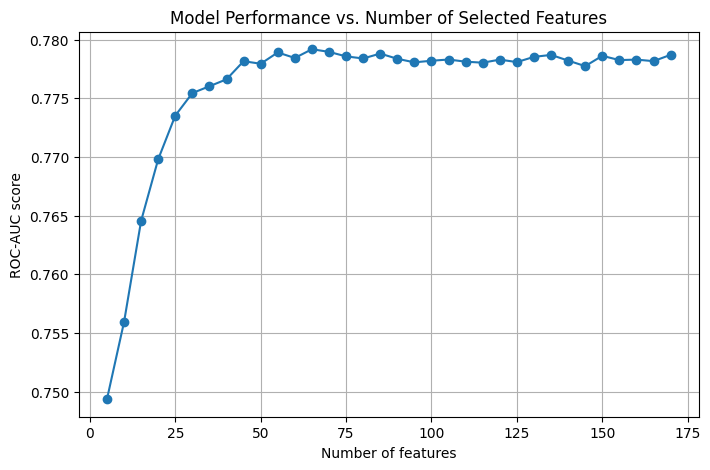

In [68]:
import matplotlib.pyplot as plt
# Extract x and y values
x = list(models_results.keys())
y = [float(v) for v in models_results.values()]  # ensure standard floats
# Plot
plt.figure(figsize=(8,5))
plt.plot(x, y, marker='o')
plt.xlabel("Number of features")
plt.ylabel("ROC-AUC score")
plt.title("Model Performance vs. Number of Selected Features")
plt.grid(True)
plt.show()

* based on this graph the most important features that first 65

EXT_MEAN       ORGANIZATION_TYPE  ANNUITY_TO_CREDIT  CREDIT_TO_PRICE  \
0       0.161787  Business Entity Type 3           0.060749         1.158397   
1       0.466757                  School           0.027598         1.145199   
2       0.642739              Government           0.050000         1.000000   
3       0.650442  Business Entity Type 3           0.094941         1.052803   
4       0.322738                Religion           0.042623         1.000000   
...          ...                     ...                ...              ...   
307506  0.413601                Services           0.108198         1.132000   
307507  0.115992                     XNA           0.044524         1.198000   
307508  0.499536                  School           0.044239         1.158400   
307509  0.587593  Business Entity Type 1           0.054592         1.158394   
307510  0.518984  Business Entity Type 3           0.072767         1.000000   

        DEBT_RATIO   EXT_MIN  EXT_SOURCE_3  AMT_PAYMENT_MIN  YEARS_EMPLOYED  \
0         0.454595  0.083037      0.139376         9251.775        1.745205   
1         0.000000  0.311267           NaN         6662.970        3.254795   
2         0.000000  0.555912      0.729567         5357.250        0.616438   
3              NaN  0.650442           NaN         2482.920        8.326027   
4         0.000000  0.322738           NaN            0.180        8.323288   
...            ...       ...           ...              ...             ...   
307506         NaN  0.145570           NaN         6605.910        0.646575   
307507         NaN  0.115992           NaN        10046.880             NaN   
307508    0.453493  0.218859      0.218859           27.270       21.701370   
307509    0.000000  0.514163      0.661024         2296.440       13.112329   
307510    0.555116  0.113922      0.113922           34.965        3.457534   

        AMT_ANNUITY_x  PREV_REFUSED_RATIO  AMT_PAYMENT_SUM  EXT_SOURCE_1  \
0             24700.5            0.000000       219625.695      0.083037   
1             35698.5            0.000000      1618864.650      0.311267   
2              6750.0            0.000000        21288.465           NaN   
3             29686.5            0.111111      1007153.415           NaN   
4             21865.5            0.000000       806127.975           NaN   
...               ...                 ...              ...           ...   
307506        27558.0            0.000000        52450.470      0.145570   
307507        12001.5            0.000000        60419.205           NaN   
307508        29979.0            0.000000        57622.815      0.744026   
307509        20205.0            0.000000       194556.825           NaN   
307510        49117.5            0.250000      3525819.975      0.734460   

        POS_CNT_INSTALMENT_FUTURE_MEAN  POS_SK_DPD_DEF_MEAN  ANNUITY_TO_PRICE  \
0                            15.000000             0.000000          0.070372   
1                             5.785714             0.000000          0.031606   
2                             2.250000             0.000000          0.050000   
3                             8.650000             0.000000          0.099955   
4                             8.969697             0.000000          0.042623   
...                                ...                  ...               ...   
307506                        4.375000             0.000000          0.122480   
307507                        3.000000             0.000000          0.053340   
307508                        2.000000             0.294118          0.051246   
307509                       10.350000             0.000000          0.063239   
307510                       15.140845             0.070423          0.072767   

       OCCUPATION_TYPE        AGE  CNT_DRAWINGS_ATM_CURRENT_MEAN  \
0             Laborers  25.920548                            NaN   
1           Core staff  45.931507                            NaN   
2       

In [78]:
selected_features = imp_df_gain.head(65)['feature'].to_list()
selected_features.append('SK_ID_CURR')
df = X[selected_features]
target = train[['TARGET', 'SK_ID_CURR']]
final_df = df.merge(target, on='SK_ID_CURR', how= 'left')

In [83]:
final_df.to_csv('final_df.csv', index=False)

## now we are finished from the feature selection process we need to work on the existed features 

In [134]:
final_df = pd.read_csv('final_df.csv')

In [135]:
working_df= final_df.copy()

In [136]:
# we will drop columns that contains more than 70% nulls 
columns_to_drop = nulls_df(final_df)[nulls_df(final_df)['Nulls_Percentage'] > 70]['Column'].to_list()

In [137]:
working_df.drop(columns_to_drop, axis=1, inplace= True)

In [138]:
nulls_df(working_df)[nulls_df(working_df)['Nulls_Percentage'] > 0].sort_values(by='Nulls_Percentage', ascending=False)

Column  Nulls_Count  Nulls_Percentage  \
24                                OWN_CAR_AGE       202929         65.990810   
34                             CAR_AGE_TO_AGE       202929         65.990810   
12                               EXT_SOURCE_1       173378         56.381073   
42                             TOTALAREA_MODE       148431         48.268517   
52                               AREA_PER_POP       148431         48.268517   
21                     AMT_CREDIT_MAX_OVERDUE       123648         40.209293   
16                            OCCUPATION_TYPE        96391         31.345545   
6                                EXT_SOURCE_3        60965         19.825307   
8                              YEARS_EMPLOYED        55374         18.007161   
43                        DAYS_CREDIT_ENDDATE        46292         15.053770   
19                             AMT_CREDIT_SUM        44044         14.322740   
4                                  DEBT_RATIO        44043         14.322414   
36                                LIMIT_USAGE        44043         14.322414   
35                               Years_Credit        44043         14.322414   
20                  PREV_AMT_DOWN_PAYMENT_MAX        33906         11.025947   
13             POS_CNT_INSTALMENT_FUTURE_MEAN        18091          5.883042   
39                     POS_CNT_INSTALMENT_MAX        18091          5.883042   
14                        POS_SK_DPD_DEF_MEAN        18067          5.875237   
51                      PREV_AMT_ANNUITY_MEAN        16871          5.486308   
23                      PREV_CNT_PAYMENT_MEAN        16869          5.485657   
33                       PREV_CNT_PAYMENT_MAX        16869          5.485657   
46                     DAYS_ENTRY_PAYMENT_STD        16564          5.386474   
54                  NUM_INSTALMENT_NUMBER_STD        16560          5.385173   
49                 NUM_INSTALMENT_VERSION_STD        16560          5.385173   
60                         AMT_INSTALMENT_STD        16560          5.385173   
25                        DAYS_INSTALMENT_STD        16560          5.385173   
53   PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN        16454          5.350703   
41  PRODUCT_COMBINATION_Cash_Street_high_MEAN        16454          5.350703   
45                        PREV_APPROVED_RATIO        16454          5.350703   
10                         PREV_REFUSED_RATIO        16454          5.350703   
50  PRODUCT_COMBINATION_Cash_X_Sell_high_MEAN        16454          5.350703   
28                           AMT_PAYMENT_MEAN        15876          5.162742   
55                            AMT_PAYMENT_MAX        15876          5.162742   
32                     DAYS_ENTRY_PAYMENT_MAX        15876          5.162742   
7                             AMT_PAYMENT_MIN        15876          5.162742   
11                            AMT_PAYMENT_SUM        15868          5.160141   
31                        DAYS_INSTALMENT_MIN        15868          5.160141   
58                 NUM_INSTALMENT_VERSION_SUM        15868          5.160141   
57                        DAYS_INSTALMENT_SUM        15868          5.160141   
48                  NUM_INSTALMENT_NUMBER_MAX        15868          5.160141   
44                        DAYS_INSTALMENT_MAX        15868          5.160141   
56                         AMT_INSTALMENT_MAX        15868          5.160141   
47               DEF_30_CNT_SOCIAL_CIRCLE_CAT         1021          0.332021   
37                               EXT_SOURCE_2          660          0.214626   
15                           ANNUITY_TO_PRICE          290          0.094306   
3                             CREDIT_TO_PRICE          278          0.090403   
26                            AMT_GOODS_PRICE          278          0.090403   
5                                     EXT_MIN          172          0.055933   
0                                    EXT_MEAN          172          0.055933   
27                                    E

<Axes: xlabel='TARGET', ylabel='OWN_CAR_AGE'>

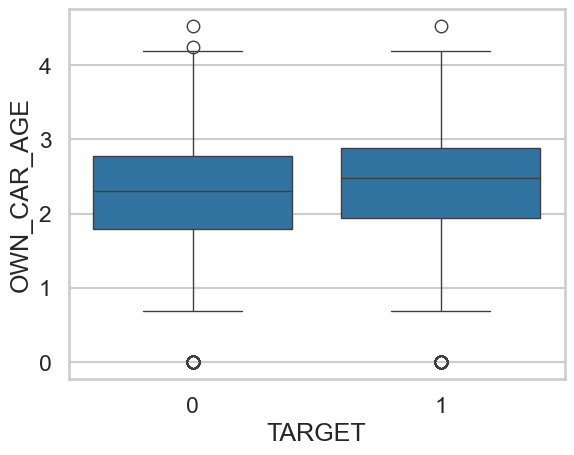

In [139]:
sns.boxplot(data=working_df, x='TARGET',y=np.log1p(working_df['OWN_CAR_AGE']))

### OWN_CAR_AGE

* based on this people has old cars will defualt more so then the people has younger cars 
* the missing valus means that the client has no car so we can create a flag to tell the model if the user has a car or not  

In [140]:
working_df['OWN_CAR_AGE_MISSING'] = working_df['OWN_CAR_AGE'].isna().astype(int)
# THIS IMPUTE THE NAN WITH ZERO BECUASE THE CLIENT HAS NO CAR 
working_df['OWN_CAR_AGE'] = working_df['OWN_CAR_AGE'].fillna(0)

In [141]:
# THE SAME WE CAN DO WITH CAR_AGE_TO_AGE 
# THIS IMPUTE THE NAN WITH ZERO BECUASE THE CLIENT HAS NO CAR 
working_df['CAR_AGE_TO_AGE'] = working_df['CAR_AGE_TO_AGE'].fillna(0)

### EXT_SOURCE_1

* the EXT_SOURCE_1 feature is very important and so we can use knn to impute the values 

In [142]:
# we can use unsupervised learning approach to impute the null valus 
from sklearn.impute import KNNImputer
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
imputer = KNNImputer(n_neighbors=5)
working_df[cols] = imputer.fit_transform(working_df[cols])

In [145]:
working_df.to_csv('imputed_ext_sour.csv', index=False)

In [182]:
working_df= pd.read_csv('imputed_ext_sour.csv')

### TOTALAREA_MODE

<Axes: xlabel='TARGET', ylabel='AREA_PER_POP'>

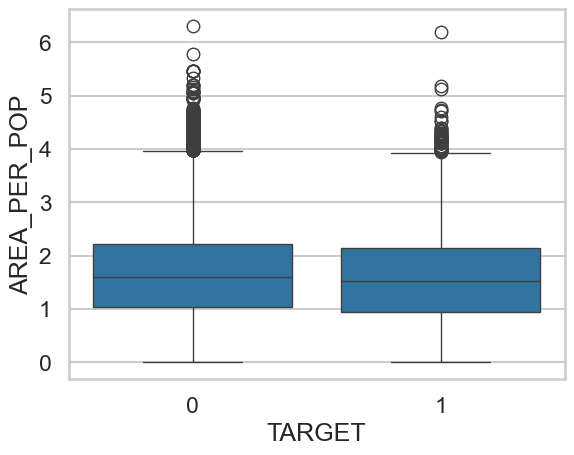

In [164]:
sns.boxplot(data=working_df, x='TARGET',y=np.log1p(working_df['AREA_PER_POP']))

* people that has low total_area_per_population tends to defualt
* Treat 0 (and NaN) as “missing” because there is not logic to be 0

In [184]:
# Copy column
working_df['AREA_PER_POP_IMPUTED'] = working_df['AREA_PER_POP']
working_df['AREA_PER_POP_MISSING'] = (
    working_df['AREA_PER_POP_IMPUTED'].isna() |
    (working_df['AREA_PER_POP_IMPUTED'] == 0)
).astype(int)
working_df['AREA_PER_POP_IMPUTED'] = working_df['AREA_PER_POP_IMPUTED'].replace(0, np.nan)
median_area = working_df['AREA_PER_POP_IMPUTED'].median()
working_df['AREA_PER_POP_IMPUTED'] = working_df['AREA_PER_POP_IMPUTED'].fillna(median_area)

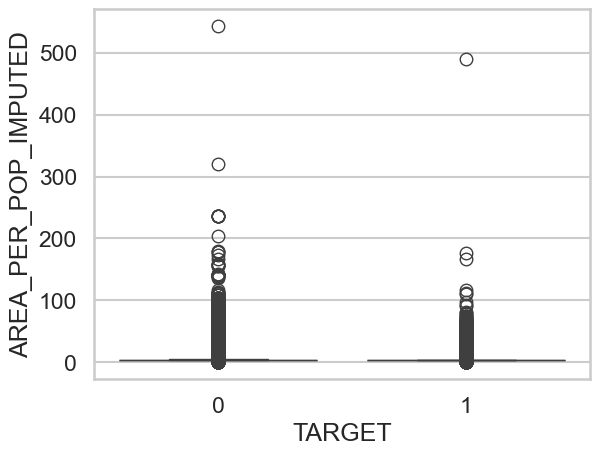

In [188]:
sns.boxplot(
    data=working_df,
    x='TARGET',
    y='AREA_PER_POP_IMPUTED'
)
plt.show()

In [189]:
working_df['TOTALAREA_MODE_IMPUTED'] = working_df['TOTALAREA_MODE']
working_df['TOTALAREA_MODE_IMPUTED'] = working_df['TOTALAREA_MODE_IMPUTED'].replace(0, np.nan)
median_area = working_df['TOTALAREA_MODE_IMPUTED'].median()
working_df['TOTALAREA_MODE_IMPUTED'] = working_df['TOTALAREA_MODE_IMPUTED'].fillna(median_area)

### AMT_CREDIT_MAX_OVERDUE

In [193]:
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                           NaN                   0        91323.00   
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                        0.0                   NaN                     0.0   
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

* based on the information from the previous tabel (The client never had overdue credit → therefore the max overdue amount = 0.)

In [194]:
# Flag if the client EVER had overdue
working_df['AMT_CREDIT_MAX_OVERDUE_FLAG'] = working_df['AMT_CREDIT_MAX_OVERDUE'].notna().astype(int)

# Replace NaN with 0 (meaning no overdue)
working_df['AMT_CREDIT_MAX_OVERDUE'] = working_df['AMT_CREDIT_MAX_OVERDUE'].fillna(0)

### OCCUPATION_TYPE

In [196]:
mode_0 = working_df.loc[working_df['TARGET'] == 0, 'OCCUPATION_TYPE'].mode()[0]
mode_1 = working_df.loc[working_df['TARGET'] == 1, 'OCCUPATION_TYPE'].mode()[0]
mask_0 = (working_df['TARGET'] == 0) & (working_df['OCCUPATION_TYPE'].isna())
working_df.loc[mask_0, 'OCCUPATION_TYPE'] = mode_0
mask_1 = (working_df['TARGET'] == 1) & (working_df['OCCUPATION_TYPE'].isna())
working_df.loc[mask_1, 'OCCUPATION_TYPE'] = mode_1

### YEARS_EMPLOYED

* in YEARS_EMPLOYED if it is null that means this client is not employed 

In [202]:
working_df['YEARS_EMPLOYED_MISSING'] = working_df['YEARS_EMPLOYED'].isna().astype(int)

In [201]:
working_df[working_df['YEARS_EMPLOYED'].isna()]['TARGET'].value_counts()

TARGET
0    52384
1     2990
Name: count, dtype: int64

In [203]:
working_df['YEARS_EMPLOYED'] = working_df['YEARS_EMPLOYED'].fillna(0)


### DAYS_CREDIT_ENDDATE

* The client has an open-ended loan with no fixed end date so this is meaningful 

In [ ]:
working_df['DAYS_CREDIT_ENDDATE_MISSING'] = working_df['DAYS_CREDIT_ENDDATE'].isna().astype(int)
working_df['DAYS_CREDIT_ENDDATE'] = working_df['DAYS_CREDIT_ENDDATE'].fillna(0)

### ['AMT_CREDIT_SUM', 'DEBT_RATIO', 'LIMIT_USAGE', 'Years_Credit']

* The client never had a credit card

* The credit bureau has no record for that client

In [ ]:
for col in ['AMT_CREDIT_SUM', 'DEBT_RATIO', 'LIMIT_USAGE', 'Years_Credit']:
    working_df[col + '_MISSING'] = working_df[col].isna().astype(int)
working_df[['AMT_CREDIT_SUM', 'DEBT_RATIO', 'LIMIT_USAGE', 'Years_Credit']] = \
working_df[['AMT_CREDIT_SUM', 'DEBT_RATIO', 'LIMIT_USAGE', 'Years_Credit']].fillna(0)

### previous loan / POS / installments

* the client has no previous loans of this type

In [214]:
selected_cols = [
    'PREV_AMT_DOWN_PAYMENT_MAX',
    'POS_CNT_INSTALMENT_FUTURE_MEAN',
    'POS_CNT_INSTALMENT_MAX',
    'POS_SK_DPD_DEF_MEAN',
    'PREV_AMT_ANNUITY_MEAN',
    'PREV_CNT_PAYMENT_MAX',
    'PREV_CNT_PAYMENT_MEAN',
    'DAYS_ENTRY_PAYMENT_STD',
    'NUM_INSTALMENT_NUMBER_STD',
    'NUM_INSTALMENT_VERSION_STD',
    'DAYS_INSTALMENT_STD',
    'AMT_INSTALMENT_STD',
    'PRODUCT_COMBINATION_Cash_Street_high_MEAN',
    'PRODUCT_COMBINATION_Cash_X_Sell_high_MEAN',
    'PREV_APPROVED_RATIO',
    'PREV_REFUSED_RATIO',
    'PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN',
    'AMT_PAYMENT_MAX',
    'AMT_PAYMENT_MEAN',
    'AMT_PAYMENT_MIN',
    'DAYS_ENTRY_PAYMENT_MAX',
    'AMT_PAYMENT_SUM',
    'NUM_INSTALMENT_VERSION_SUM',
    'DAYS_INSTALMENT_SUM',
    'NUM_INSTALMENT_NUMBER_MAX',
    'DAYS_INSTALMENT_MIN',
    'DAYS_INSTALMENT_MAX',
    'AMT_INSTALMENT_MAX'
]

In [216]:
working_df[selected_cols] = working_df[selected_cols].fillna(0)


In [215]:
for col in selected_cols:  
    working_df[col + "_MISSING"] = working_df[col].isna().astype(int)


In [218]:
cols_to_drop_rows = [
    'DEF_30_CNT_SOCIAL_CIRCLE_CAT',
    'ANNUITY_TO_PRICE',
    'AMT_GOODS_PRICE',
    'CREDIT_TO_PRICE',
    'EXT_MAX',
    'EXT_MEAN',
    'EXT_STD',
    'EXT_MIN',
    'ANNUITY_TO_CREDIT',
    'AMT_ANNUITY_x'
]


In [219]:
working_df = working_df.dropna(subset=cols_to_drop_rows)


In [209]:
working_df.drop(['AREA_PER_POP', 'TOTALAREA_MODE'], axis=1 , inplace = True)

In [220]:
nulls_df(working_df)[nulls_df(working_df)['Nulls_Percentage'] > 0].sort_values(by='Nulls_Percentage', ascending=False)

Empty DataFrame
Columns: [Column, Nulls_Count, Nulls_Percentage, Type]
Index: []

In [223]:
working_df.to_csv('imputed_datafram.csv', index=False)

In [64]:
working_df = pd.read_csv('imputed_datafram.csv')

In [65]:
working_df

EXT_MEAN       ORGANIZATION_TYPE  ANNUITY_TO_CREDIT  CREDIT_TO_PRICE  \
0       0.161787  Business Entity Type 3           0.060749         1.158397   
1       0.466757                  School           0.027598         1.145199   
2       0.642739              Government           0.050000         1.000000   
3       0.650442  Business Entity Type 3           0.094941         1.052803   
4       0.322738                Religion           0.042623         1.000000   
...          ...                     ...                ...              ...   
306025  0.413601                Services           0.108198         1.132000   
306026  0.115992                     XNA           0.044524         1.198000   
306027  0.499536                  School           0.044239         1.158400   
306028  0.587593  Business Entity Type 1           0.054592         1.158394   
306029  0.518984  Business Entity Type 3           0.072767         1.000000   

        DEBT_RATIO   EXT_MIN  EXT_SOURCE_3  AMT_PAYMENT_MIN  YEARS_EMPLOYED  \
0         0.454595  0.083037      0.139376         9251.775        1.745205   
1         0.000000  0.311267      0.598382         6662.970        3.254795   
2         0.000000  0.555912      0.729567         5357.250        0.616438   
3         0.000000  0.650442      0.392835         2482.920        8.326027   
4         0.000000  0.322738      0.629947            0.180        8.323288   
...            ...       ...           ...              ...             ...   
306025    0.000000  0.145570      0.387374         6605.910        0.646575   
306026    0.000000  0.115992      0.440857        10046.880        0.000000   
306027    0.453493  0.218859      0.218859           27.270       21.701370   
306028    0.000000  0.514163      0.661024         2296.440       13.112329   
306029    0.555116  0.113922      0.113922           34.965        3.457534   

        AMT_ANNUITY_x  ...  AMT_PAYMENT_MEAN_MISSING  AMT_PAYMENT_MIN_MISSING  \
0             24700.5  ...                         0                        0   
1             35698.5  ...                         0                        0   
2              6750.0  ...                         0                        0   
3             29686.5  ...                         0                        0   
4             21865.5  ...                         0                        0   
...               ...  ...                       ...                      ...   
306025        27558.0  ...                         0                        0   
306026        12001.5  ...                         0                        0   
306027        29979.0  ...                         0                        0   
306028        20205.0  ...                         0                        0   
306029        49117.5  ...                         0                        0   

        DAYS_ENTRY_PAYMENT_MAX_MISSING  AMT_PAYMENT_SUM_MISSING  \
0                                    0                        0   
1                                    0                        0   
2                                    0                        0   
3                                    0                        0   
4                                    0                        0   
...                                ...                      ...   
306025                               0                        0   
306026                               0                        0   
306027                               0                        0   
306028                               0                        0   
306029                               0                        0   

        NUM_INSTALMENT_VERSION_SUM_MISSING  DAYS_INSTALMENT_SUM_MISSING  \
0                                        0                            0   
1                                        0                            0   
2                                        0                            0   
3                   

In [66]:
X = working_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = working_df['TARGET']


In [73]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [75]:
X

EXT_MEAN       ORGANIZATION_TYPE  ANNUITY_TO_CREDIT  CREDIT_TO_PRICE  \
0       0.161787  Business Entity Type 3           0.060749         1.158397   
1       0.466757                  School           0.027598         1.145199   
2       0.642739              Government           0.050000         1.000000   
3       0.650442  Business Entity Type 3           0.094941         1.052803   
4       0.322738                Religion           0.042623         1.000000   
...          ...                     ...                ...              ...   
306025  0.413601                Services           0.108198         1.132000   
306026  0.115992                     XNA           0.044524         1.198000   
306027  0.499536                  School           0.044239         1.158400   
306028  0.587593  Business Entity Type 1           0.054592         1.158394   
306029  0.518984  Business Entity Type 3           0.072767         1.000000   

        DEBT_RATIO   EXT_MIN  EXT_SOURCE_3  AMT_PAYMENT_MIN  YEARS_EMPLOYED  \
0         0.454595  0.083037      0.139376         9251.775        1.745205   
1         0.000000  0.311267      0.598382         6662.970        3.254795   
2         0.000000  0.555912      0.729567         5357.250        0.616438   
3         0.000000  0.650442      0.392835         2482.920        8.326027   
4         0.000000  0.322738      0.629947            0.180        8.323288   
...            ...       ...           ...              ...             ...   
306025    0.000000  0.145570      0.387374         6605.910        0.646575   
306026    0.000000  0.115992      0.440857        10046.880        0.000000   
306027    0.453493  0.218859      0.218859           27.270       21.701370   
306028    0.000000  0.514163      0.661024         2296.440       13.112329   
306029    0.555116  0.113922      0.113922           34.965        3.457534   

        AMT_ANNUITY_x  ...  AMT_PAYMENT_MEAN_MISSING  AMT_PAYMENT_MIN_MISSING  \
0             24700.5  ...                         0                        0   
1             35698.5  ...                         0                        0   
2              6750.0  ...                         0                        0   
3             29686.5  ...                         0                        0   
4             21865.5  ...                         0                        0   
...               ...  ...                       ...                      ...   
306025        27558.0  ...                         0                        0   
306026        12001.5  ...                         0                        0   
306027        29979.0  ...                         0                        0   
306028        20205.0  ...                         0                        0   
306029        49117.5  ...                         0                        0   

        DAYS_ENTRY_PAYMENT_MAX_MISSING  AMT_PAYMENT_SUM_MISSING  \
0                                    0                        0   
1                                    0                        0   
2                                    0                        0   
3                                    0                        0   
4                                    0                        0   
...                                ...                      ...   
306025                               0                        0   
306026                               0                        0   
306027                               0                        0   
306028                               0                        0   
306029                               0                        0   

        NUM_INSTALMENT_VERSION_SUM_MISSING  DAYS_INSTALMENT_SUM_MISSING  \
0                                        0                            0   
1                                        0                            0   
2                                        0                            0   
3                   

In [72]:

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [14]:
clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        class_weight='balanced'
    ))
])


In [55]:
clf.fit(X_train, y_train)


d:\Data Science Projects\Home Credit Default Risk\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['EXT_MEAN', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO',
       'EXT_MIN', 'EXT_SOURCE_3', 'AMT_PAYMENT_MIN', 'YEARS_EMPLOYED',
       'AMT_ANNUITY_x', 'PREV_REFUSED_RATIO', 'AMT_PAYMENT_SUM',
       'EXT_SOURCE_1', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'POS_SK_DPD_DEF_MEAN',
       'ANNUITY_T...
       'DAYS_INSTALMENT_SUM_MISSING', 'NUM_INSTALMENT_NUMBER_MAX_MISSING',
       'DAYS_INSTALMENT_MIN_MISSING', 'DAYS_INSTALMENT_MAX_MISSING',
       'AMT_INSTALMENT_MAX_MISSING'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE',
       'CODE_GENDER', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT'],
      dtype='object'))])),
                ('model', LogisticRegression(class_weight='balanced'))])

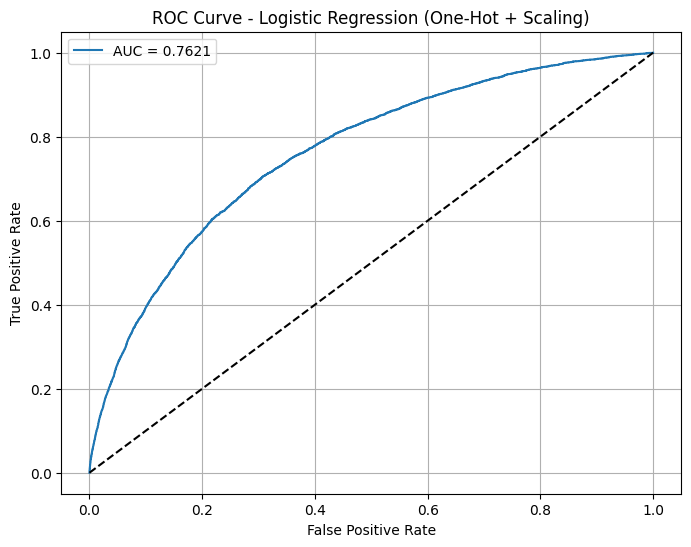

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# predict probability of class 1
y_prob = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (One-Hot + Scaling)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
preprocess = ColumnTransformer(
    transformers=[
        ('num','passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,         
        min_samples_leaf=1,     
        class_weight='balanced',
        n_jobs=-1,           
        random_state=42
    ))
])


In [17]:
rf_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['EXT_MEAN', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO',
       'EXT_MIN', 'EXT_SOURCE_3', 'AMT_PAYMENT_MIN', 'YEARS_EMPLOYED',
       'AMT_ANNUITY_x', 'PREV_REFUSED_RATIO', 'AMT_PAYMENT_SUM',
       'EXT_SOURCE_1', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'POS_SK_DPD_DEF_MEAN',
       'ANNUITY_TO_P...
       'DAYS_INSTALMENT_MIN_MISSING', 'DAYS_INSTALMENT_MAX_MISSING',
       'AMT_INSTALMENT_MAX_MISSING'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE',
       'CODE_GENDER', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

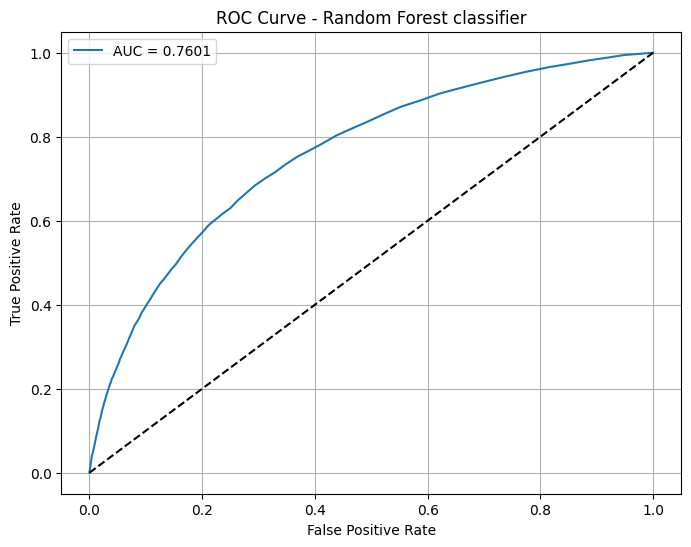

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# predict probability of class 1
y_prob = rf_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest classifier")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from xgboost import XGBClassifier
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos


In [23]:
xgb_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',          # fast for large data
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    ))
])

In [24]:
xgb_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['EXT_MEAN', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO',
       'EXT_MIN', 'EXT_SOURCE_3', 'AMT_PAYMENT_MIN', 'YEARS_EMPLOYED',
       'AMT_ANNUITY_x', 'PREV_REFUSED_RATIO', 'AMT_PAYMENT_SUM',
       'EXT_SOURCE_1', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'POS_SK_DPD_DEF_MEAN',
       'ANNUITY_TO_P...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

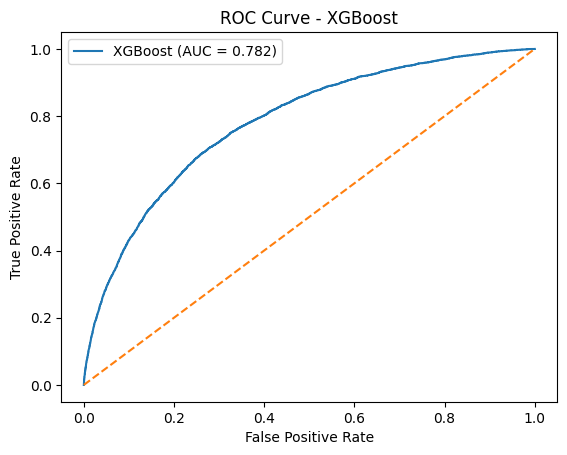

In [25]:
y_prob = xgb_clf.predict_proba(X_test)[:, 1]   # prob of class 1

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

### checking the unimputed df to see which one gets better 

In [26]:
final_df = pd.read_csv('final_data_updated.csv')

In [30]:
X = final_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = final_df['TARGET']


In [31]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [33]:
preprocess = ColumnTransformer(
    transformers=[
        ('num','passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [34]:
xgb_clf_2 = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',          # fast for large data
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    ))
])

In [35]:
xgb_clf_2.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['EXT_MEAN', 'ANNUITY_TO_CREDIT', 'CREDIT_TO_PRICE', 'DEBT_RATIO',
       'EXT_MIN', 'EXT_SOURCE_3', 'YEARS_EMPLOYED', 'AMT_ANNUITY_x',
       'PREV_REFUSED_RATIO', 'EXT_SOURCE_1', 'POS_SK_DPD_DEF_MEAN',
       'PREV_AMT_DOWN_PAYMENT_MAX', 'POS_CNT_INSTALMENT_FUTURE_MEAN', 'AGE',
       'AMT_CREDIT_SUM...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

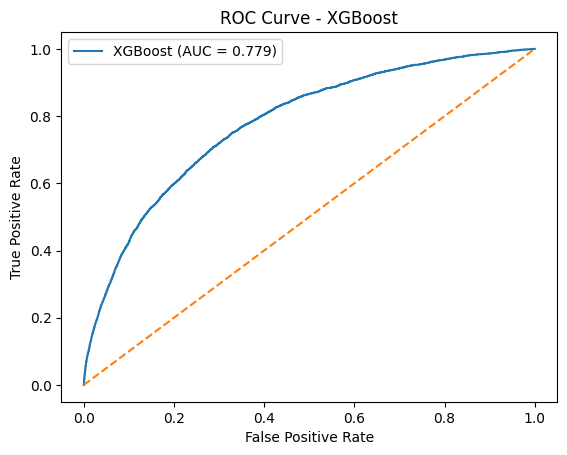

In [37]:
y_prob = xgb_clf_2.predict_proba(X_test)[:, 1]   # prob of class 1

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

* the final decision our imputing imporved the model performance 

### getting back for our imputed dataset

### catboosting

In [44]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Data Science Projects\Home Credit Default Risk\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [47]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=800,           # number of boosting rounds
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',  # handle imbalance
    random_state=42,
    verbose=100               # prints progress every 100 iters
)


In [83]:
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical features:", cat_features)


Categorical features: ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'DEF_30_CNT_SOCIAL_CIRCLE_CAT']


In [50]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=100
)


0:	test: 0.7174455	best: 0.7174455 (0)	total: 522ms	remaining: 6m 56s
100:	test: 0.7647078	best: 0.7647078 (100)	total: 31.7s	remaining: 3m 39s
200:	test: 0.7724416	best: 0.7724416 (200)	total: 1m 5s	remaining: 3m 14s
300:	test: 0.7769679	best: 0.7769679 (300)	total: 1m 43s	remaining: 2m 51s
400:	test: 0.7799080	best: 0.7799231 (399)	total: 2m 14s	remaining: 2m 13s
500:	test: 0.7809888	best: 0.7809888 (500)	total: 2m 44s	remaining: 1m 38s
600:	test: 0.7819757	best: 0.7820251 (597)	total: 3m 14s	remaining: 1m 4s
700:	test: 0.7825330	best: 0.7825330 (700)	total: 3m 44s	remaining: 31.7s
799:	test: 0.7830955	best: 0.7831019 (798)	total: 4m 13s	remaining: 0us

bestTest = 0.7831018553
bestIteration = 798

Shrink model to first 799 iterations.


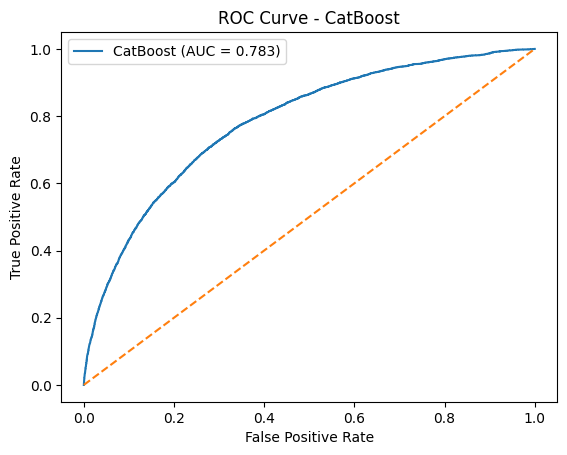

In [51]:
# Probabilities for the positive class (assumed label 1)
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost")
plt.legend()
plt.show()


In [55]:
model.get_feature_importance(prettified=True)[model.get_feature_importance(prettified=True)['Importances'] > 0]


Feature Id  Importances
0                            EXT_MEAN     7.717610
1                   ANNUITY_TO_CREDIT     4.944127
2                                 AGE     4.416218
3                     AMT_PAYMENT_MIN     3.098225
4                       AMT_ANNUITY_x     2.934494
..                                ...          ...
67        DAYS_CREDIT_ENDDATE_MISSING     0.025292
68        DAYS_INSTALMENT_MAX_MISSING     0.014885
69  NUM_INSTALMENT_NUMBER_MAX_MISSING     0.011712
70           AMT_PAYMENT_MEAN_MISSING     0.004820
71         AMT_INSTALMENT_MAX_MISSING     0.002531

[72 rows x 2 columns]

### lightgbm

In [56]:
# identify categorical columns (object or category)
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# convert them to category dtype
for c in cat_cols:
    X[c] = X[c].astype('category')


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [58]:
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos


In [60]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,            # -1 = no explicit limit
    num_leaves=64,           # can tune
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary',
    scale_pos_weight=scale_pos_weight,  # imbalance handling
    n_jobs=-1,
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    categorical_feature=cat_cols,
    eval_set=[(X_test, y_test)],
    eval_metric='auc'
)


[LightGBM] [Info] Number of positive: 19803, number of negative: 225021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12939
[LightGBM] [Info] Number of data points in the train set: 244824, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080887 -> initscore=-2.430360
[LightGBM] [Info] Start training from score -2.430360


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
               n_jobs=-1, num_leaves=64, objective='binary', random_state=42,
               scale_pos_weight=np.float64(11.362975306771702), subsample=0.8)

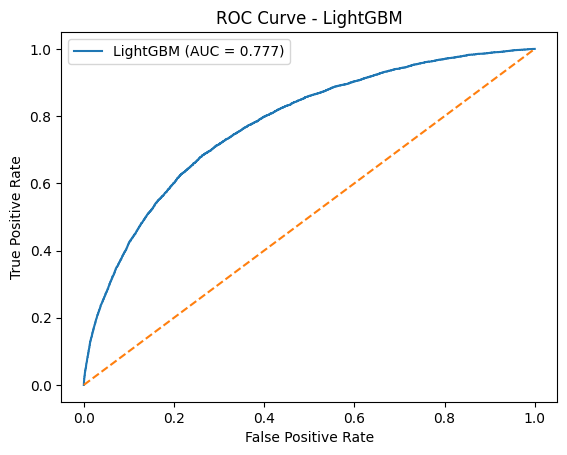

In [61]:
# Predicted probabilities for positive class
y_prob = lgbm.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()


* the top models(catboost-xgboost-lighgbm)

### now tune these 3 models 

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [76]:
preprocess = ColumnTransformer(
    transformers=[
        ('num','passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [69]:
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)


scale_pos_weight: 11.362975306771702


In [77]:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', xgb_base)
])

In [79]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
param_dist = {
    "model__n_estimators":     [200, 300, 400, 600],
    "model__max_depth":        [3, 4, 5, 6, 8],
    "model__learning_rate":    [0.01, 0.03, 0.05, 0.07, 0.1],
    "model__subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__gamma":            [0, 0.1, 0.2, 0.5],
    "model__reg_lambda":       [1, 1.5, 2, 3, 5],
}


In [80]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True
)

xgb_search.fit(X_train, y_train)

print("Best CV AUC:", xgb_search.best_score_)
print("Best params:", xgb_search.best_params_)
best_model = xgb_search.best_estimator_


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best CV AUC: 0.7779228770407594
Best params: {'model__subsample': 0.7, 'model__reg_lambda': 3, 'model__n_estimators': 400, 'model__min_child_weight': 5, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 1.0}


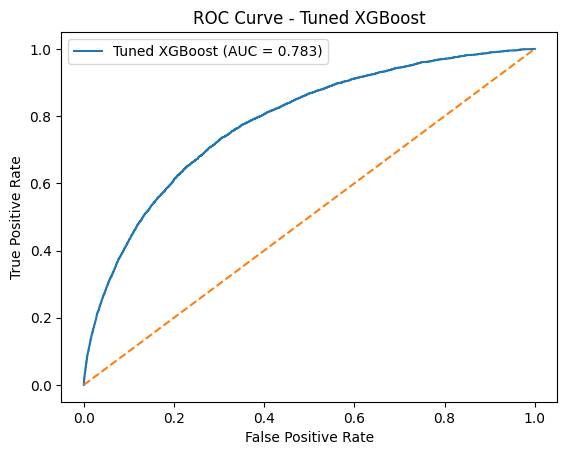

In [81]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Tuned XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned XGBoost")
plt.legend()
plt.show()


* excellent there is not overfitting 

In [82]:
import pickle

best_model = xgb_search.best_estimator_

with open("tuned_xgb_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Saved model to tuned_xgb_model.pkl")


Saved model to tuned_xgb_model.pkl


#### tuning cateboost 


In [88]:
from catboost import CatBoostClassifier, Pool
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

valid_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

In [89]:
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_state=42,
    verbose=0
)

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05],
    'iterations': [400, 600, 800],
    'l2_leaf_reg': [3, 5, 7],
    'bagging_temperature': [0.0, 0.5, 1.0],
}


In [92]:
grid_result = cat_model.randomized_search(
    param_grid,
    X=train_pool,
    n_iter=20,        
    cv=3,
    stratified=True,
    partition_random_seed=42,
    verbose=False,
    plot=False,
    refit=True,
    train_size=0.8
)

print("Best params:", grid_result["params"])


bestTest = 0.7849238459
bestIteration = 580

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7817111112
bestIteration = 396

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7838249612
bestIteration = 366

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7814639932
bestIteration = 312

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7771271016
bestIteration = 399

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7851200848
bestIteration = 585

Metric AUC is not calculated on train by default. To c

In [93]:
model.save_model("cat_model.cbm")

In [98]:
best_cat = cat_model


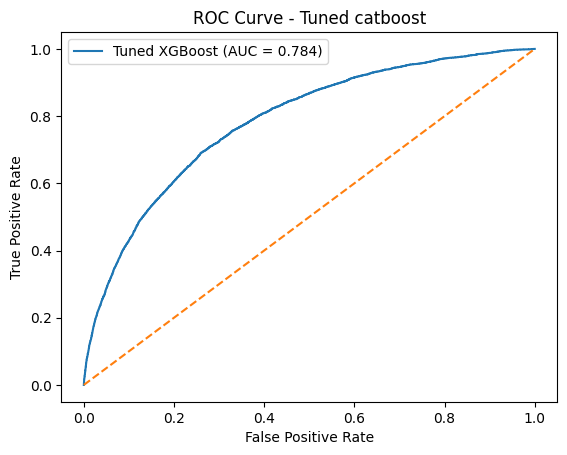

In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_cat.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Tuned XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned catboost")
plt.legend()
plt.show()


In [102]:
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_test[c]  = X_test[c].astype("category")


In [103]:
from lightgbm import LGBMClassifier

lgb_base = LGBMClassifier(
    objective="binary",
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)


In [104]:
param_dist = {
    "n_estimators":     [300, 500, 700],
    "learning_rate":    [0.03, 0.05, 0.07],
    "num_leaves":       [31, 63, 127],
    "max_depth":        [-1, 5, 7, 9],
    "min_child_samples":[20, 50, 100],
    "subsample":        [0.7, 0.8, 0.9, 1.0],   # bagging_fraction
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],   # feature_fraction
    "reg_lambda":       [0.0, 0.1, 1.0, 5.0],
    "reg_alpha":        [0.0, 0.1, 1.0],
}


In [105]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lgb_search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=25,                 # number of random combos to try
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True                 # refit on full train with best params
)

lgb_search.fit(X_train, y_train)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 19803, number of negative: 225021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12939
[LightGBM] [Info] Number of data points in the train set: 244824, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080887 -> initscore=-2.430360
[LightGBM] [Info] Start training from score -2.430360


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(n_jobs=-1, objective='binary',
                                            random_state=42,
                                            scale_pos_weight=np.float64(11.362975306771702)),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.03, 0.05, 0.07],
                                        'max_depth': [-1, 5, 7, 9],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [300, 500, 700],
                                        'num_leaves': [31, 63, 127],
                                        'reg_alpha': [0.0, 0.1, 1.0],
                                        'reg_lambda': [0.0, 0.1, 1.0, 5.0],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   scoring='roc_auc', verbose=1)

In [106]:
print("Best CV AUC:", lgb_search.best_score_)
print("Best params:", lgb_search.best_params_)


Best CV AUC: 0.7761724245163805
Best params: {'subsample': 0.9, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'num_leaves': 31, 'n_estimators': 500, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


In [107]:
best_lgb = lgb_search.best_estimator_


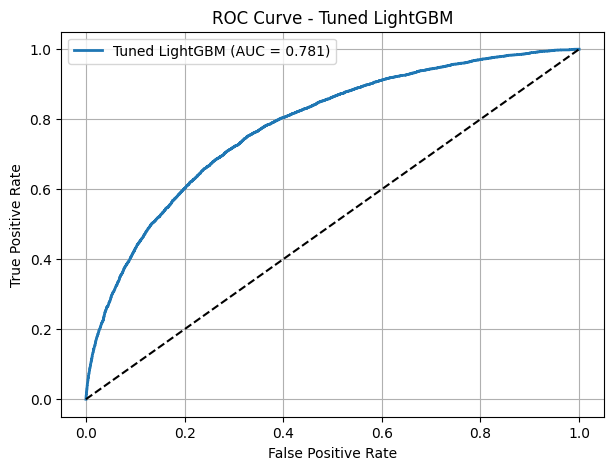

In [108]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = best_lgb.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Tuned LightGBM (AUC = {auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned LightGBM")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
best_model # this is the best for xgboost 
best_cat # the best for cat_boost
best_lgb # the best for best_lgb



In [156]:
X

EXT_MEAN  ANNUITY_TO_CREDIT        AGE  AMT_PAYMENT_MIN  \
0       0.161787           0.060749  25.920548         9251.775   
1       0.466757           0.027598  45.931507         6662.970   
2       0.642739           0.050000  52.180822         5357.250   
3       0.650442           0.094941  52.068493         2482.920   
4       0.322738           0.042623  54.608219            0.180   
...          ...                ...        ...              ...   
306025  0.413601           0.108198  25.553425         6605.910   
306026  0.115992           0.044524  56.917808        10046.880   
306027  0.499536           0.044239  41.002740           27.270   
306028  0.587593           0.054592  32.769863         2296.440   
306029  0.518984           0.072767  46.180822           34.965   

        AMT_ANNUITY_x  CREDIT_TO_PRICE   EXT_MIN   EXT_MAX  EXT_SOURCE_3  \
0             24700.5         1.158397  0.083037  0.262949      0.139376   
1             35698.5         1.145199  0.311267  0.622246      0.598382   
2              6750.0         1.000000  0.555912  0.729567      0.729567   
3             29686.5         1.052803  0.650442  0.650442      0.392835   
4             21865.5         1.000000  0.322738  0.322738      0.629947   
...               ...              ...       ...       ...           ...   
306025        27558.0         1.132000  0.145570  0.681632      0.387374   
306026        12001.5         1.198000  0.115992  0.115992      0.440857   
306027        29979.0         1.158400  0.218859  0.744026      0.218859   
306028        20205.0         1.158394  0.514163  0.661024      0.661024   
306029        49117.5         1.000000  0.113922  0.734460      0.113922   

        ANNUITY_TO_PRICE  ...  LIMIT_USAGE  \
0               0.070372  ...    13.521325   
1               0.031606  ...     1.256050   
2               0.050000  ...     0.000000   
3               0.099955  ...     0.000000   
4               0.042623  ...     0.000000   
...                  ...  ...          ...   
306025          0.122480  ...     0.000000   
306026          0.053340  ...     0.000000   
306027          0.051246  ...     0.000000   
306028          0.063239  ...     0.000000   
306029          0.072767  ...     0.000000   

        PRODUCT_COMBINATION_Cash_Street_high_MEAN  \
0                                        0.000000   
1                                        0.000000   
2                                        0.000000   
3                                        0.000000   
4                                        0.166667   
...                                           ...   
306025                                   0.000000   
306026                                   0.000000   
306027                                   0.000000   
306028                                   0.000000   
306029                                   0.000000   

        PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN_MISSING  \
0                                                      0   
1                                                      0   
2                                                      0   
3                                                      0   
4                                                      0   
...                                                  ...   
306025                                                 0   
306026                                                 0   
306027                                                 0   
306028                                                 0   
306029                                                 0   

        YEARS_EMPLOYED_MISSING  AREA_PER_POP_MISSING  AMT_PAYMENT_SUM_MISSING  \
0                            0                     0                        0   
1                            0                     0                        0   
2                            0                     1                        0   
3                            0                     1   